In [1]:
import time
import numpy as np
import gymnasium as gym
import tqdm
import matplotlib.pyplot as plt

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, trials_from_docs
from nlk_gym import NLK_Env

from multiprocessing import Pool

# Register the environment
gym.register(
    id='NLK_Env-v0',
    entry_point='nlk_gym:NLK_Env'
)
env = gym.make('NLK_Env-v0')
n_actions = 1 #dimension of action space

In [3]:
network_sizes = [     #list of network sizes we want to optimise over
    [256], [128], [256, 128], 
    [32,32,16],[64,64],[32,32]
]

In [4]:
import stable_baselines3
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

In [5]:
space = {'noise_std': hp.uniform ('noise_std', 0, 2),    #hyperparameter space
        "learning_rate" : hp.uniform ('learning_rate', 1e-6, 5e-3),
        'piNN' : hp.choice('piNN', network_sizes),
        'qfNN' : hp.choice('qfNN', network_sizes),
        'gamma': hp.uniform ('gamma', 0, 2),
        }

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class NLK_Sampler:
    #this class is used to sample new electrons
    def __init__(self):
        self.lower = np.array([0.01242802014328473,-2.3510967845422677,    #lower polynom weights, for injection area
                                 135.64889234592374,-2621.6674111929387,8374.6738385004])   
        self.upper = np.array([-0.026705410090359233,6.412451482988342,  #upper polynom weights, for injection area
                                 -549.8383734808201,20891.368558370945,-298723.030031348])
        self.diff = self.upper-self.lower
        self.transform = np.array([-3.2911361375977704,102.00328087158005,
                                   15593.102791660853,-518062.7698926044])
        self.poly = PolynomialFeatures(degree=4)
        self.poly_transform = PolynomialFeatures(degree=3)
    
    def sample(self):
        x = np.random.uniform(size=(1,1))
        x = x**1.8       #fixing term, not known why to use
        x = x*(22.85e-3-15e-3)+15e-3

        x_poly = self.poly_transform.fit_transform(x)
        x = x_poly@self.transform
        x = x*(22.85e-3-15e-3)+15e-3

        x = np.array([[x[0]]])
        

        height = np.random.uniform()
        x_poly = self.poly.fit_transform(x)   #to x^0,x^1,...,x^4
        y = x_poly@self.lower + height*x_poly@self.diff
        return x[0,0],y[0]
    
nlk_sampler = NLK_Sampler()

In [7]:
def performance_test(model, deterministic = True):
    #function tests the performance on hte injection set
    env = gym.make('NLK_Env-v0', deterministic = deterministic) #environment is made deterministic, to make performances comparable
    x_list = np.linspace(15e-3,22.85e-3,100)   #xlist in m. 
    px_list = np.linspace(-0.0008,0.0012,50)   #pxlist in rad
    
    poly = PolynomialFeatures(degree=4)
    nlk_sampler = NLK_Sampler()
    
    extended_x_list = [x for x in x_list for i in range(len(px_list))]
    extended_px_list = np.tile(px_list,(len(x_list),))
    
      
    Z = np.zeros((len(x_list),len(px_list)))       #save performances
    Z_round = np.zeros((len(x_list),len(px_list))) #save kicked rounds
    
    new_list = []
    counter = 0
    reward_sum = 0
    for i in range(len(x_list)):
        x_poly = poly.fit_transform(np.array([[x_list[i]]]))
        #for the x value calculate the lower and upper value of the injection area
        x_lower = x_poly@nlk_sampler.lower
        x_upper = x_poly@nlk_sampler.upper
        
        for j in range(len(px_list)):
            px_value = 0
            info = []
            if px_list[j]>x_lower and px_list[j]<x_upper:  #check if x,px value is in injection area
                
                counter+=1
                
                reward, runde = performance_on_point(model,x_list[i],px_list[j],env)   #check performance
                try: 
                    reward_sum += reward[0]*1000   #normalise reward
                    Z[i,j] = reward[0]*1000        #normalise reward
                except:
                    try: 
                        reward_sum += reward*1000 
                        Z[i,j] = reward*1000
                    except: print("something is wrong")
                        
                

                Z_round[i,j] = runde
                
                
            else:
                #if not in the injection area, return nan
                Z[i,j]=np.nan
                Z_round[i,j] = np.nan
                
                
    return reward_sum/counter, Z,Z_round

def performance_on_point(model,x,px,env):
        
    obs, info = env.reset(options={"x,px":(x,px)}) #reset environment
    done = False
    runde = -1

    while done == False:
        runde +=1
        action, _states = model.predict(obs)
        
        obs, reward, done, _, _ = env.step(action)
                
        
    return reward,runde


In [8]:
from matplotlib import colors

def show_plots(Z, Z_round):
    """
    create the plots
    """
    x_list = np.linspace(15e-3,22.85e-3,100)
    px_list = np.linspace(-0.0008,0.0012,50)

    fig, ax = plt.subplots(figsize=(9,5))

    pc = ax.pcolormesh(x_list*1000,px_list*1000,Z.T,shading='auto')
    fig.colorbar(pc)

    plt.title(f"Model performance, in single electron env")
    plt.ylabel("px in mrad")
    plt.xlabel("x in mm")
    plt.show()

    
    
    bounds = np.linspace(0, 6, 6 +1)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend="max")

    fig, ax = plt.subplots(figsize=(9,5))

    
    pc = ax.pcolormesh(x_list*1000,px_list*1000,Z_round.T,shading='auto',norm=norm)
    
    cb=fig.colorbar(pc)
    
    
    label_bounds = bounds[:-1]
    
    cb.set_ticks(label_bounds + 0.5)
    cb.set_ticklabels([f"{int(b):d}" for b in label_bounds])

    
    
    plt.title(f"In which round model kicked, in single electron env")
    plt.ylabel("px in mrad")
    plt.xlabel("x in mm")
    plt.show()
    
#show_plots(Z, Z_round)

In [9]:
def train(batch_size,learning_rate,noise_std,size_pi,size_qf,duration,gamma = 0.975,learning_starts=100):
    #special inputs: -duration in hours
    #       -size_pi and size_qf as indicies for network_sizes list
    env = gym.make('NLK_Env-v0')   #set environment  
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions),   #set action noise
                                                sigma=noise_std*np.ones(n_actions))

    policy_kwargs = dict(net_arch=dict(pi=network_sizes[size_pi], qf=network_sizes[size_qf])) #set network sizes


    model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1, learning_rate=learning_rate,
                             batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs,
                             learning_starts=learning_starts)

    a = time.time()
    while time.time()-a<60*60*duration:
        model.learn(total_timesteps=2000, log_interval=3000)
    return model

Here we already knew good hyperparameters and searched for the best model

The best found model is found under number 430

---------------------
400
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 776.0555504421396


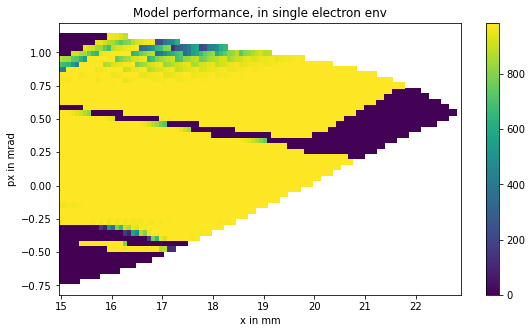

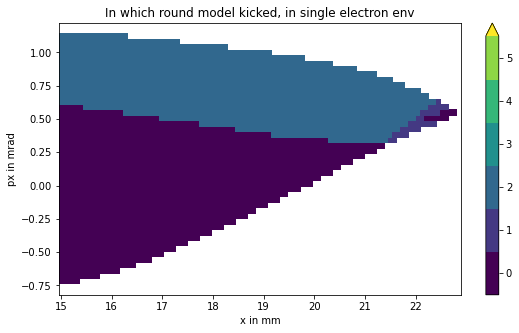

---------------------
401
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 756.5264772942279


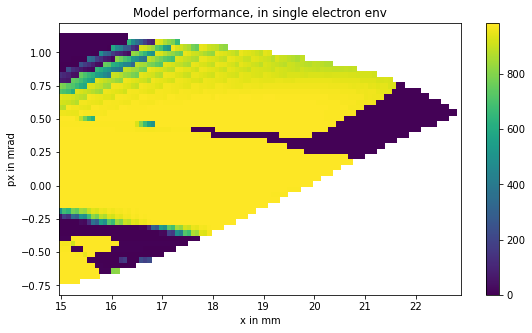

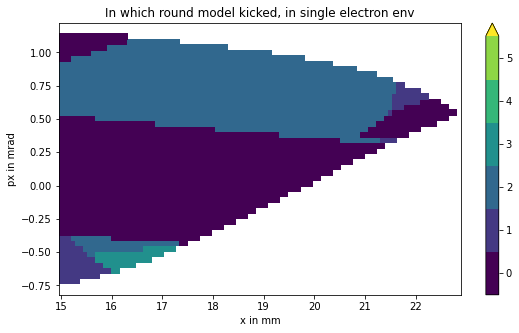

---------------------
402
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


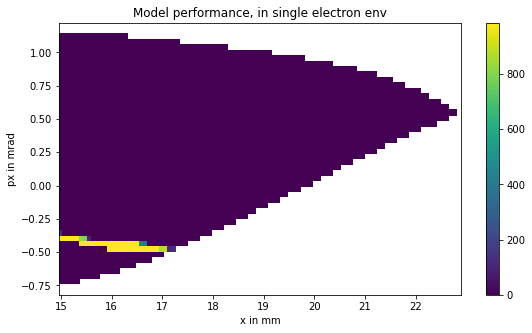

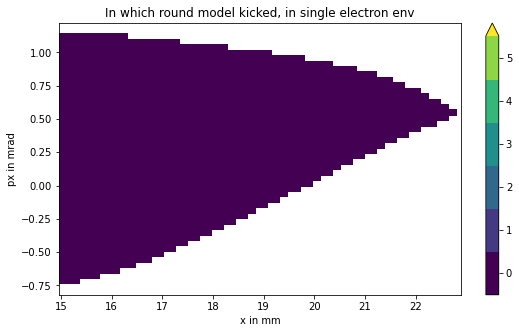

---------------------
403
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 804.8520033972703


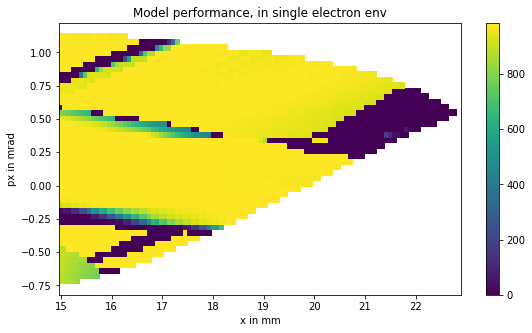

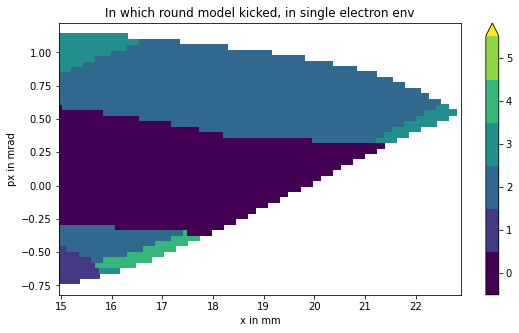

---------------------
404
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 801.1043680629064


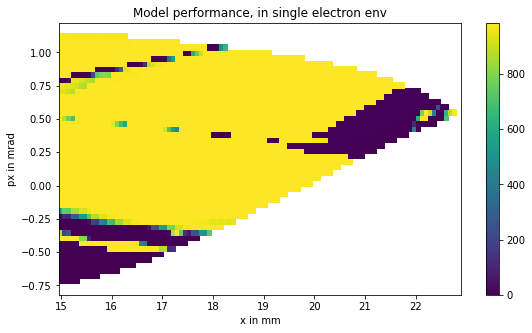

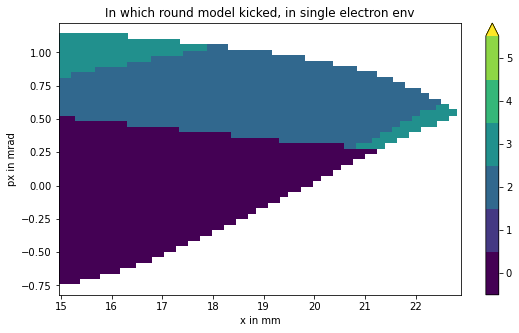

---------------------
405
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 0.3608058608058608


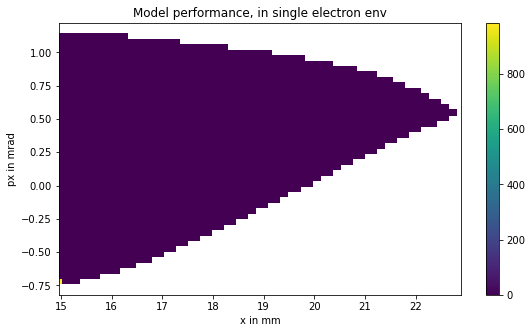

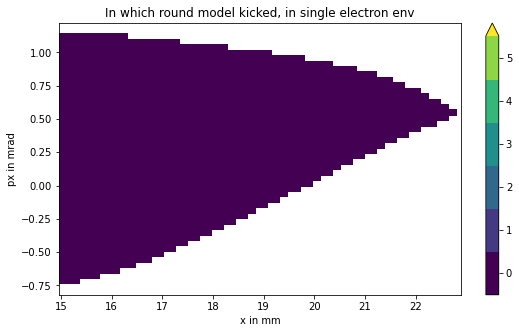

---------------------
406
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 689.8470951477235


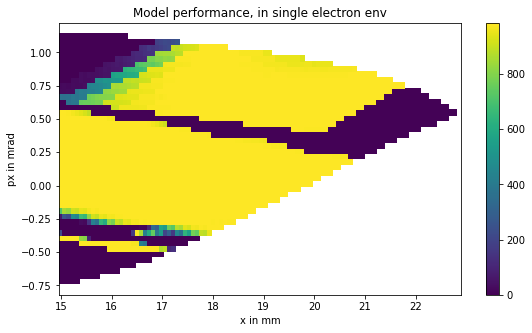

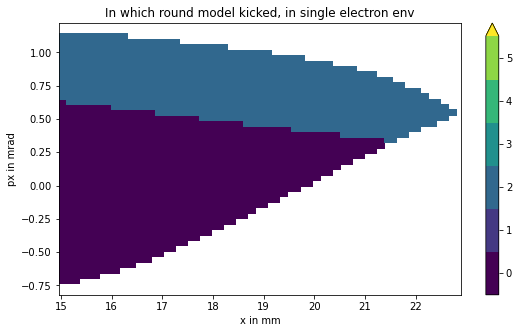

---------------------
407
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 0.3608058608058608


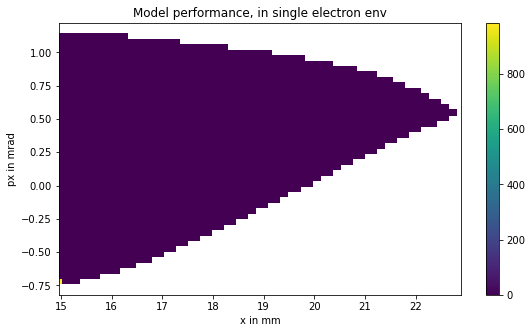

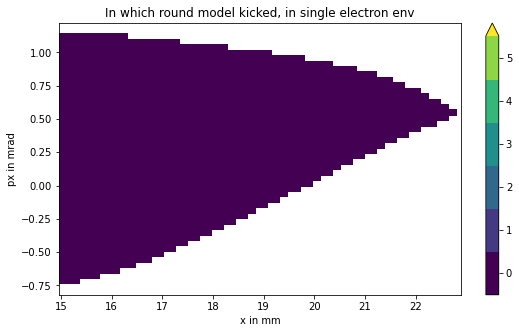

---------------------
408
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


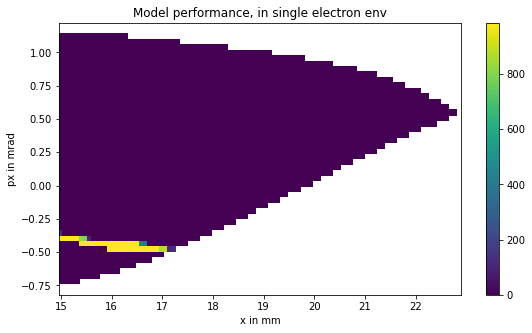

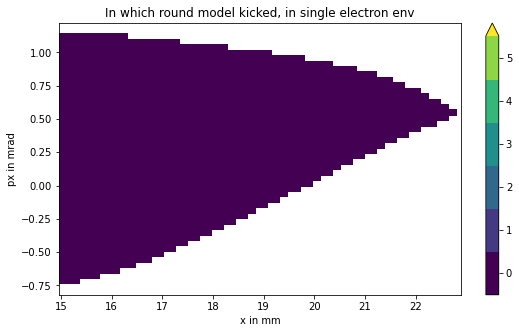

---------------------
409
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 771.3388754341673


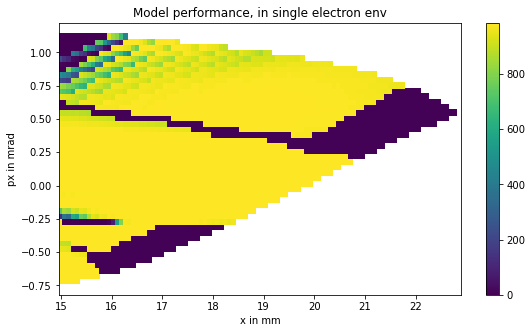

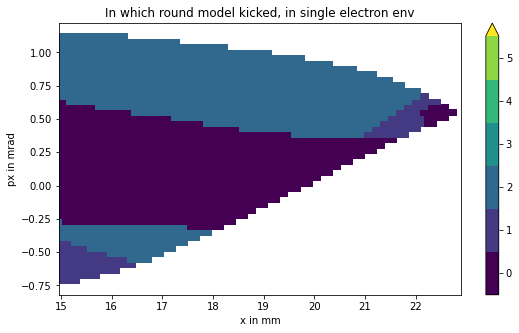

---------------------
410
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


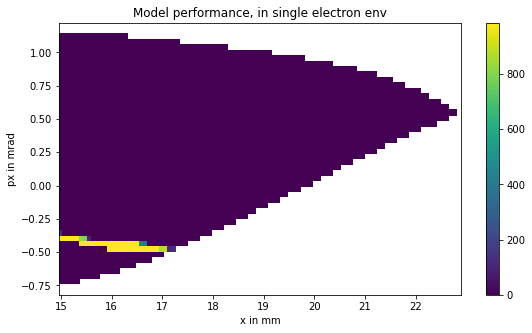

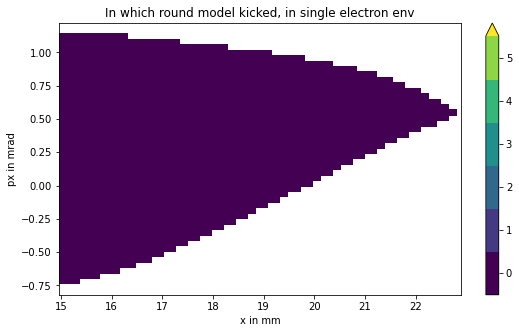

---------------------
411
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 762.3051337191932


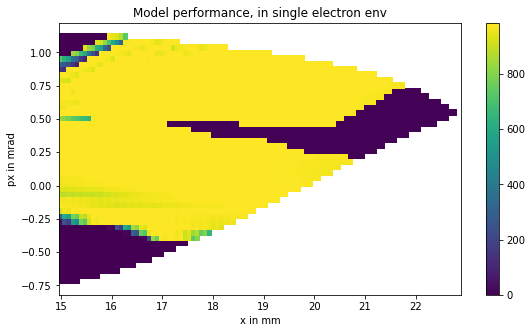

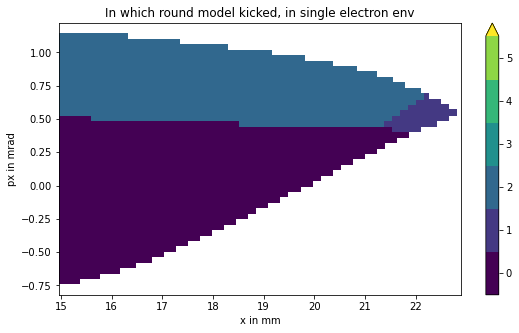

---------------------
412
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


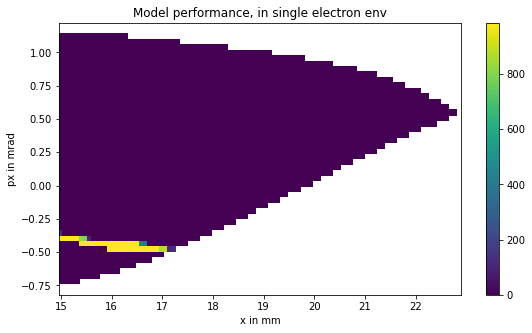

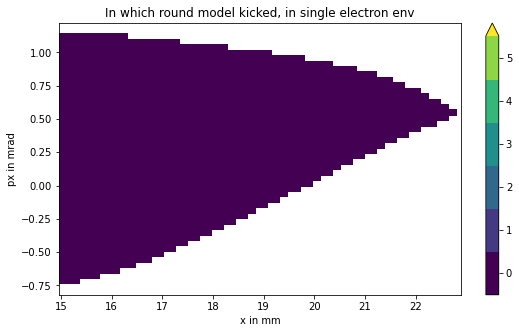

---------------------
413
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 836.3541370281598


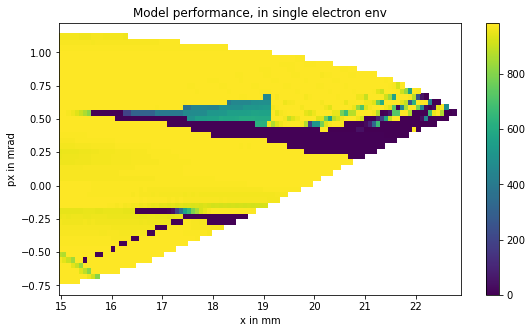

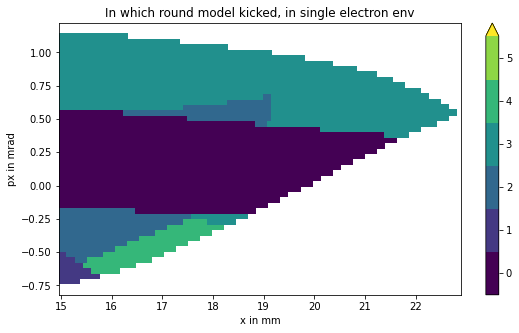

---------------------
414
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 788.5368903207795


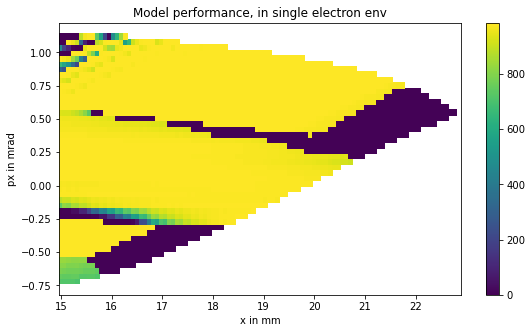

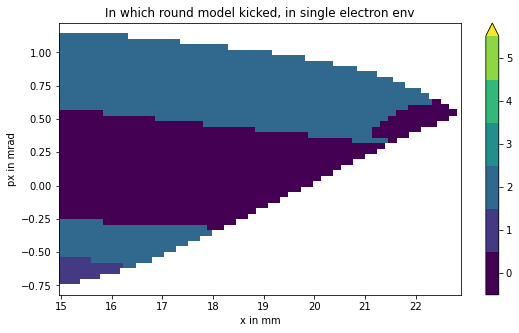

---------------------
415
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 803.5970856855861


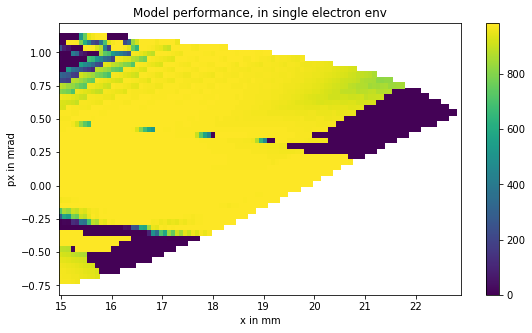

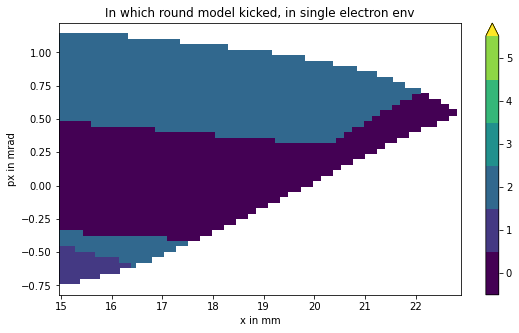

---------------------
416
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 390.73141069514423


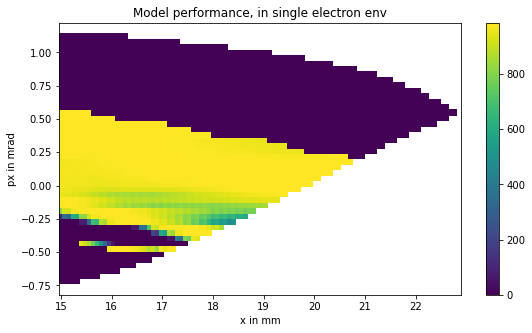

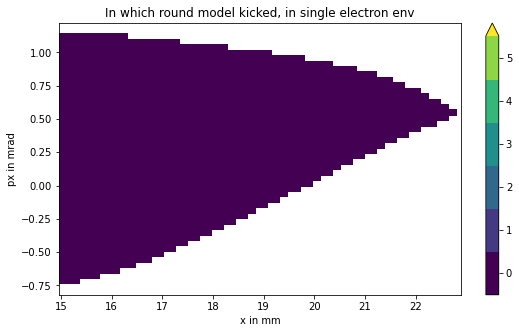

---------------------
417
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 781.6496245625323


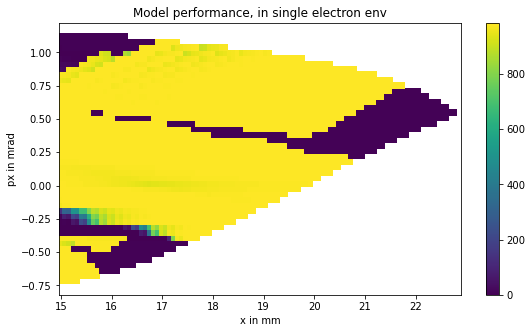

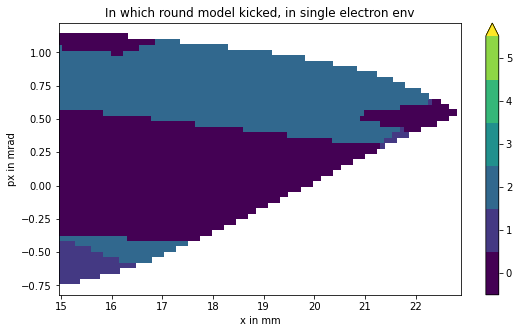

---------------------
418
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 410.61686272143135


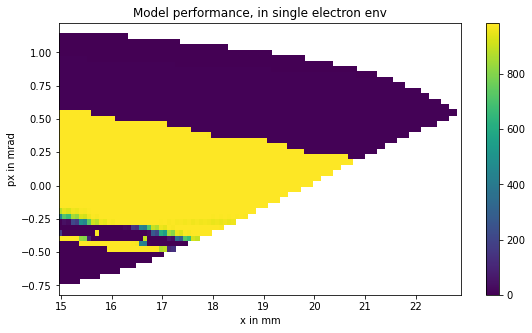

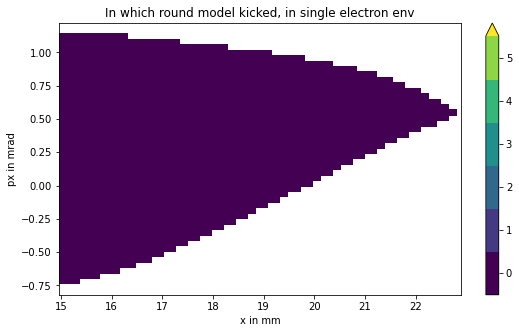

---------------------
419
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 794.1188424896795


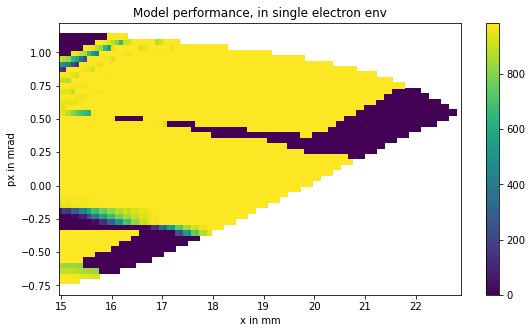

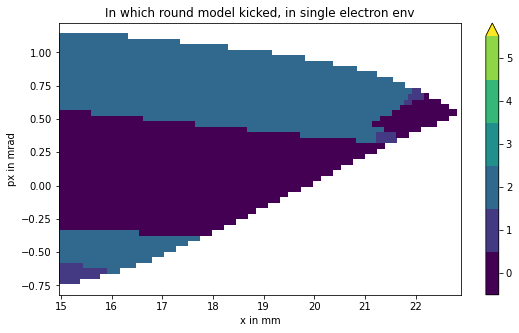

---------------------
420
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 768.3130066072958


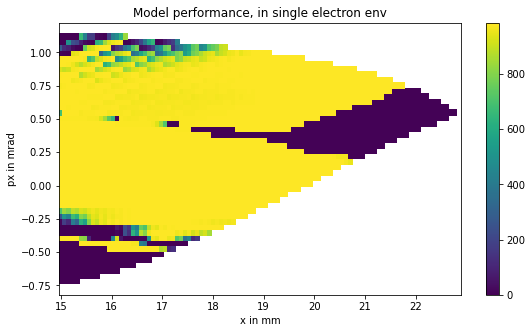

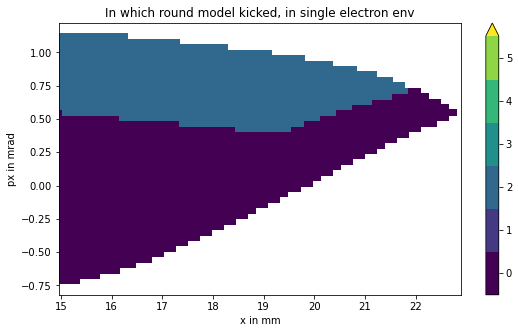

---------------------
421
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 803.7101681834046


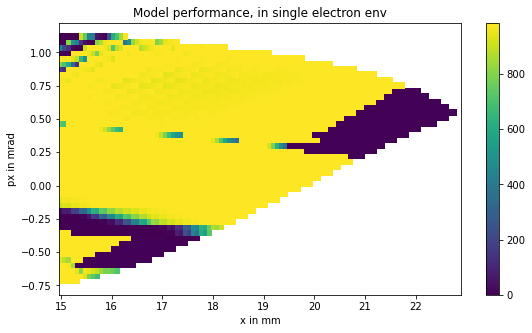

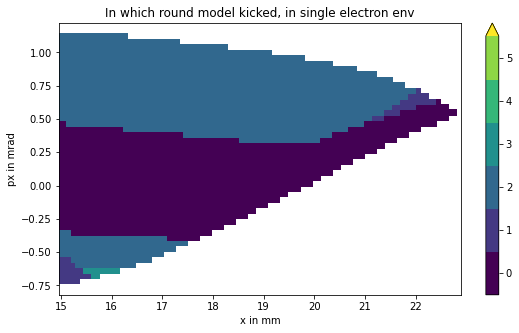

---------------------
422
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 804.771339173245


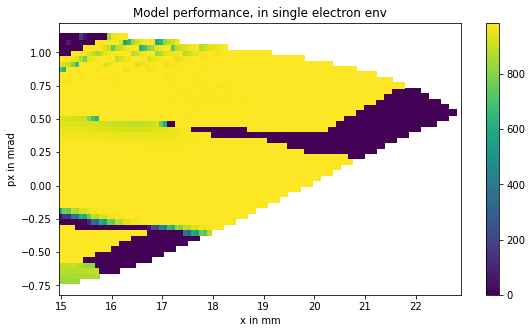

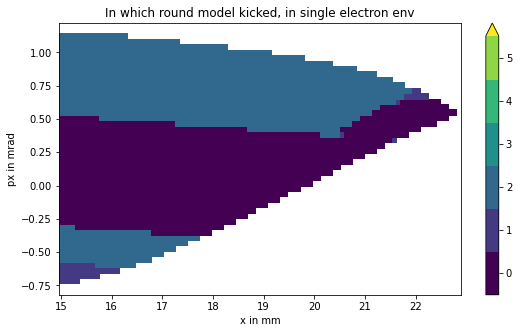

---------------------
423
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 800.9197153643726


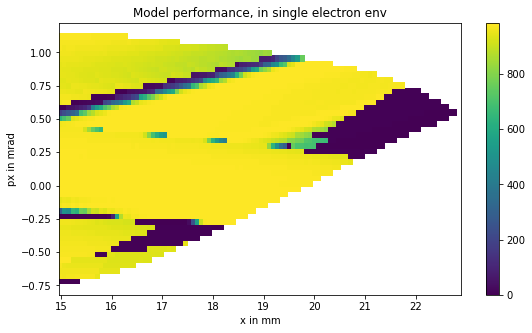

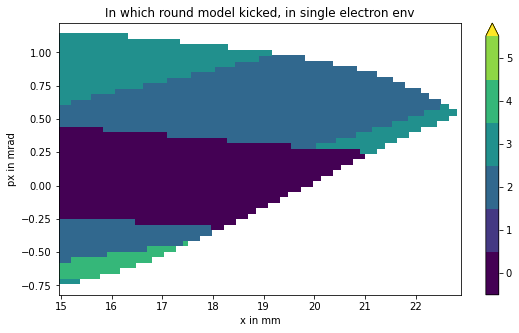

---------------------
424
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


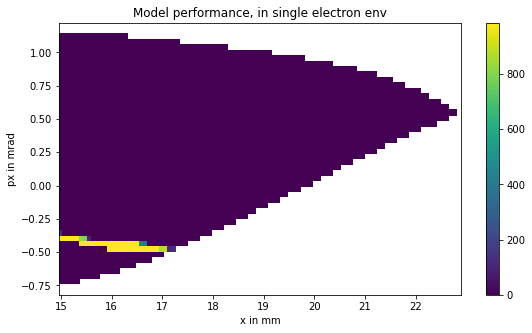

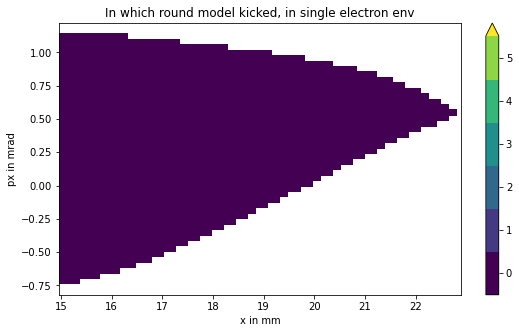

---------------------
425
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 396.74641818391996


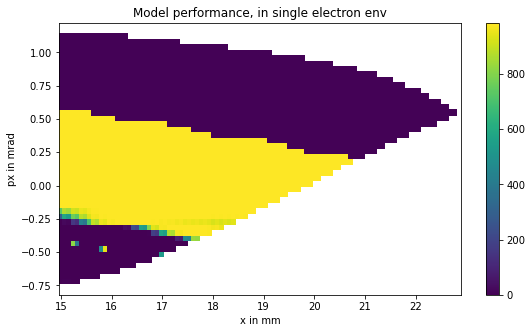

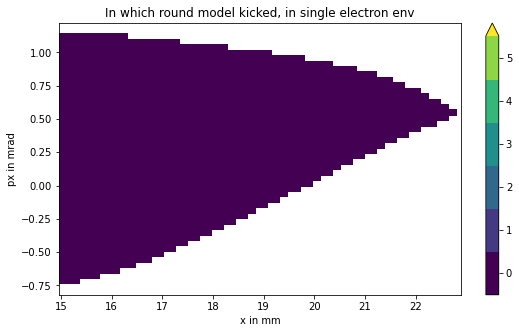

---------------------
426
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 746.1816067479957


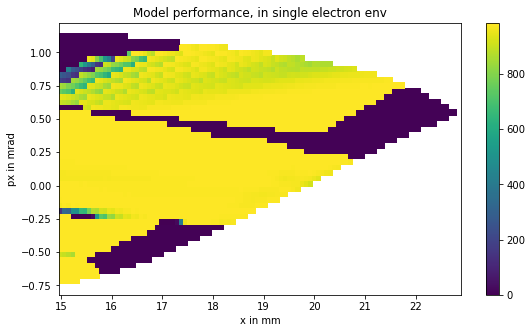

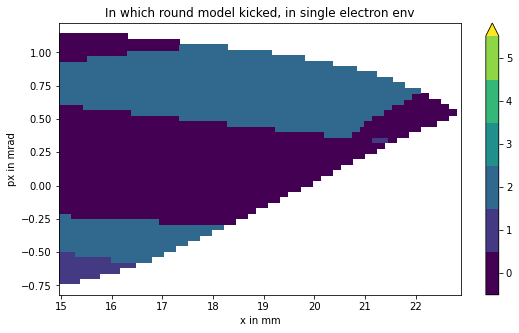

---------------------
427
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 814.481219982567


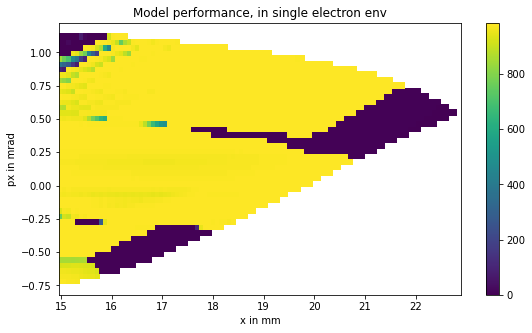

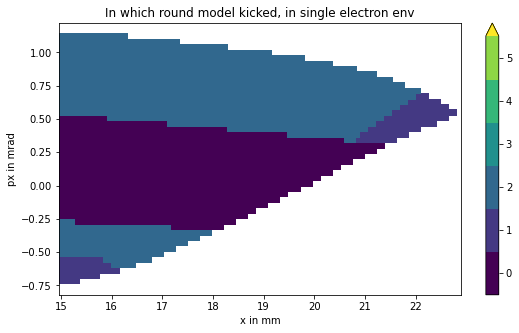

---------------------
428
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 390.31622889266197


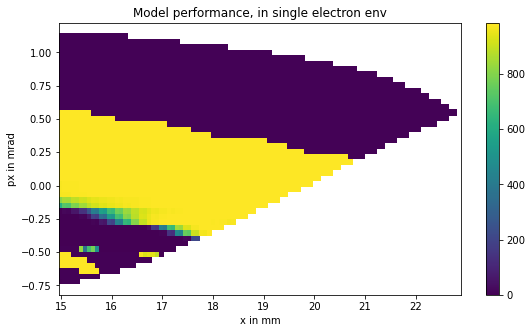

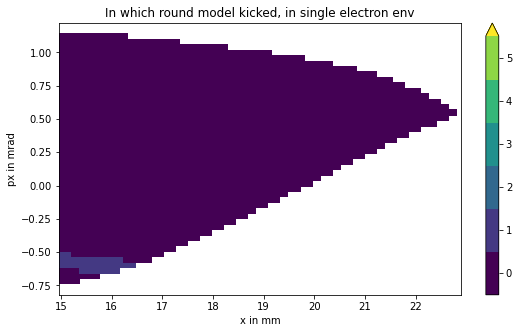

---------------------
429
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


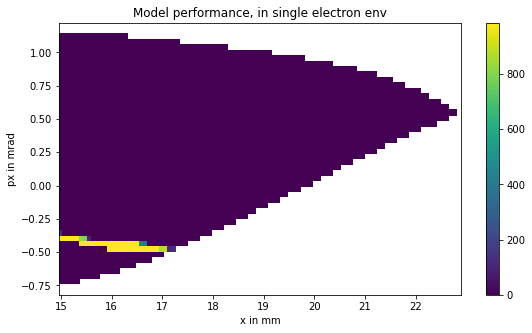

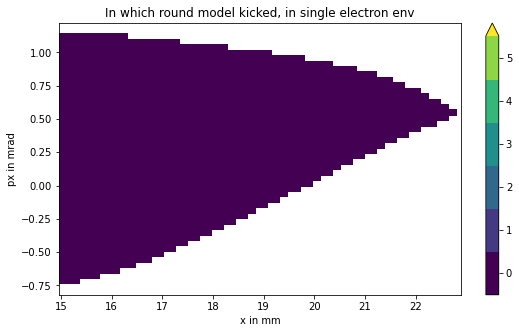

---------------------
430
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 875.6530333933588


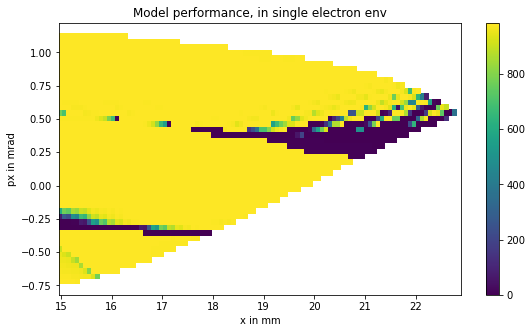

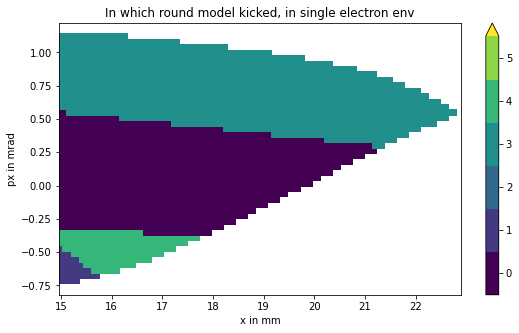

---------------------
431
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 760.00374923599


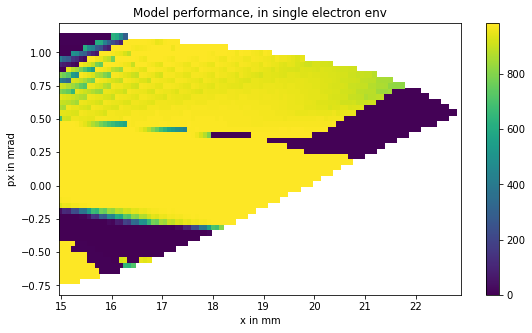

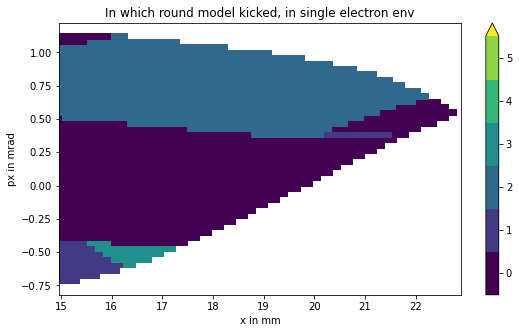

---------------------
432
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


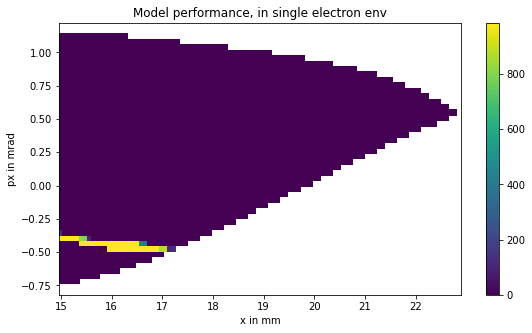

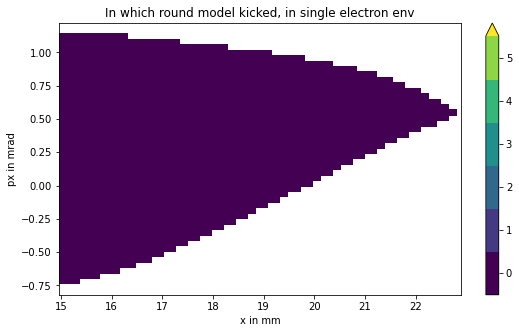

---------------------
433
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 816.7204138851595


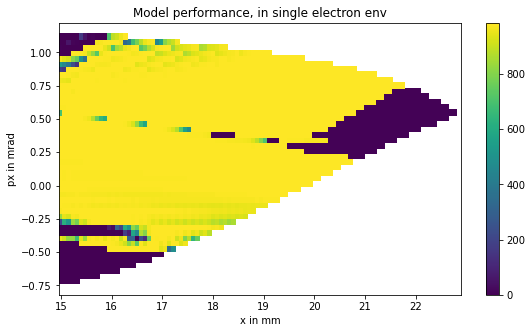

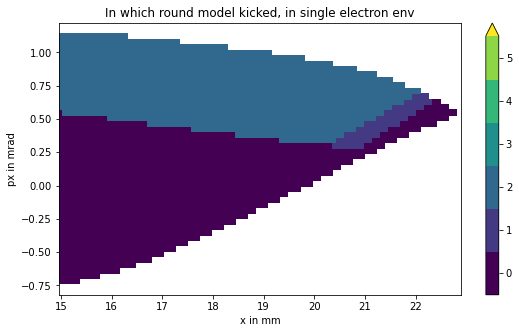

---------------------
434
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 753.7837377258403


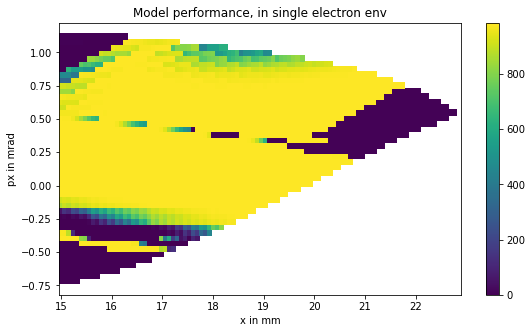

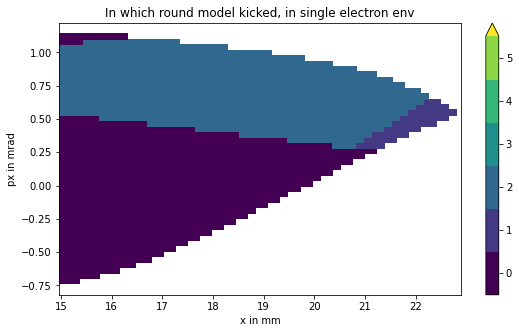

---------------------
435
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 420.19240390042125


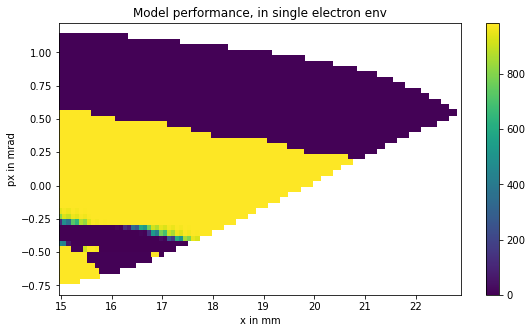

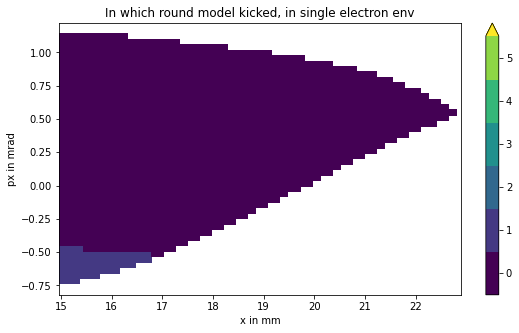

---------------------
436
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 0.36080590228894294


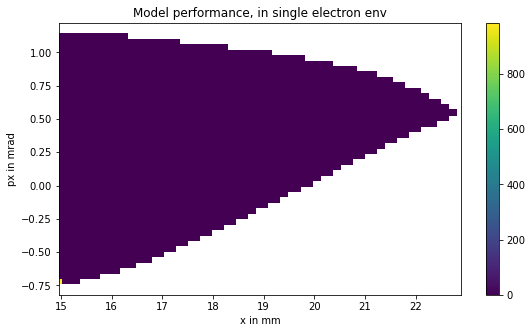

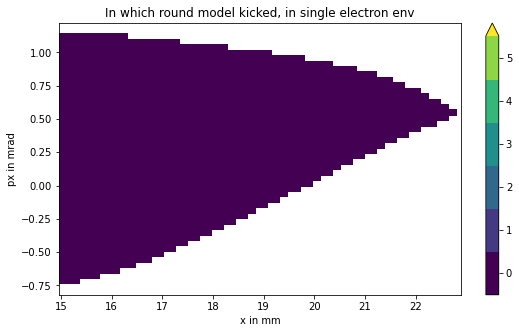

---------------------
437
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


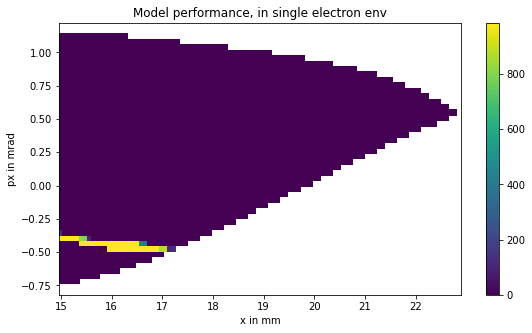

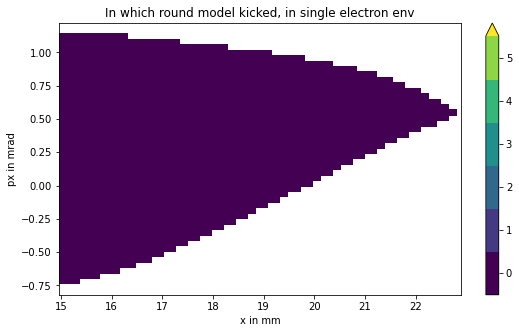

---------------------
438
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 758.0697387016901


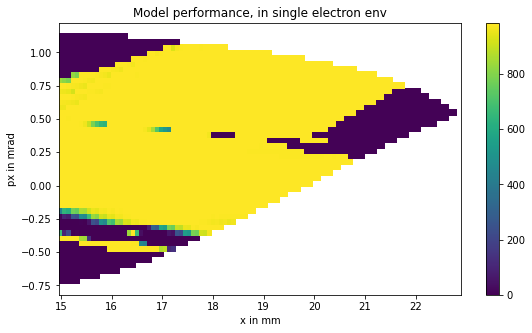

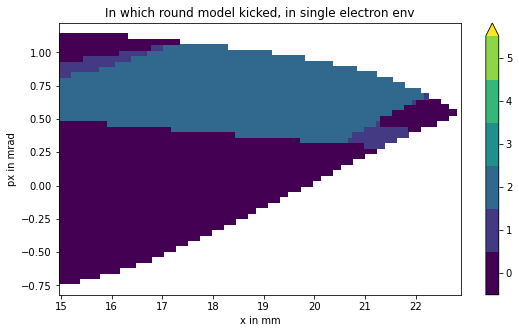

---------------------
439
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


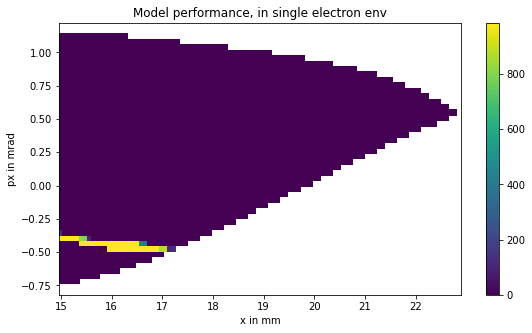

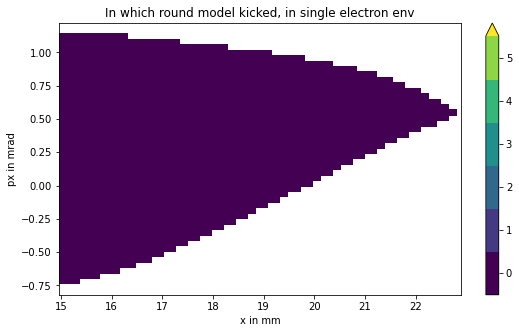

---------------------
440
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 760.4000696978002


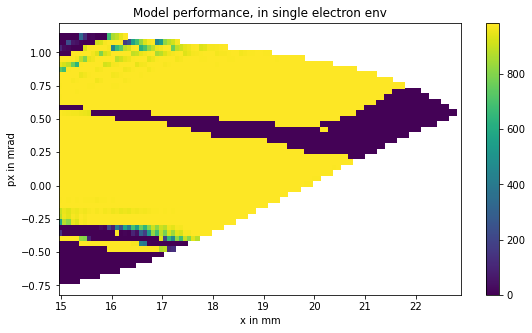

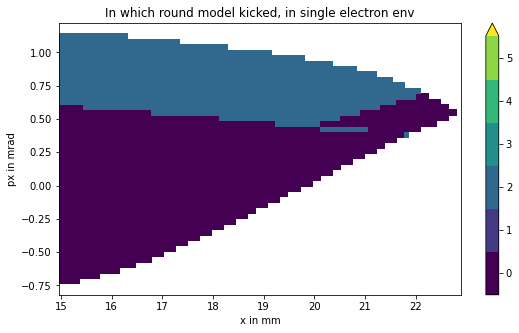

---------------------
441
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


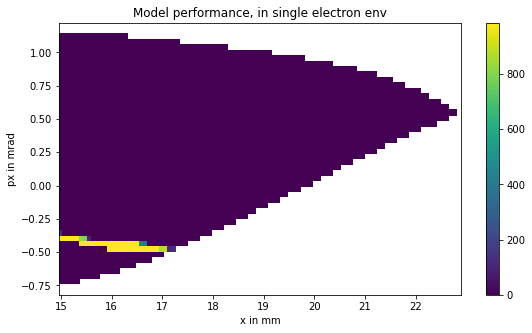

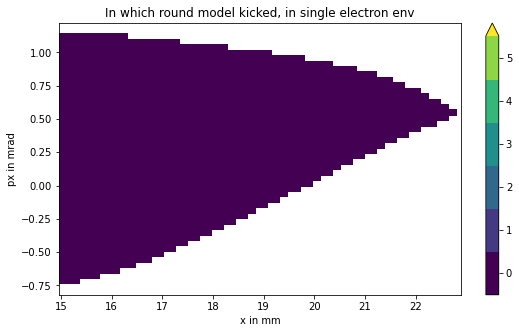

---------------------
442
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 712.2463774388999


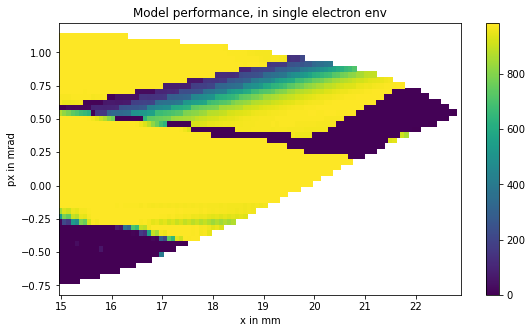

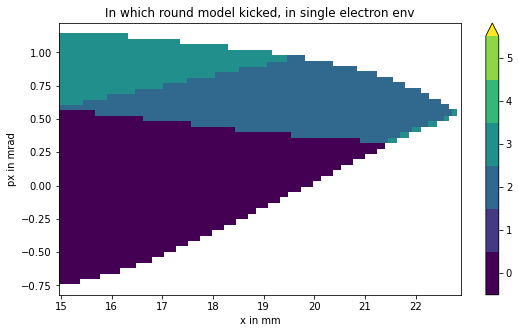

---------------------
443
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 791.4549778168964


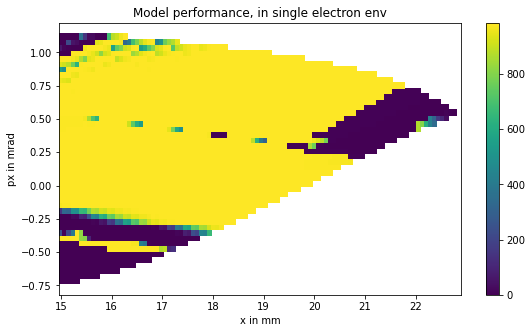

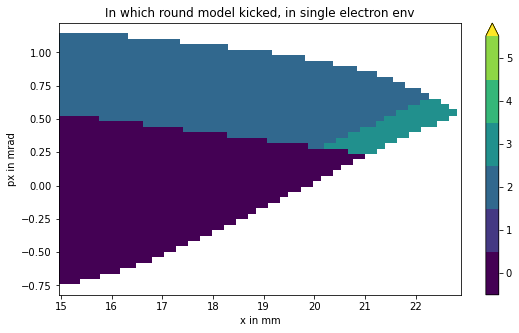

---------------------
444
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 763.8729066071577


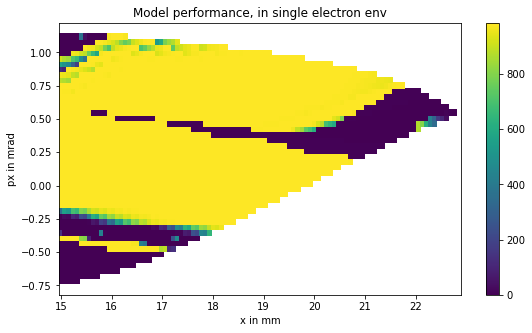

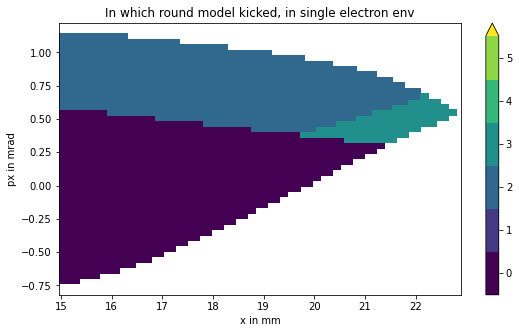

---------------------
445
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 776.8848493561546


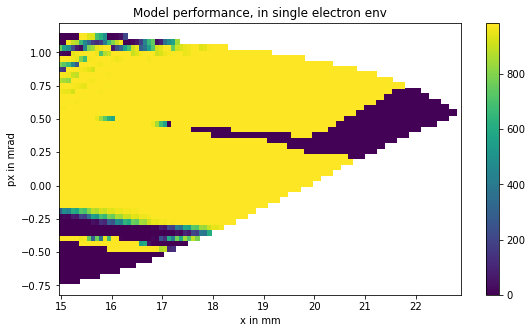

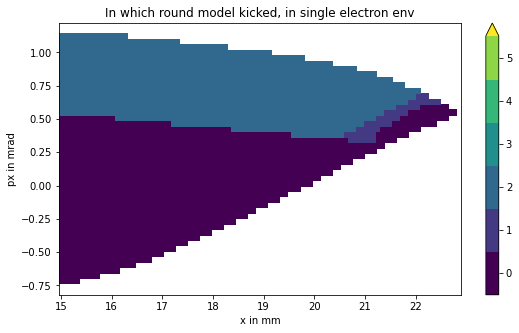

---------------------
446
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


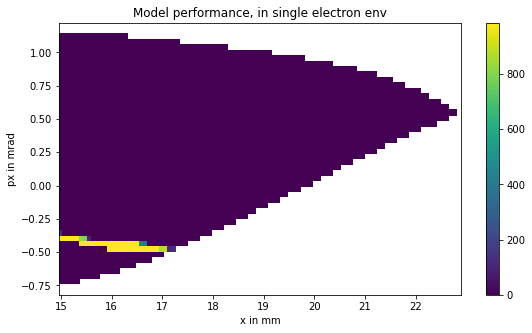

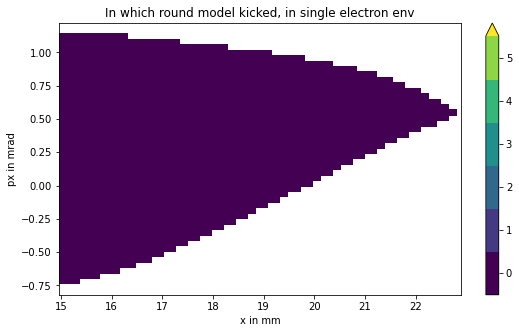

---------------------
447
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


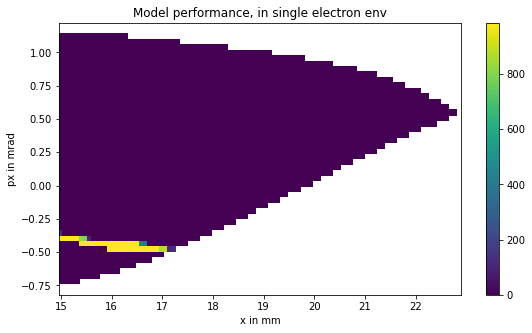

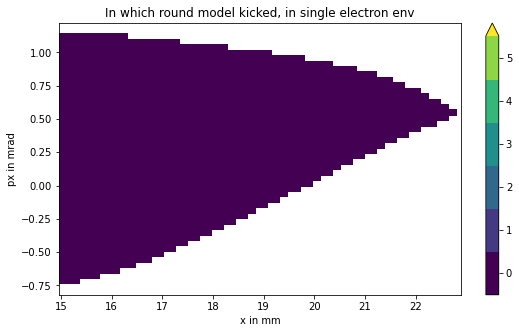

---------------------
448
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 0.3608058608058608


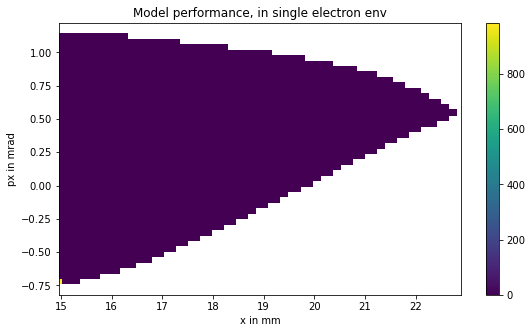

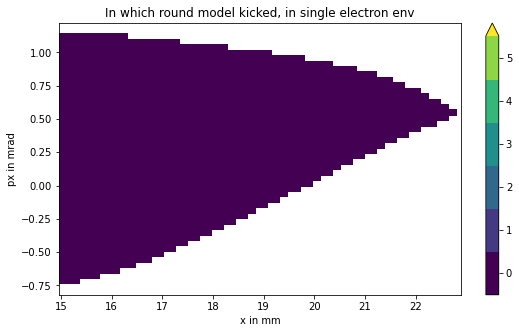

---------------------
449
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


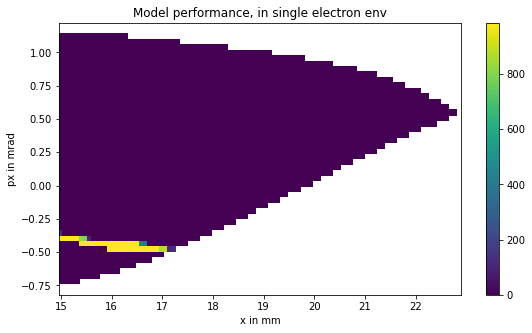

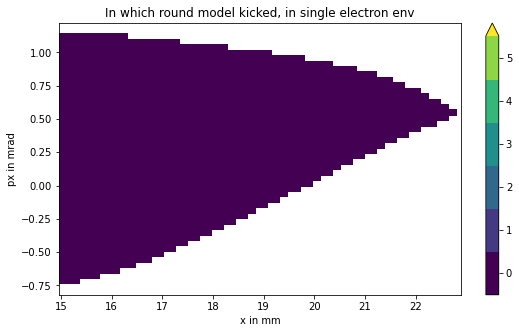

---------------------
450
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 781.6055829754504


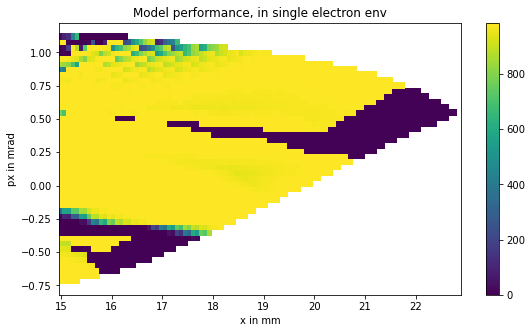

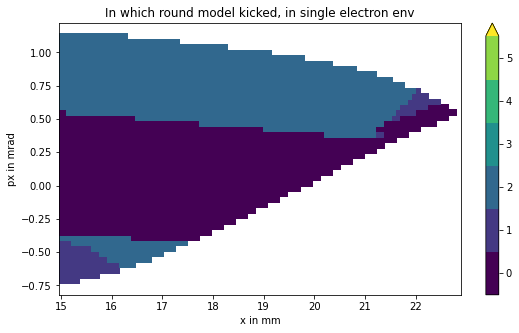

---------------------
451
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 780.8605769966257


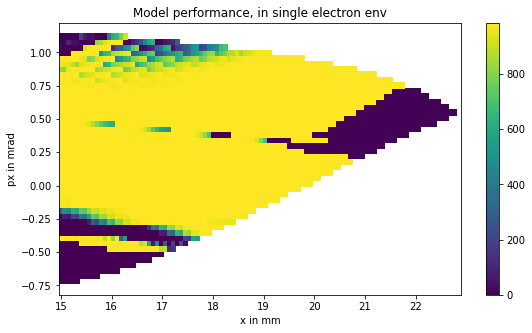

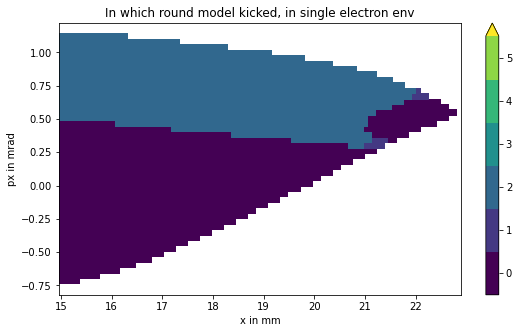

---------------------
452
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 806.897909533292


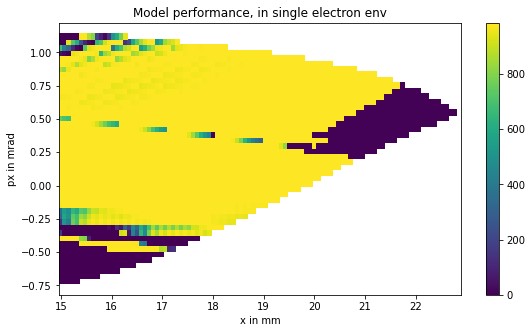

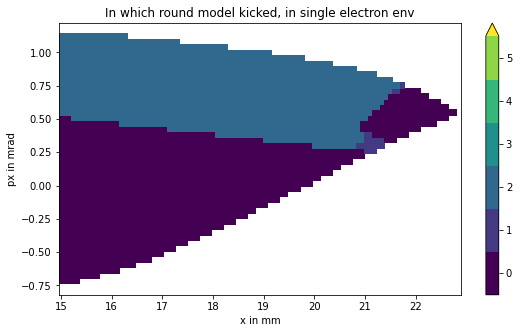

---------------------
453
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 814.3361788914077


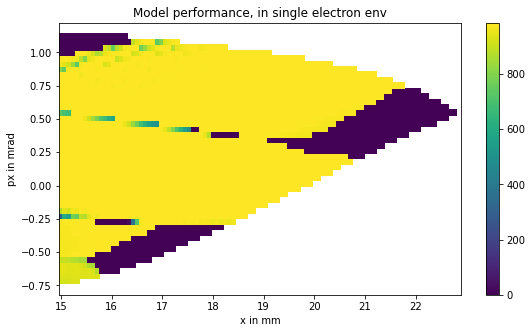

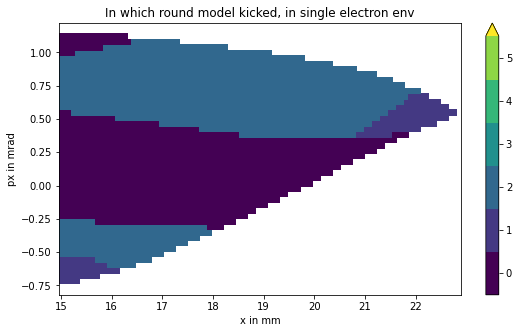

---------------------
454
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 832.2304039711448


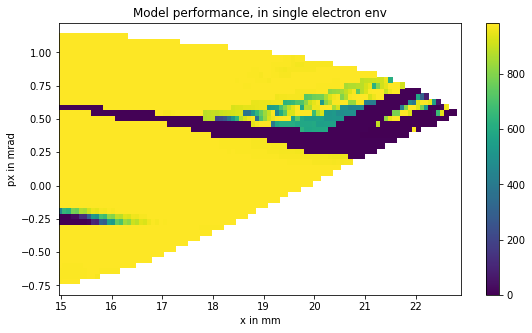

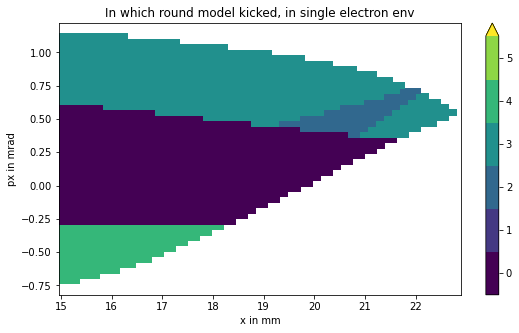

---------------------
455
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 754.5560048888991


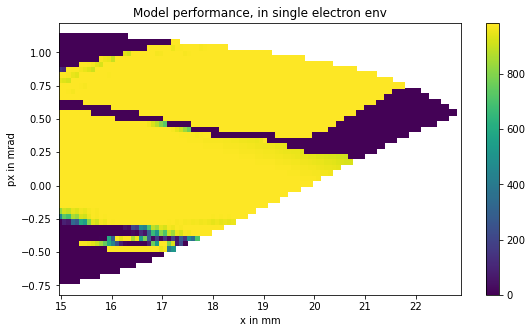

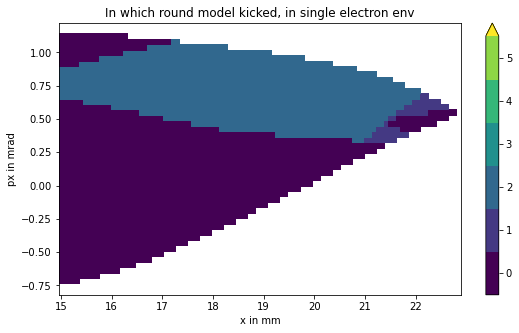

---------------------
456
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 806.723753527597


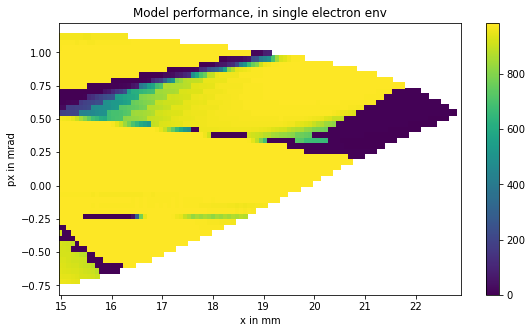

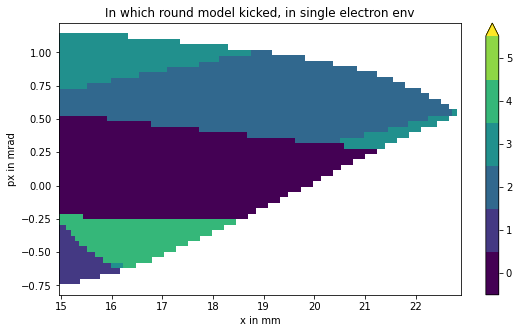

---------------------
457
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 743.0934521073823


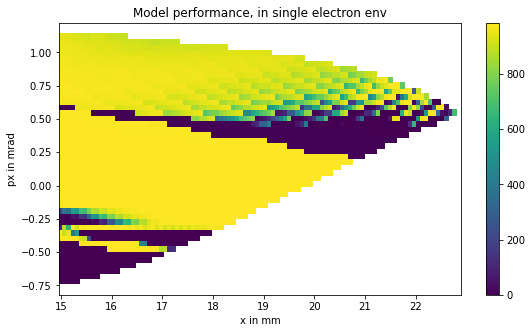

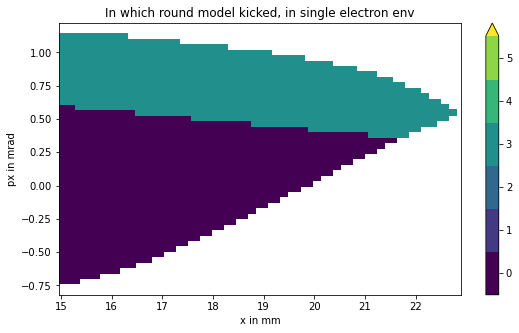

---------------------
458
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 809.3116881911818


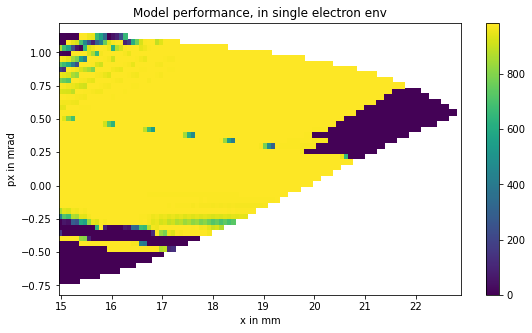

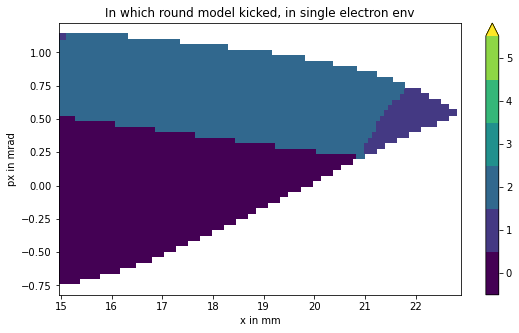

---------------------
459
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 408.2135831927799


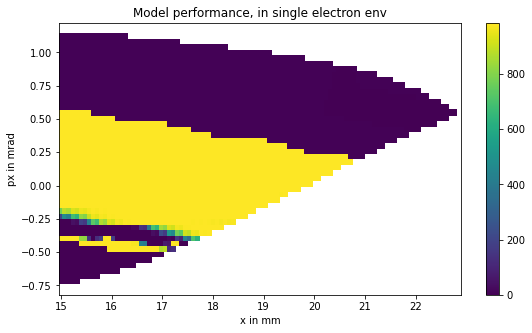

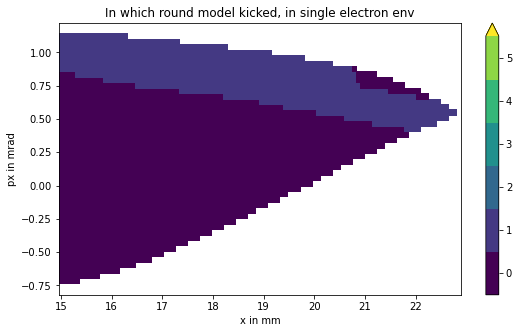

---------------------
460
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 758.6555270973296


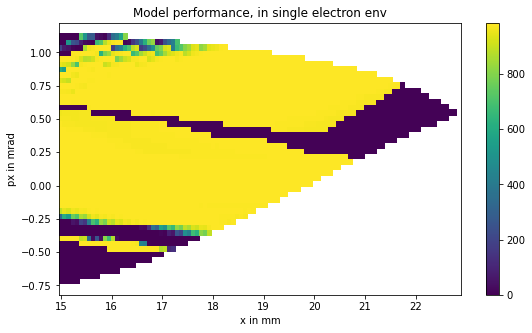

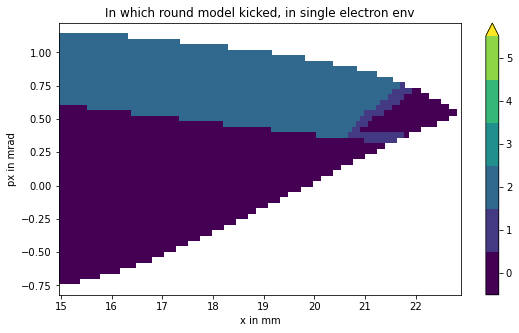

---------------------
461
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 734.9637286508348


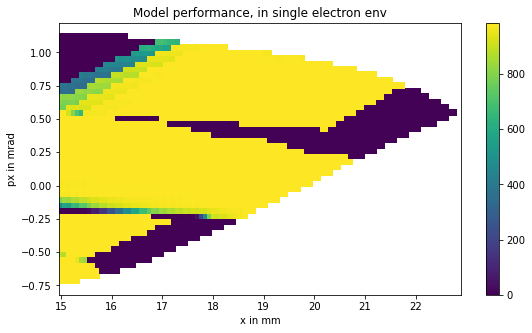

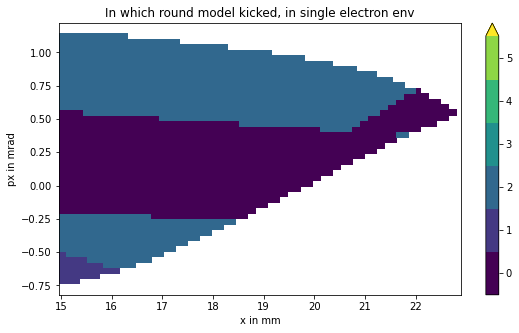

---------------------
462
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 811.5992316899358


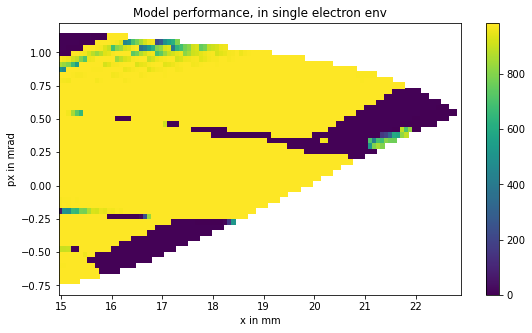

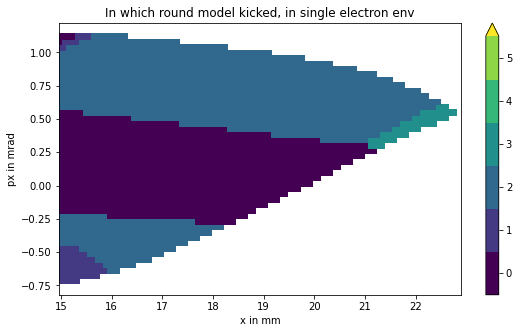

---------------------
463
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


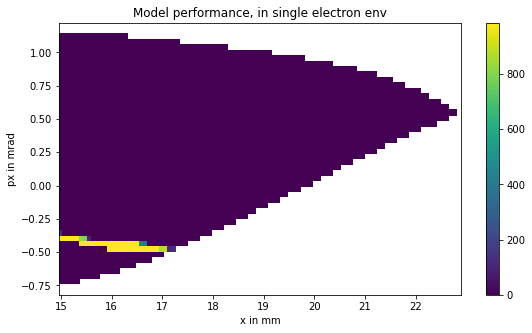

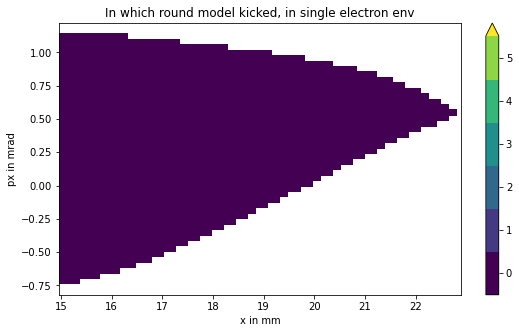

---------------------
464
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 809.4539409578967


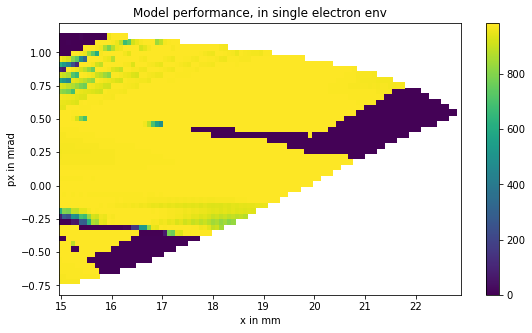

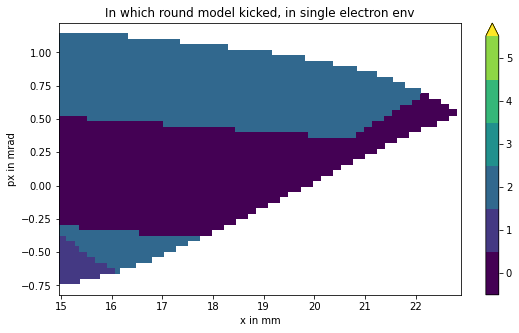

---------------------
465
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


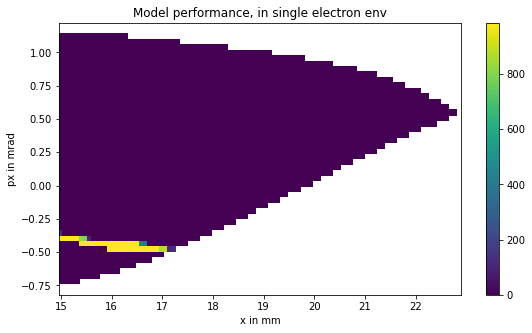

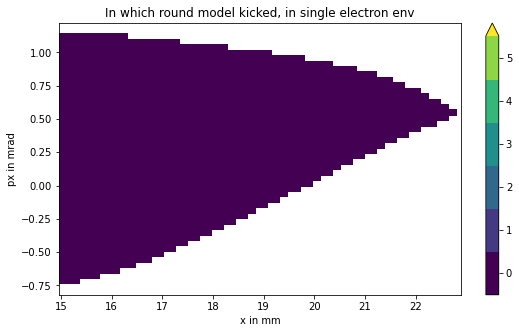

---------------------
466
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 845.1441909429126


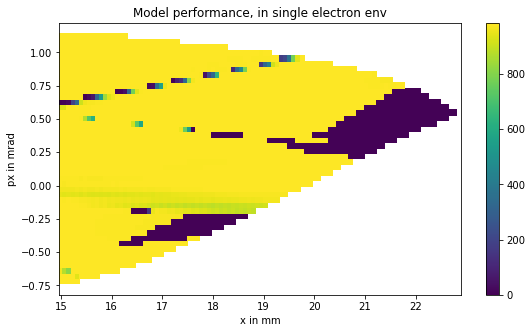

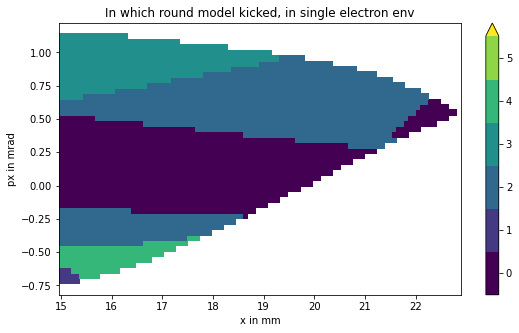

---------------------
467
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 820.9953780631674


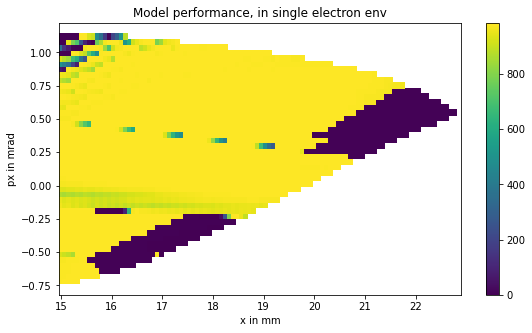

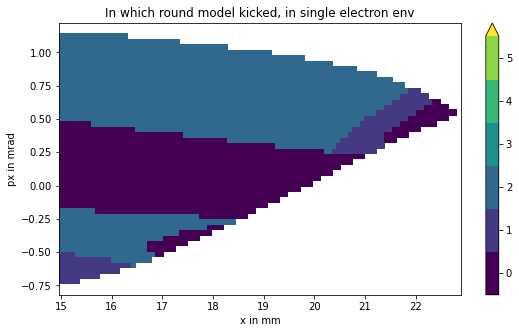

---------------------
468
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 804.8416708902275


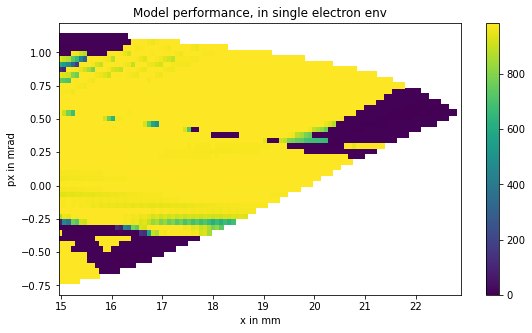

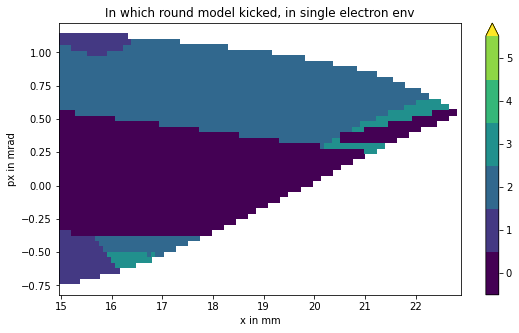

---------------------
469
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 0.3608058608058608


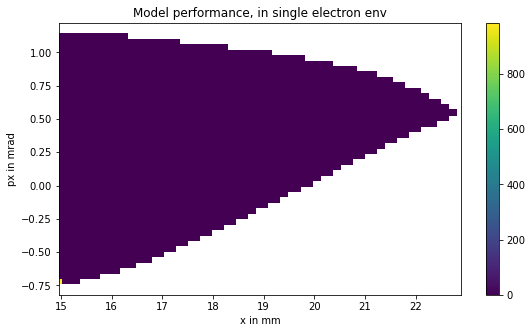

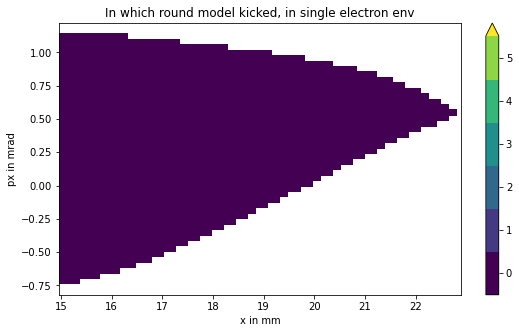

---------------------
470
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 757.5328389759088


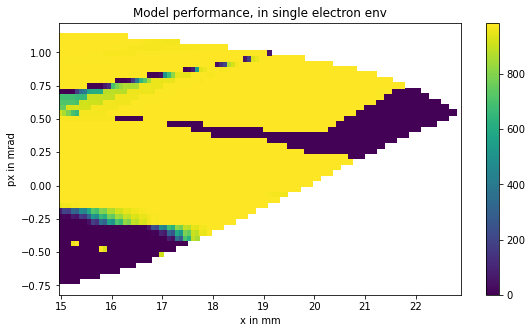

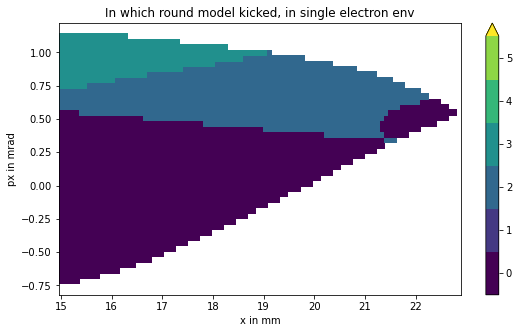

---------------------
471
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 752.2354408885337


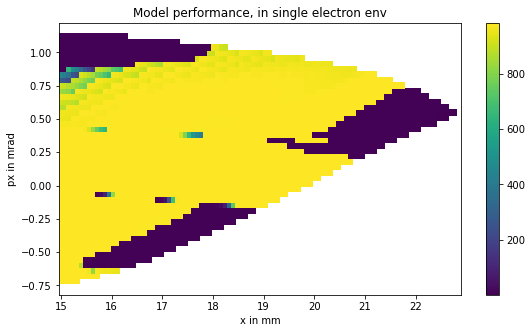

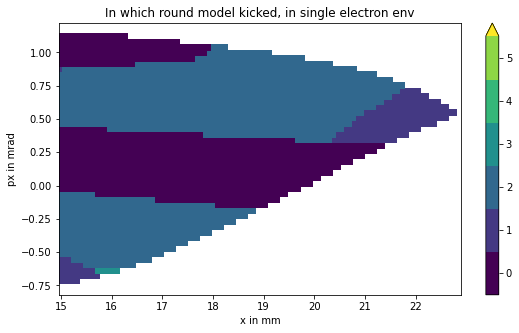

---------------------
472
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 772.0078411373718


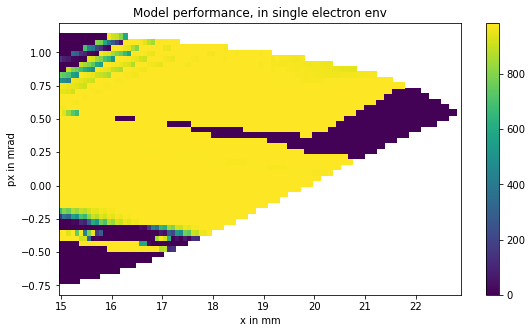

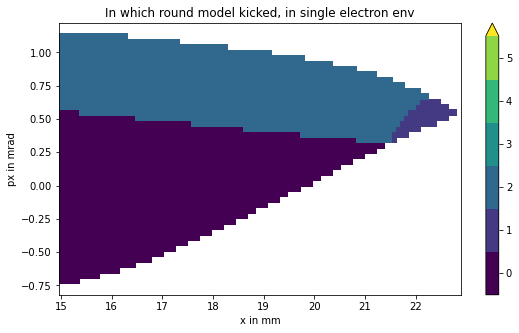

---------------------
473
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 782.0718141151348


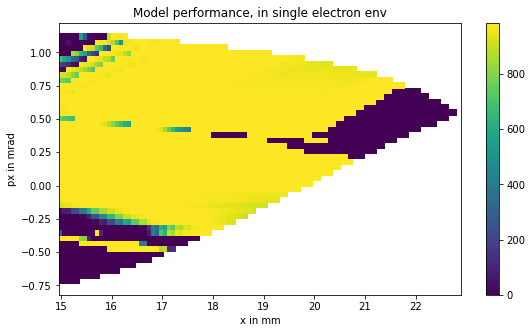

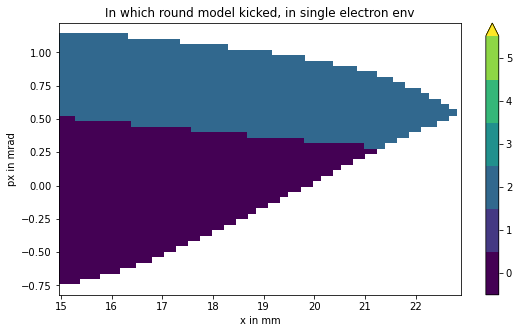

---------------------
474
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 402.9859095399551


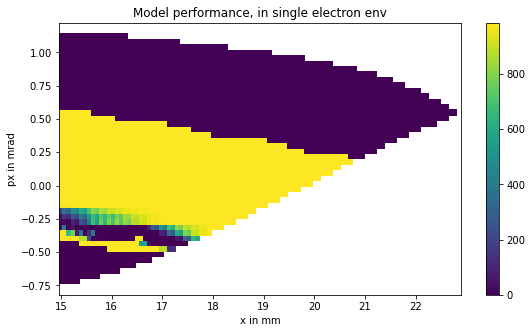

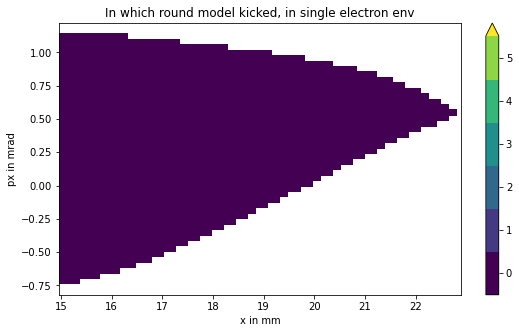

---------------------
475
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


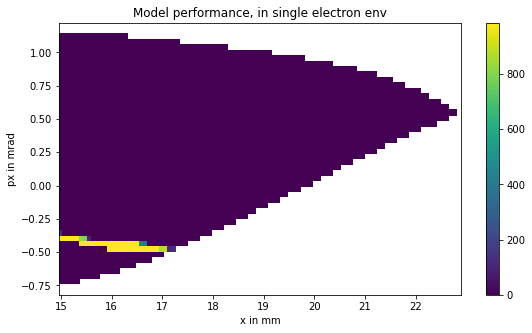

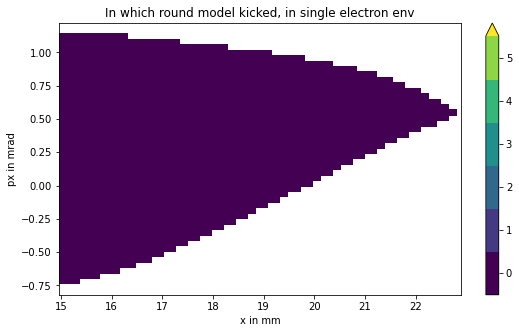

---------------------
476
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 397.86882192025905


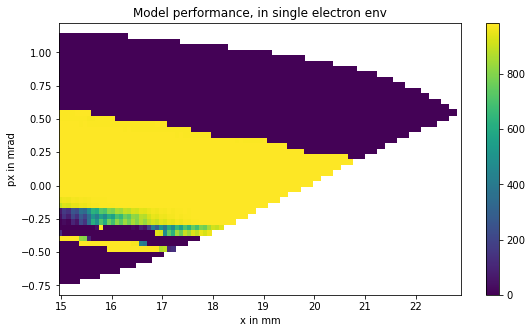

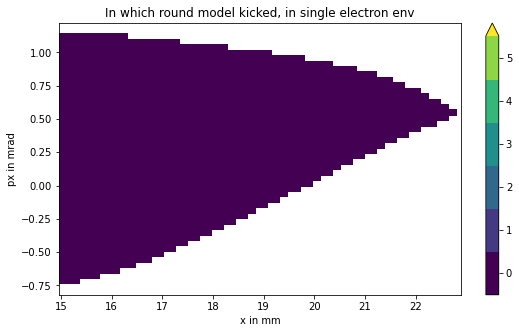

---------------------
477
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 785.7020497641496


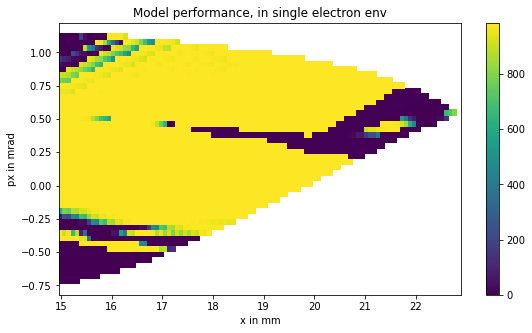

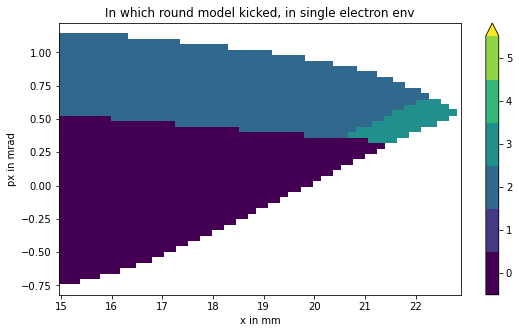

---------------------
478
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


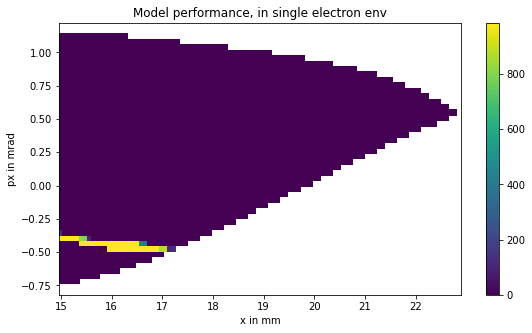

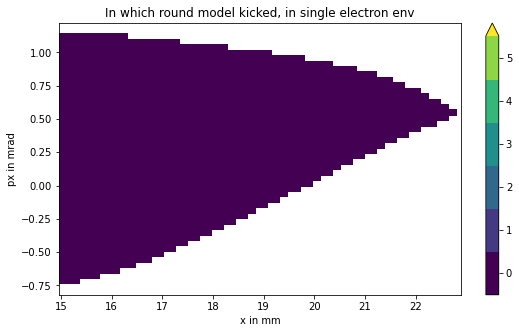

---------------------
479
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 809.2366346174732


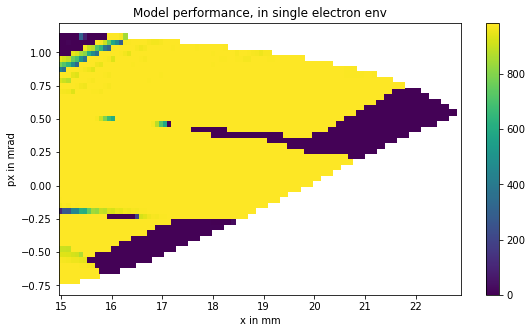

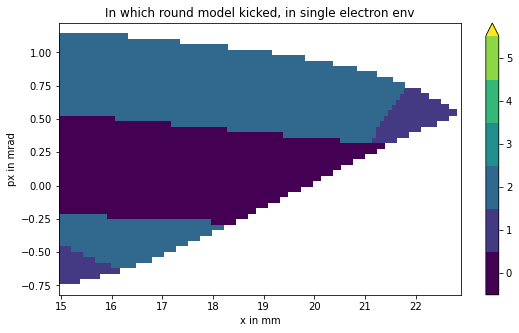

---------------------
480
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 727.6739636903644


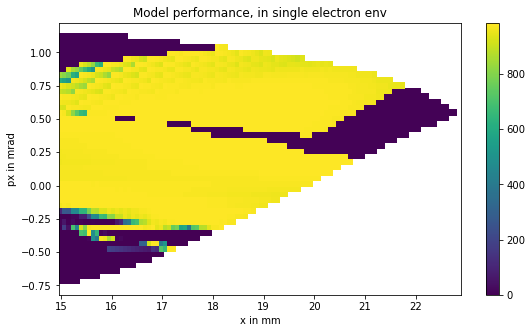

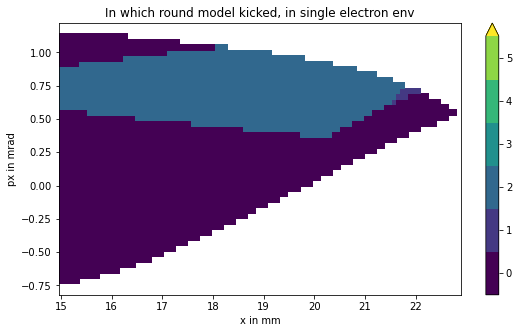

---------------------
481
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 775.983585986587


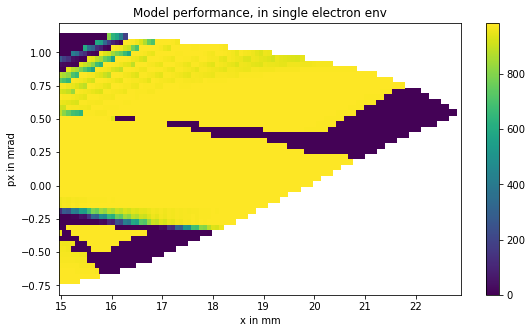

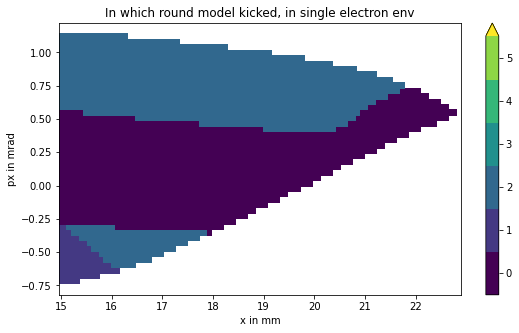

---------------------
482
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


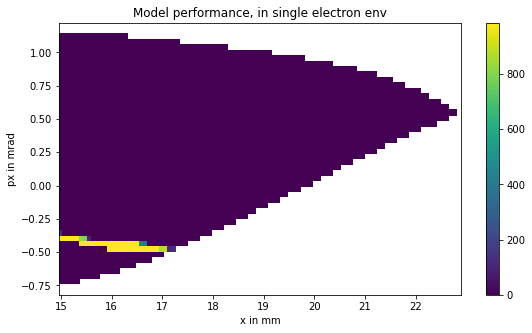

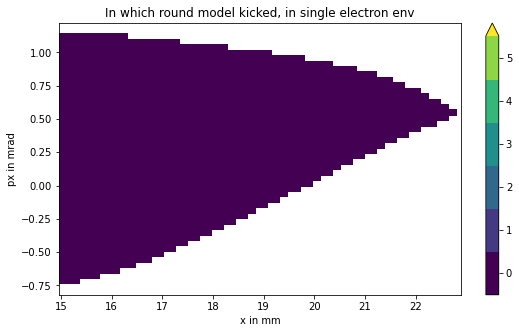

---------------------
483
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 403.40294586448624


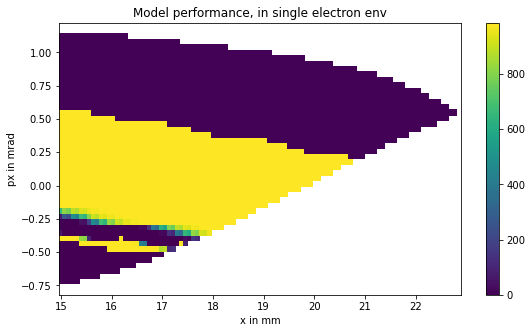

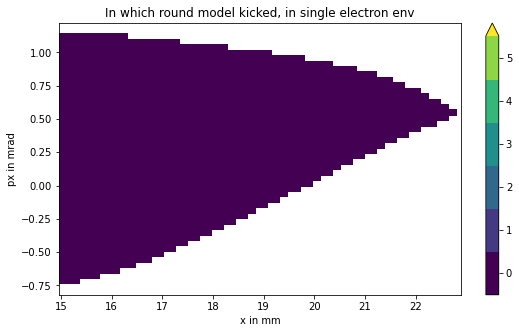

---------------------
484
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 718.515256568208


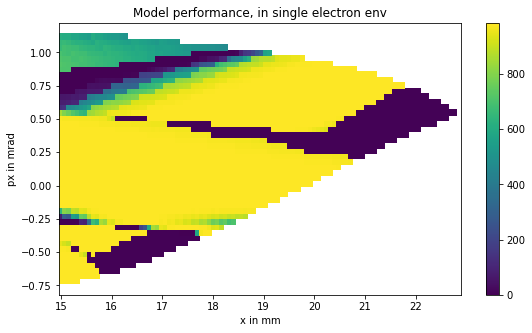

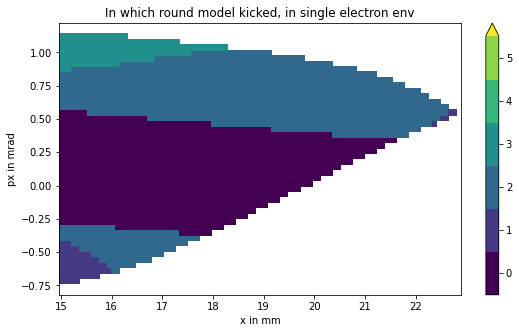

---------------------
485
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 731.933816377311


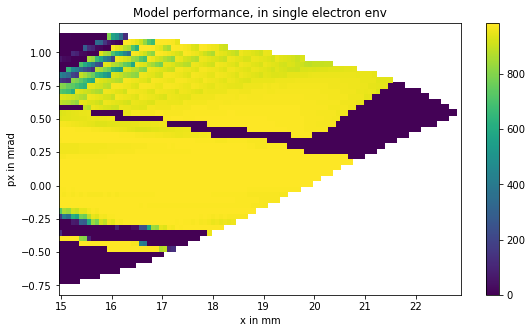

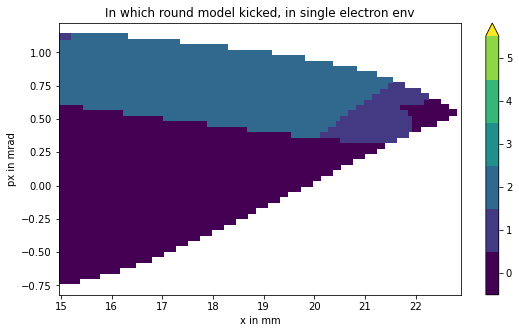

---------------------
486
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 764.2014323417441


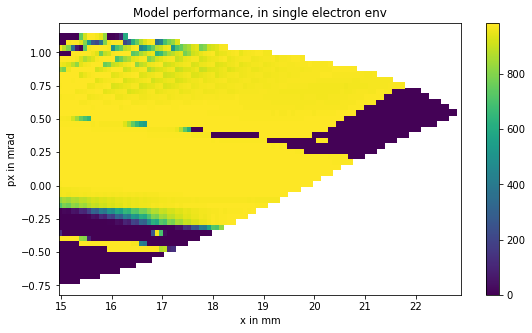

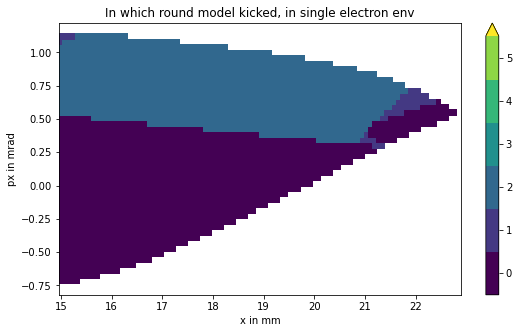

---------------------
487
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


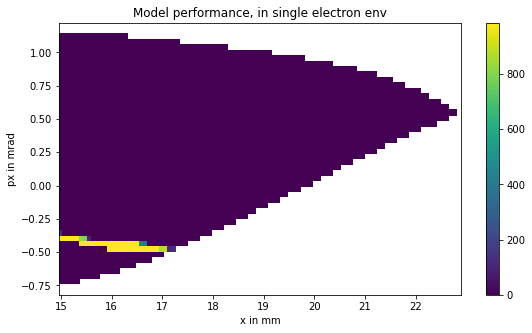

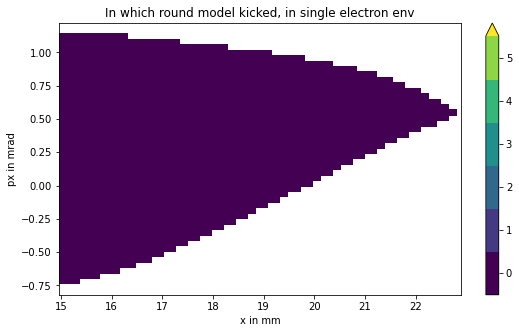

---------------------
488
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 774.7625928878157


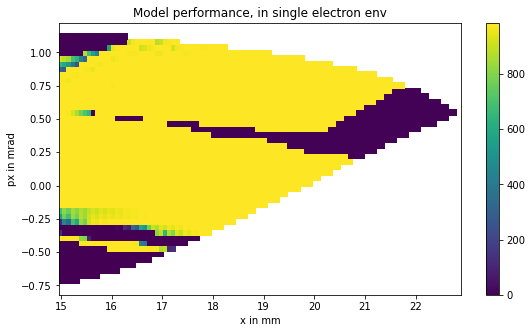

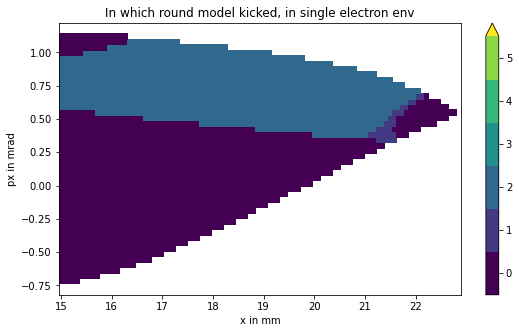

---------------------
489
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 779.4564200785746


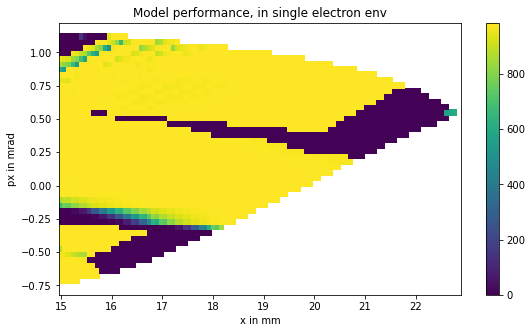

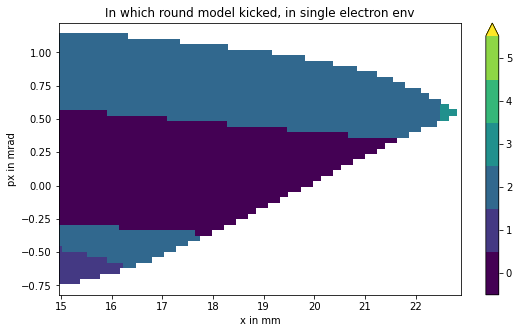

---------------------
490
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 795.6108548816619


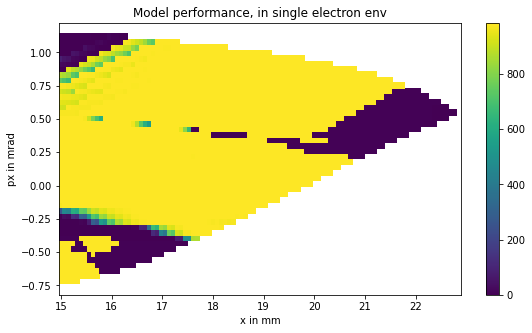

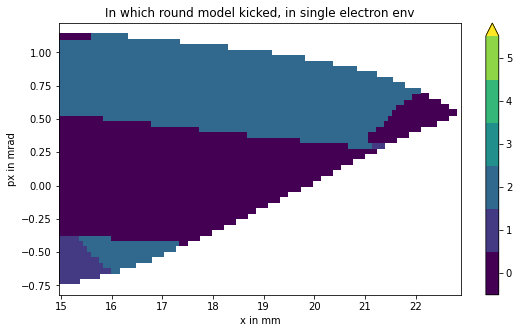

---------------------
491
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 814.8677781306103


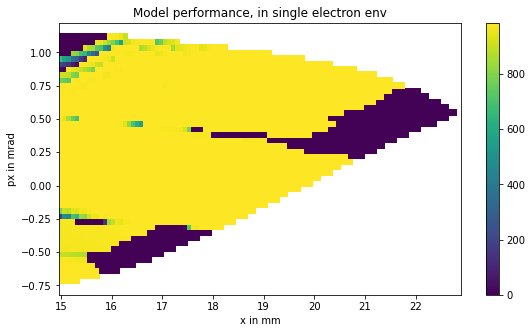

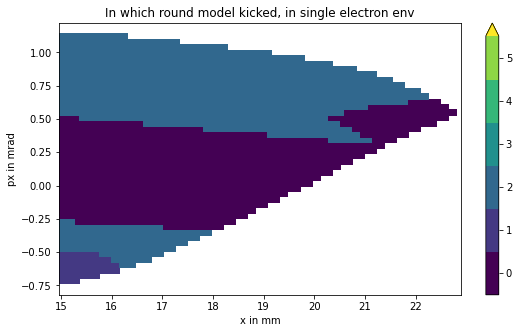

---------------------
492
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 619.3666364837347


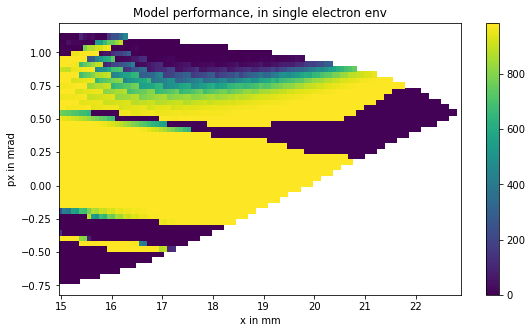

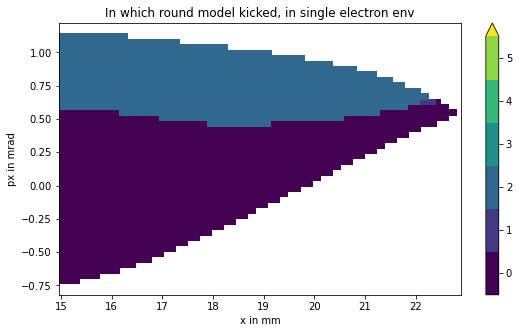

---------------------
493
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 778.9222671977916


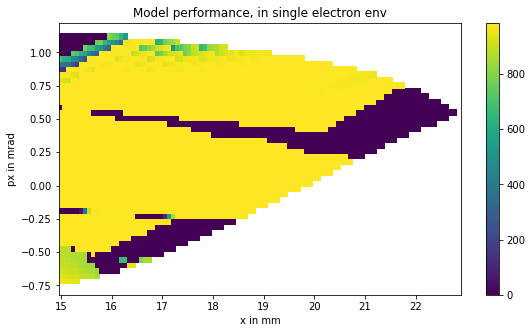

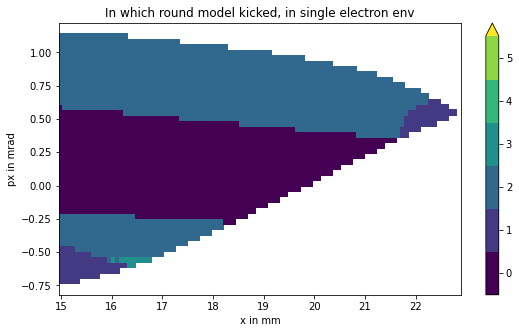

---------------------
494
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 391.98539205974475


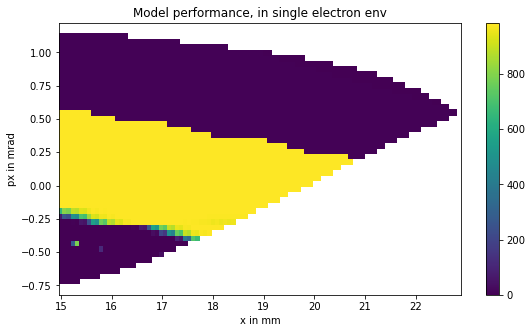

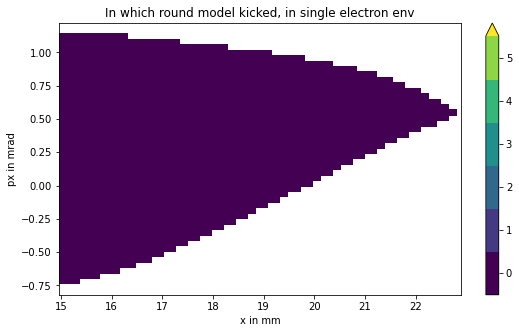

---------------------
495
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


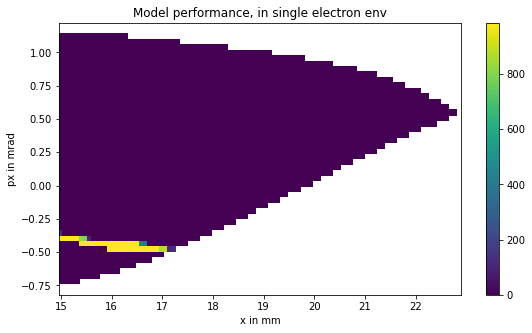

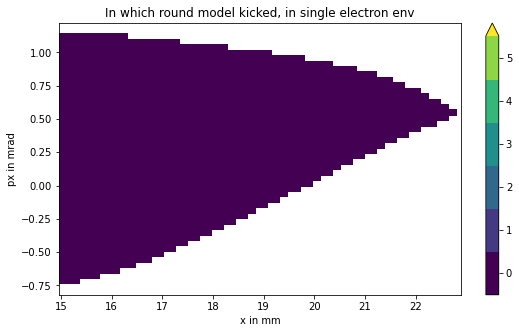

---------------------
496
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 854.7690352943453


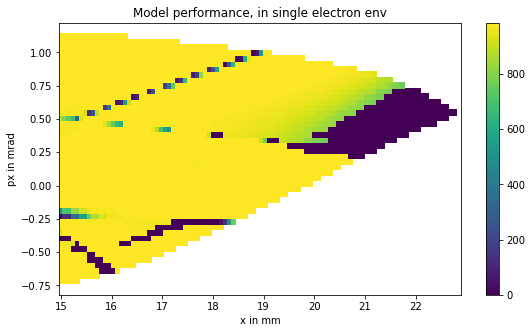

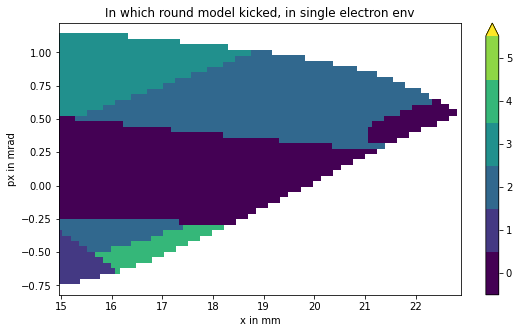

---------------------
497
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 733.9466391442688


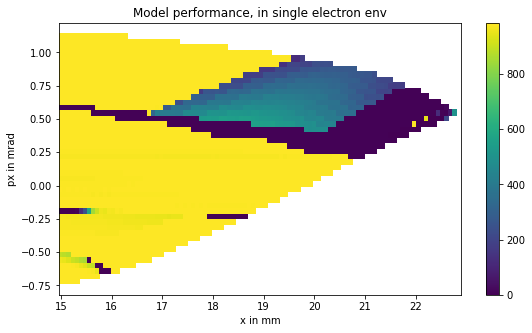

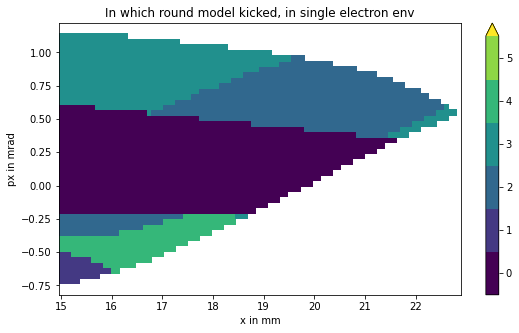

---------------------
498
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 404.3024241734413


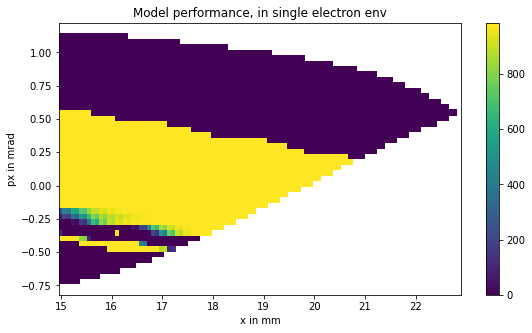

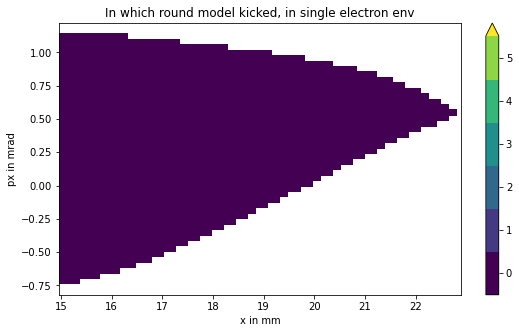

---------------------
499
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 713.8879595215968


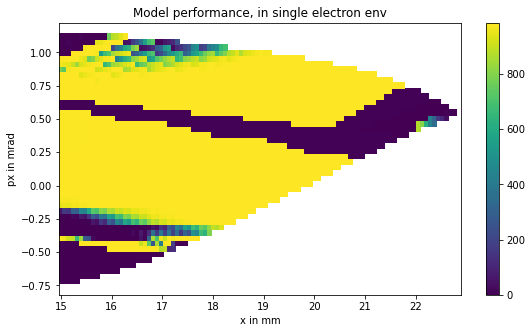

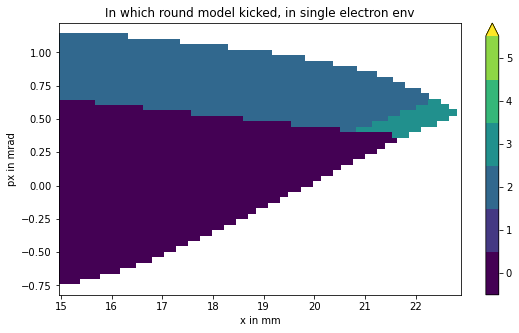

---------------------
500
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 782.0967518715198


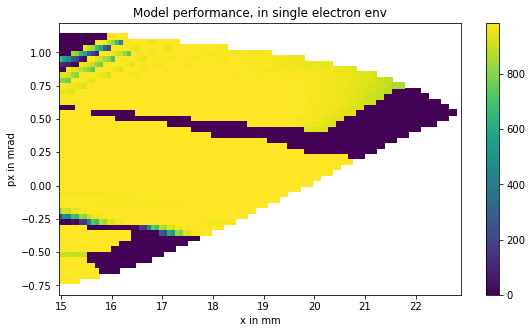

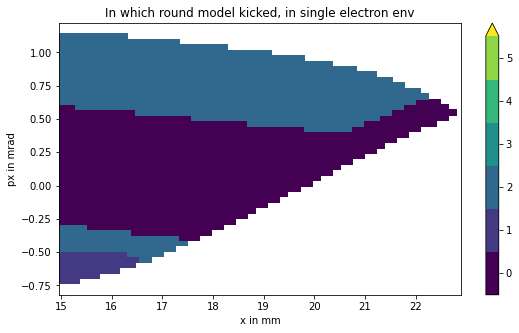

---------------------
501
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 781.4298962996745


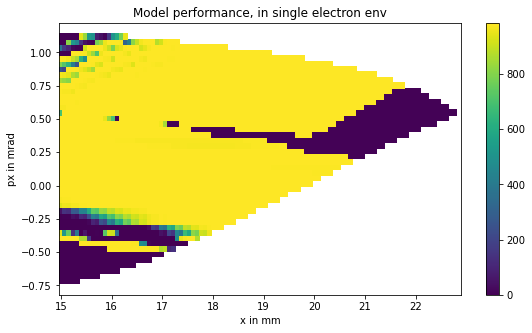

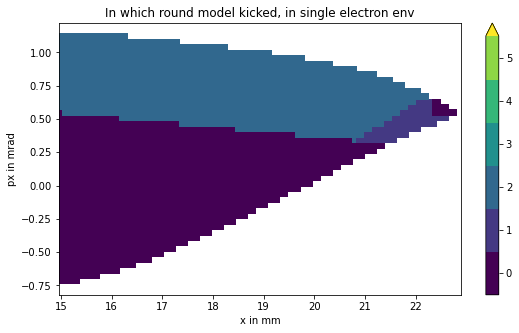

---------------------
502
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 767.4168194847924


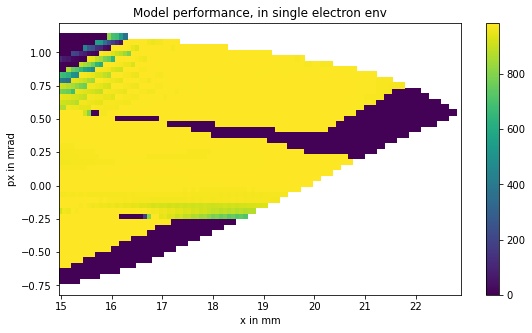

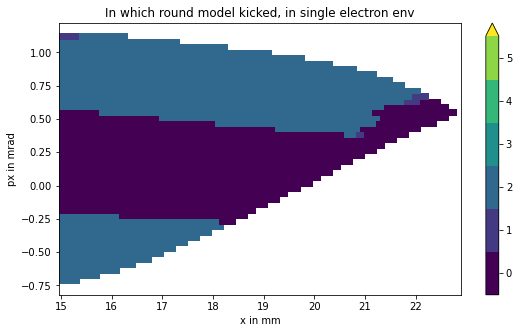

---------------------
503
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 0.3608058608058608


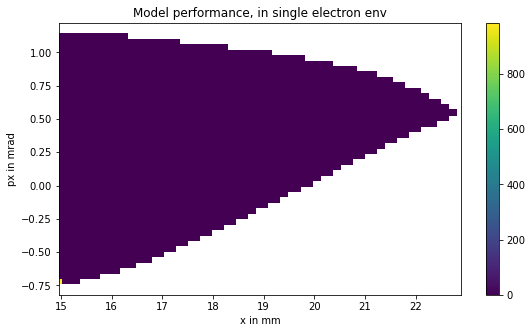

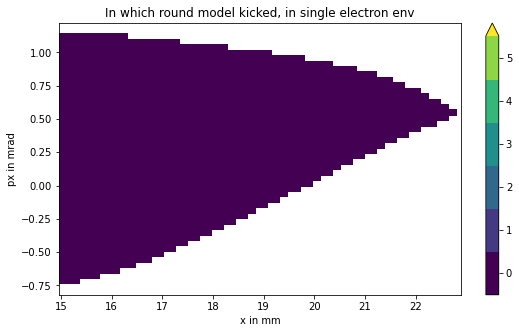

---------------------
504
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 721.7906049087222


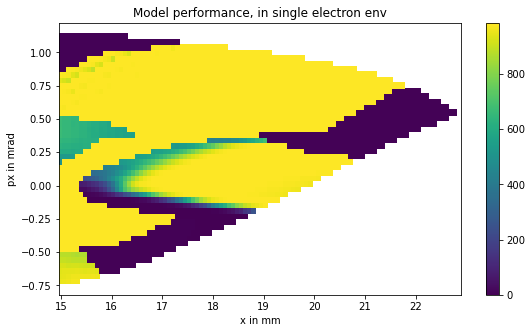

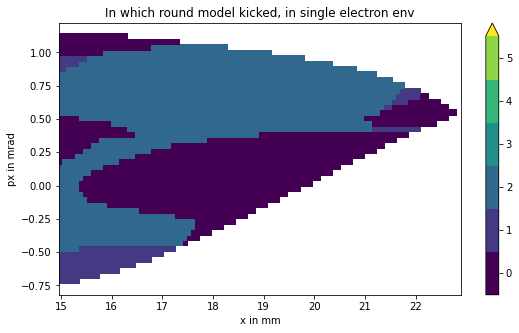

---------------------
505
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 772.0759340836905


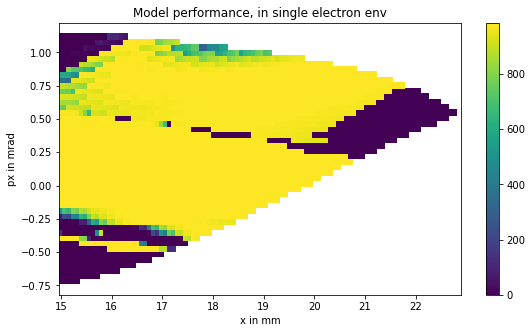

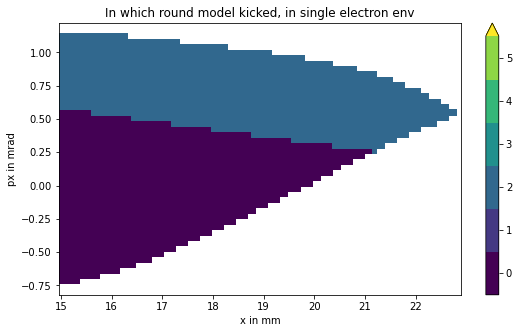

---------------------
506
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 402.02202024528725


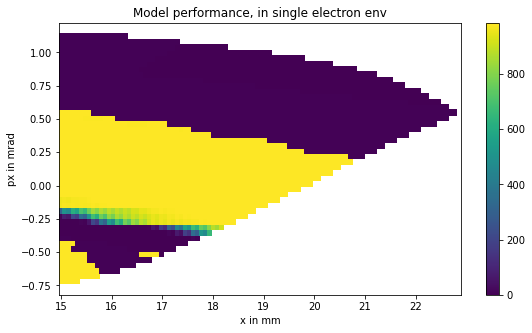

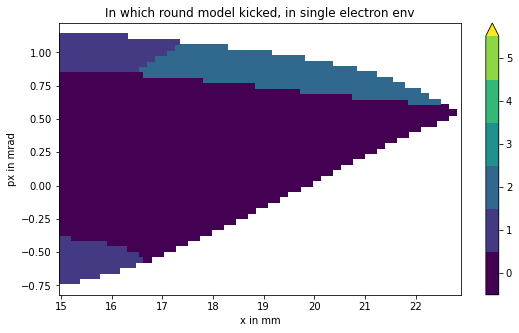

---------------------
507
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


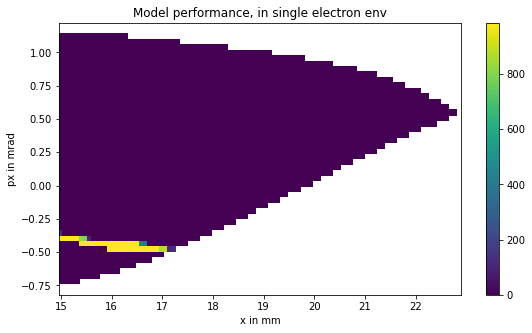

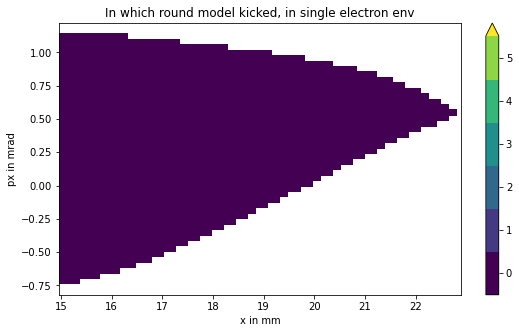

---------------------
508
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 760.1660854314332


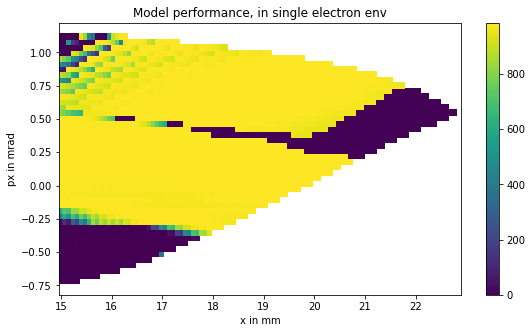

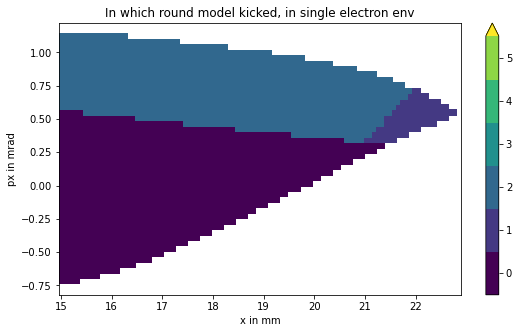

---------------------
509
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 736.149302535402


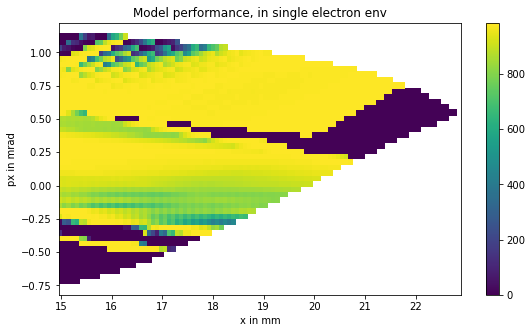

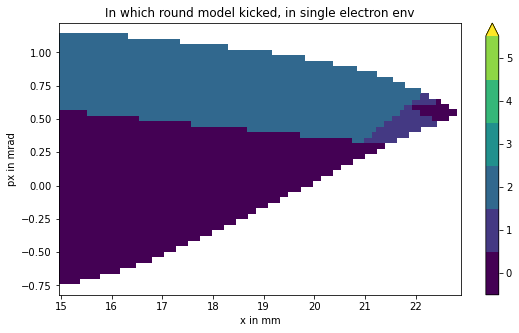

---------------------
510
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 774.7974759379376


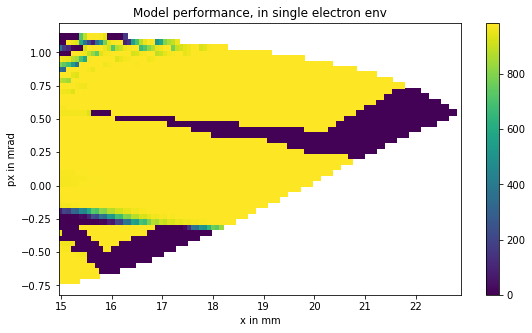

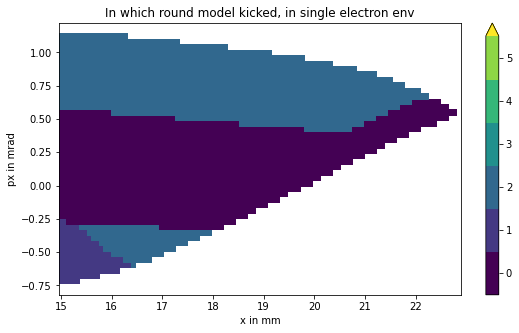

---------------------
511
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 815.2479083842782


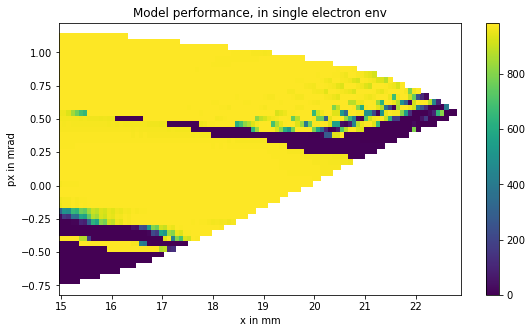

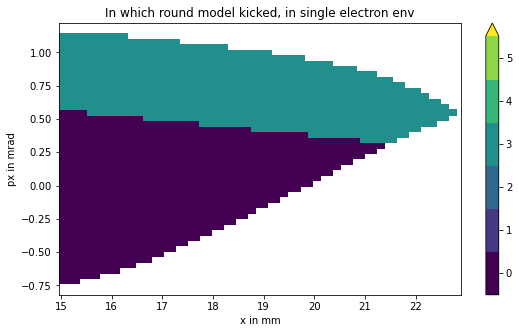

---------------------
512
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value: 13.606833332385385


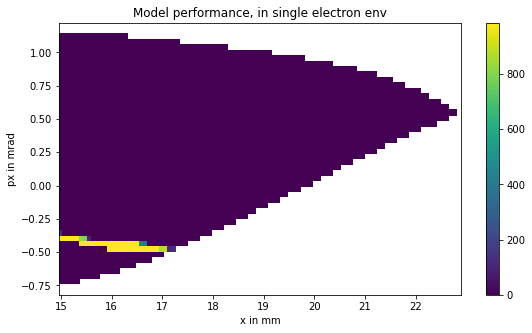

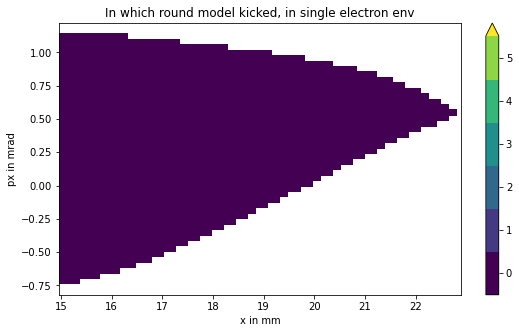

---------------------
513
---------------------
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/al3xber/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-816cc82488d4>", line 5, in <module>
    model = train(batch_size=64,learning_rate=0.002722,noise_std=0.377,
  File "<ipython-input-9-e4deb299e8b7>", line 23, in train
    model.learn(total_timesteps=2000, log_interval=3000)
  File "/home/al3xber/anaconda3/lib/python3.8/site-packages/stable_baselines3/td3/td3.py", line 222, in learn
    return super().learn(
  File "/home/al3xber/anaconda3/lib/python3.8/site-packages/stable_baselines3/common/off_policy_algorithm.py", line 331, in learn
    self.train(batch_size=self.batch_size, gradient_steps=gradient_steps)
  File "/home/al3xber/anaconda3/lib/python3.8/site-packages/stable_baselines3/td3/td3.py", line 202, in train
    polyak_update(self.critic.parameters(), self.critic_target.parameters(), self.tau)
  File

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/al3xber/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-816cc82488d4>", line 5, in <module>
    model = train(batch_size=64,learning_rate=0.002722,noise_std=0.377,
  File "<ipython-input-9-e4deb299e8b7>", line 23, in train
    model.learn(total_timesteps=2000, log_interval=3000)
  File "/home/al3xber/anaconda3/lib/python3.8/site-packages/stable_baselines3/td3/td3.py", line 222, in learn
    return super().learn(
  File "/home/al3xber/anaconda3/lib/python3.8/site-packages/stable_baselines3/common/off_policy_algorithm.py", line 331, in learn
    self.train(batch_size=self.batch_size, gradient_steps=gradient_steps)
  File "/home/al3xber/anaconda3/lib/python3.8/site-packages/stable_baselines3/td3/td3.py", line 202, in train
    polyak_update(self.critic.parameters(), self.critic_target.parameters(), self.tau)
  File

In [ ]:
for i in range(400,600):
    print("---------------------")
    print(i)
    print("---------------------")
    model = train(batch_size=64,learning_rate=0.002722,noise_std=0.377,
                   size_pi=2,size_qf=5,gamma = 1.355,learning_starts=250, duration=5/60)

    
    value, Z, Z_round = performance_test(model, deterministic = True)
    print("Value:",value)
    if value>860:
        model.save(f"models/TD3/best1_1000step_number{i}")  
    show_plots(Z, Z_round)

## Hyper parameter search

In [8]:
def worker(space):
    env = gym.make('NLK_Env-v0',reward_design_1= 11,
                   reward_design_2= 7)   #we had these rewards from other hyperparameter searches
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), 
                                                sigma=space["noise_std"]*np.ones(n_actions))
    
    pi_NN = space["piNN"]
    qf_NN = space["qfNN"]
    
    policy_kwargs = dict(net_arch=dict(pi=pi_NN, qf=qf_NN))
    
    
    
    model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1, 
                learning_rate=space["learning_rate"],batch_size=64, 
                gamma=space["gamma"],learning_starts = 250, 
                policy_kwargs=policy_kwargs)
    
    
    a = time.time()
    
    while time.time()-a<60*5:#5 minutes
        model.learn(total_timesteps=400, log_interval=500)
    print("training done")
    value, Z, Z_round = performance_test(model)
    print(value)
    show_plots(Z, Z_round)
    
    return value


def objective(space):
    values = []
    for runde_worker in range(3):
        #each hyperparameter we train 6 times, to minimise variance
        with Pool(3) as p:
            #2 at the same time here
            werte = p.map(worker,[space,space])
        values += werte

        if np.mean(values) < (runde_worker+1)*50: #break earlier, in case performance is very bad
            print("BREAK",np.mean(values),(runde_worker+1)*50)
            break
                
            
    
    accuracy = np.mean(values)/1000    #value
    
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'action_info': {'performances': values},
            'status': STATUS_OK }
    


In [9]:
# from https://github.com/hyperopt/hyperopt/issues/267
import pickle
import os 
file_name = "NLK_final_model_single_2.hyperopt"

def run_trials():

    trials_step = 1  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 1  # initial max_trials. put something small to not have to wait
    
    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open(file_name, "rb"))
        print("Found saved Trials! Loading...")
        
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        print("Creating new Trial")
        trials = Trials()

    best = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = max_trials,
            trials = trials)

    print("Run:", best)

    #print(trials.trials)
    with open(file_name, "wb") as f:
        pickle.dump(trials, f)

Creating new Trial
Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
876.3974306880402                                    
  0%|          | 0/1 [05:06<?, ?trial/s, best loss=?]

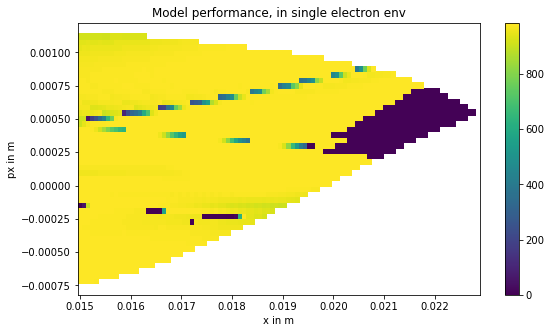

769.6103728994946                                    
  0%|          | 0/1 [05:06<?, ?trial/s, best loss=?]

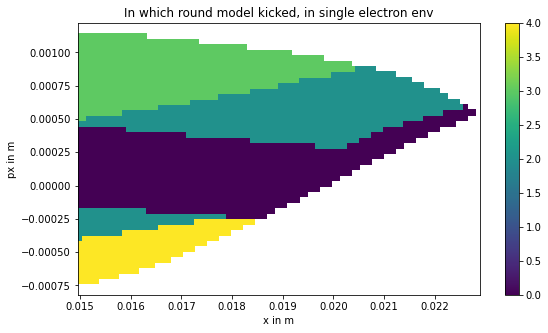

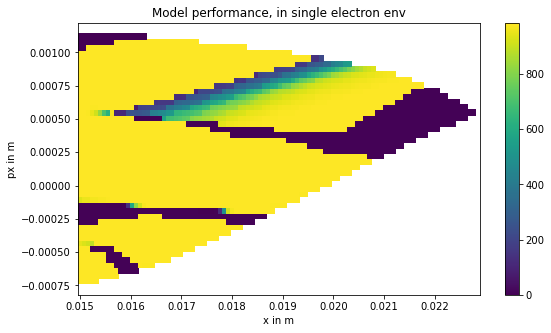

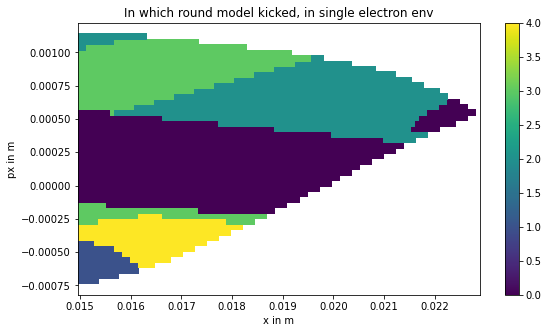

Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
780.0157647603245                                    
  0%|          | 0/1 [10:12<?, ?trial/s, best loss=?]

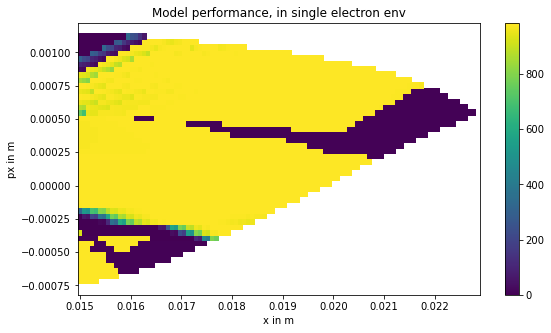

799.6020100285381                                    
  0%|          | 0/1 [10:12<?, ?trial/s, best loss=?]

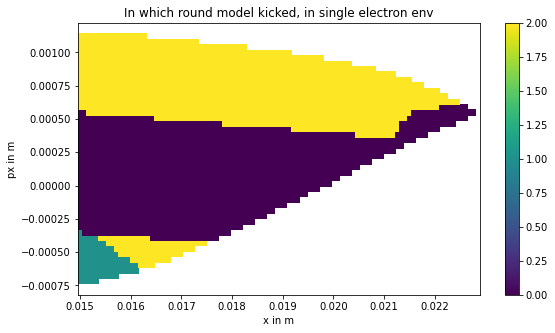

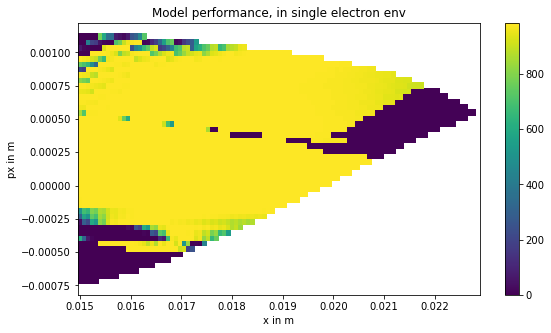

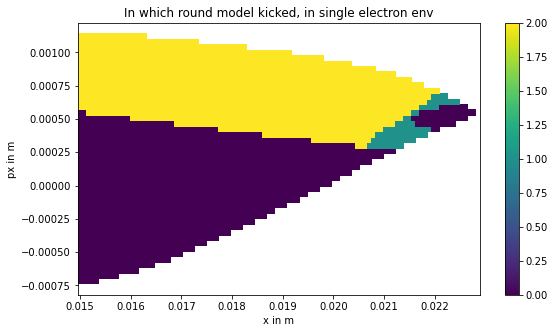

Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
740.8665804090192                                    
  0%|          | 0/1 [15:18<?, ?trial/s, best loss=?]

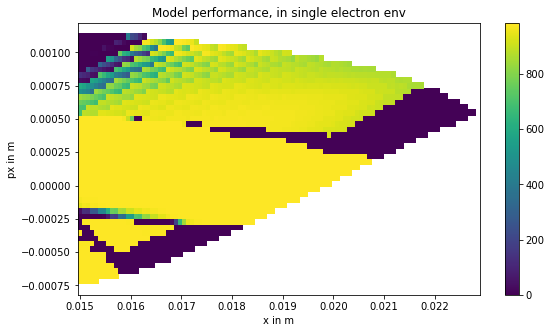

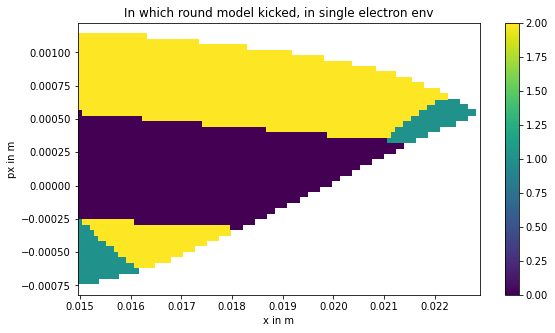

873.8257646784574                                    
  0%|          | 0/1 [15:20<?, ?trial/s, best loss=?]

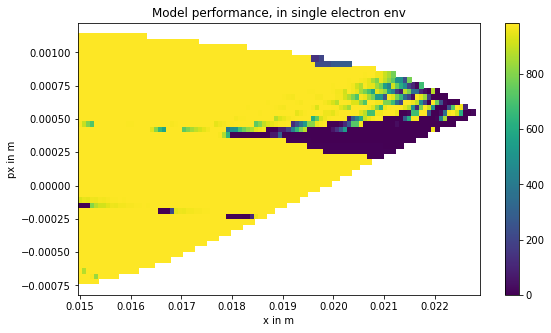

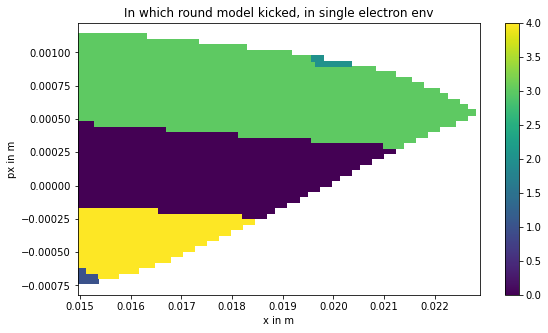

100%|██████████| 1/1 [15:20<00:00, 920.77s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 1 trials to 2 (+1) trials
Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
679.7108591715867                                    
 50%|█████     | 1/2 [05:05<?, ?trial/s, best loss=?]

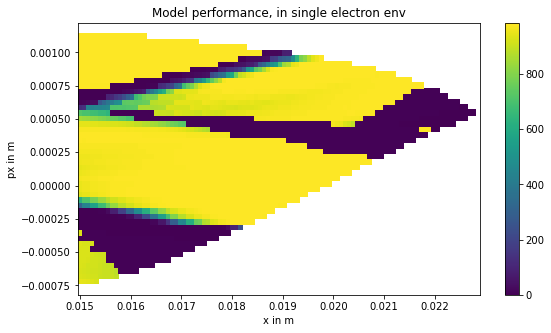

693.9097161138984                                    
 50%|█████     | 1/2 [05:05<?, ?trial/s, best loss=?]

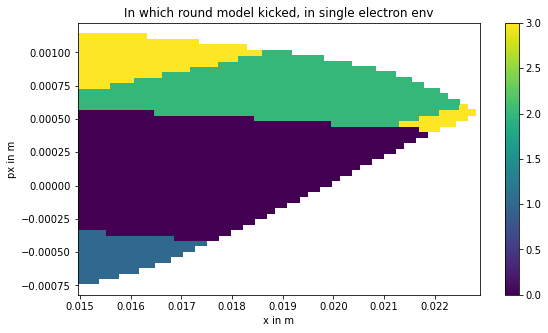

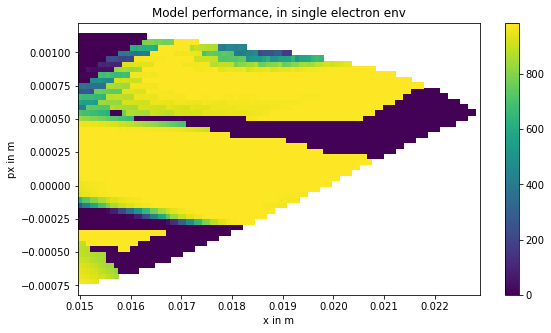

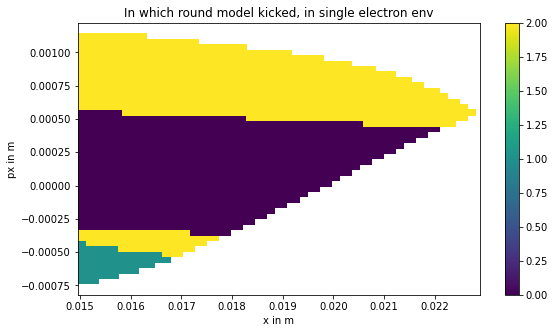

Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
685.3820211047256                                    
694.767351942425                                     
 50%|█████     | 1/2 [10:11<?, ?trial/s, best loss=?]

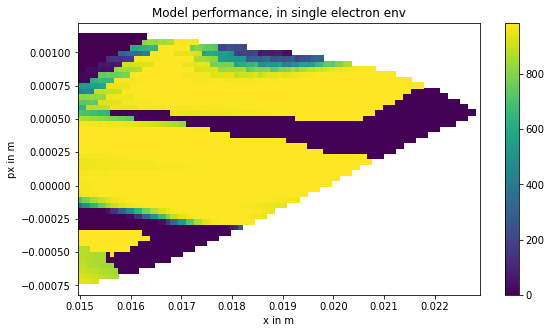

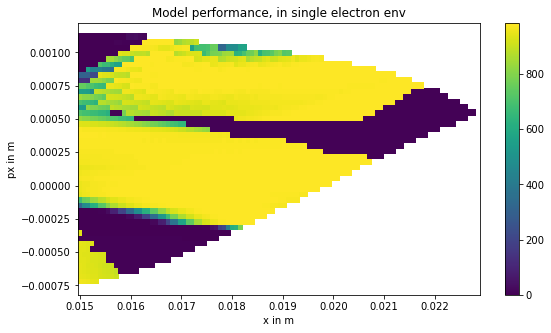

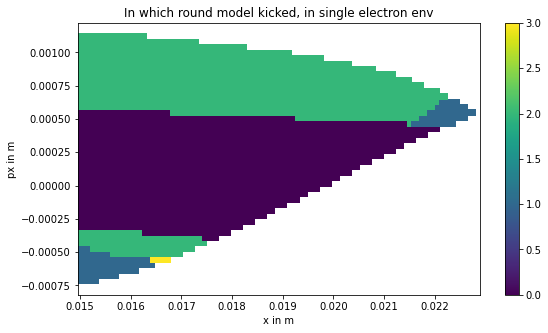

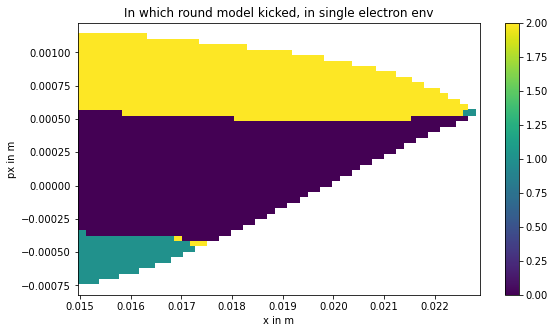

Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
667.5409730459219                                    
 50%|█████     | 1/2 [15:16<?, ?trial/s, best loss=?]

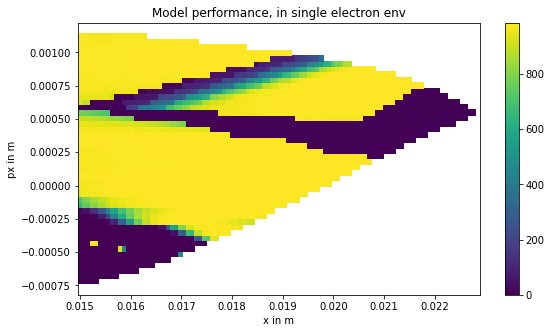

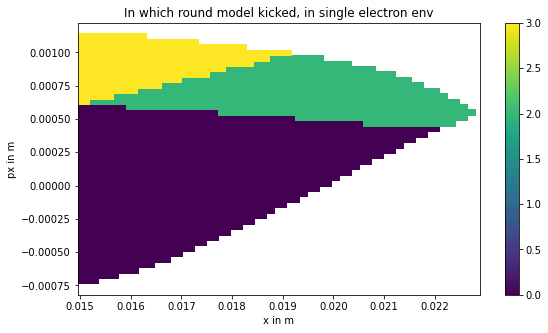

716.3749659349062                                    
 50%|█████     | 1/2 [15:17<?, ?trial/s, best loss=?]

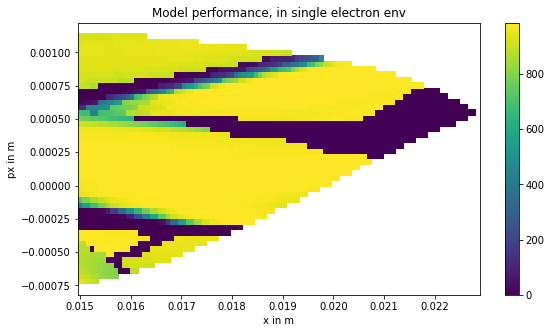

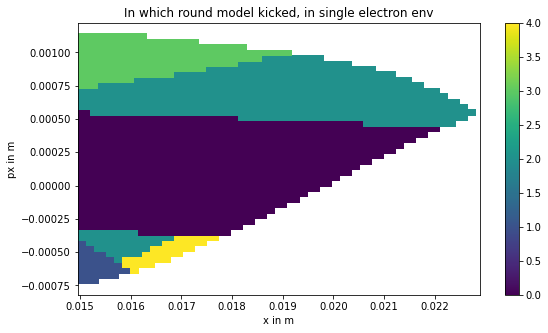

100%|██████████| 2/2 [15:17<00:00, 917.70s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 2 trials to 3 (+1) trials
Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
392.3776434955266                                    
 67%|██████▋   | 2/3 [05:02<?, ?trial/s, best loss=?]

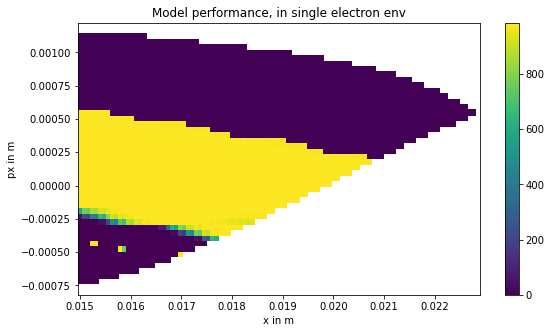

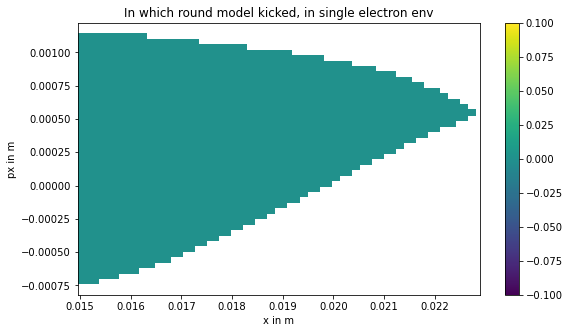

384.4227407606941                                    
 67%|██████▋   | 2/3 [05:03<?, ?trial/s, best loss=?]

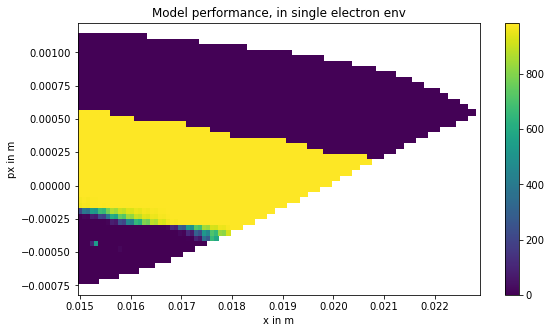

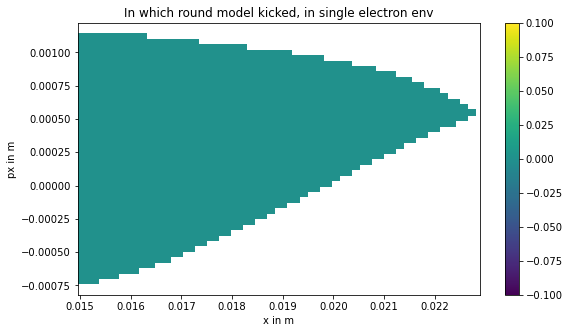

Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
398.8385436985579                                    
 67%|██████▋   | 2/3 [10:07<?, ?trial/s, best loss=?]

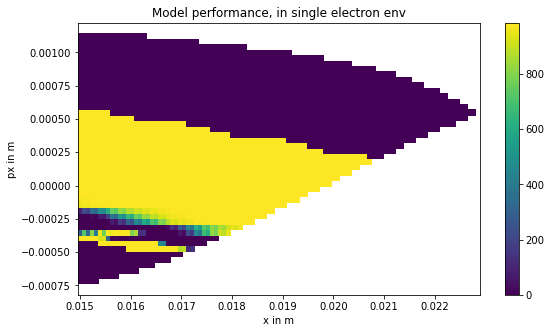

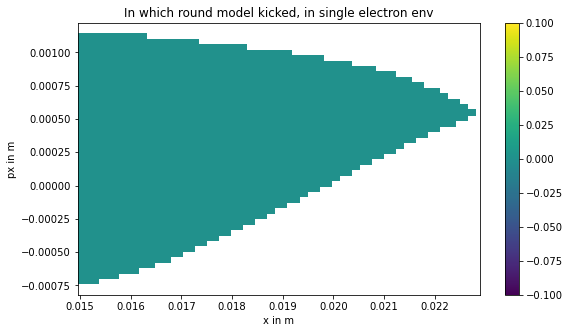

387.0481537510046                                    
 67%|██████▋   | 2/3 [10:07<?, ?trial/s, best loss=?]

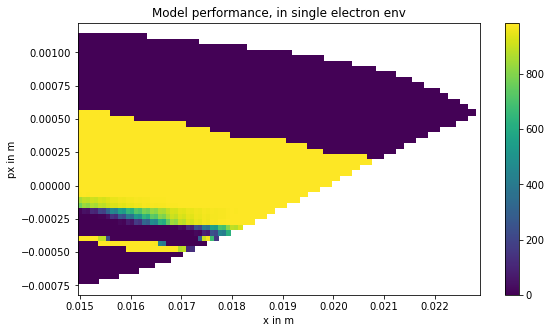

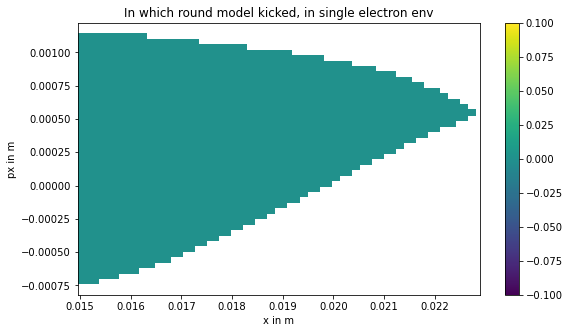

Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
402.93615424671293                                   
 67%|██████▋   | 2/3 [15:10<?, ?trial/s, best loss=?]

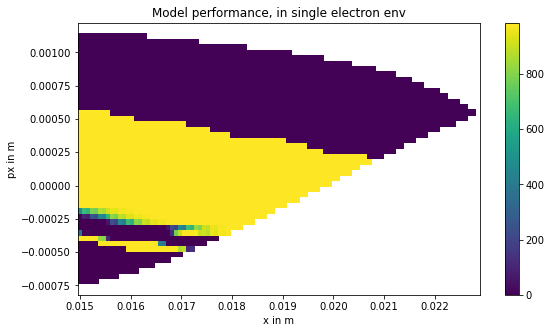

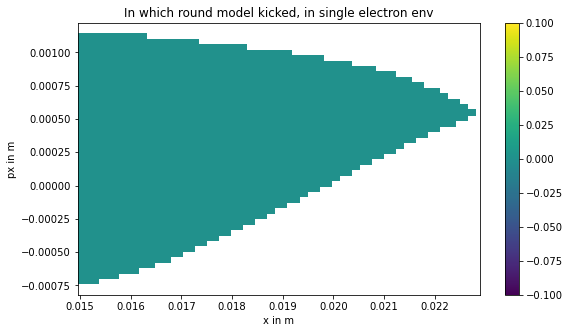

401.0992920818656                                    
 67%|██████▋   | 2/3 [15:11<?, ?trial/s, best loss=?]

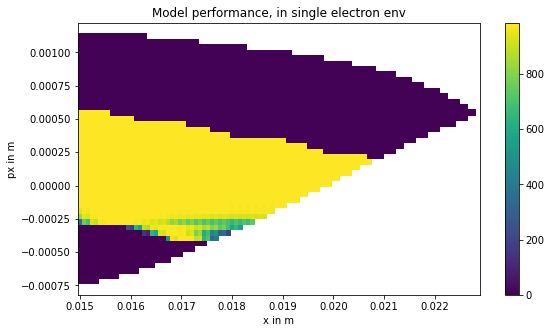

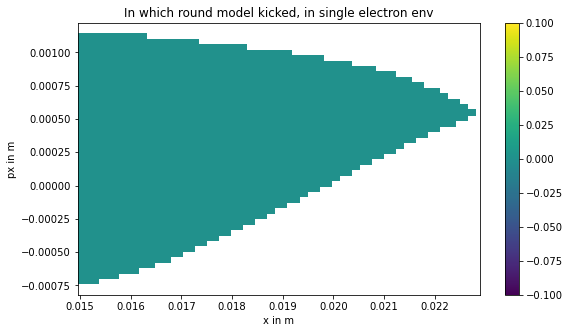

100%|██████████| 3/3 [15:11<00:00, 911.78s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 3 trials to 4 (+1) trials
Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
0.3608063620959787                                   
 75%|███████▌  | 3/4 [05:04<?, ?trial/s, best loss=?]

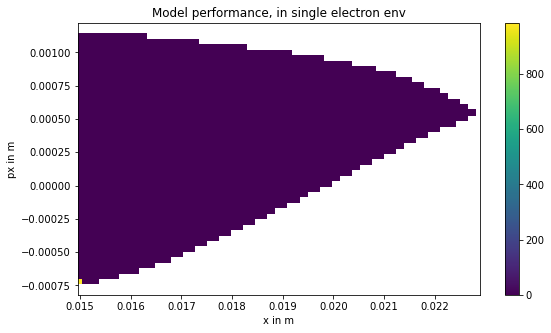

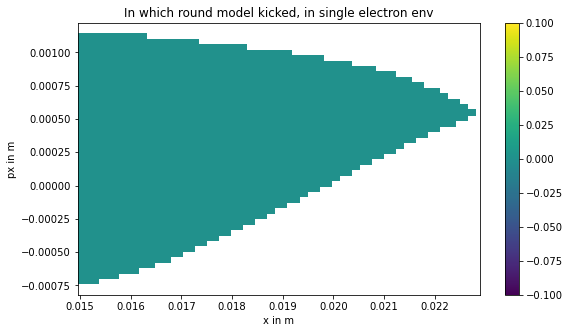

668.7824245451786                                    
 75%|███████▌  | 3/4 [05:08<?, ?trial/s, best loss=?]

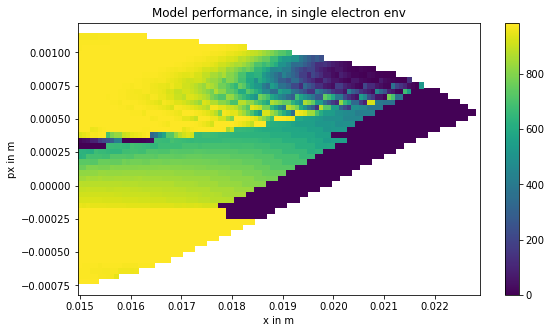

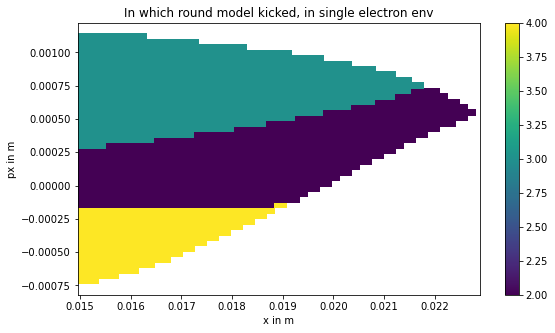

Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
13.606833332385385                                   
 75%|███████▌  | 3/4 [10:12<?, ?trial/s, best loss=?]

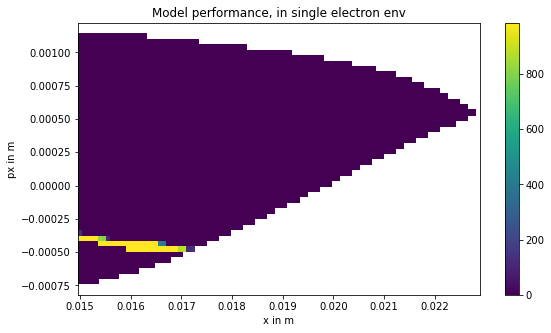

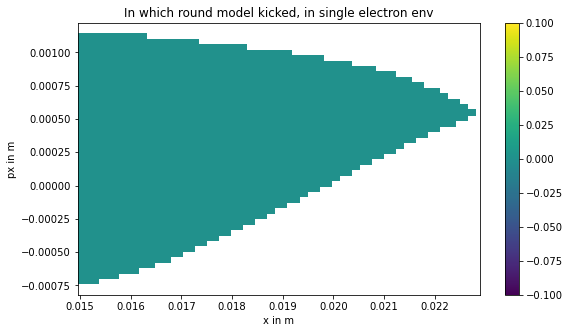

742.1280286649019                                    
 75%|███████▌  | 3/4 [10:14<?, ?trial/s, best loss=?]

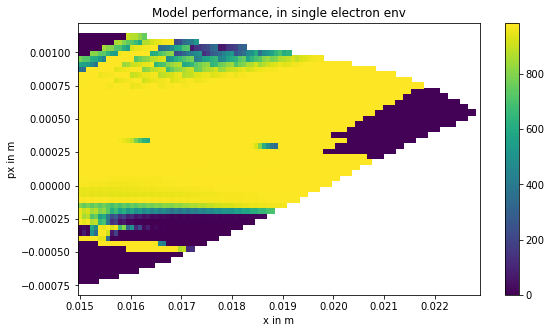

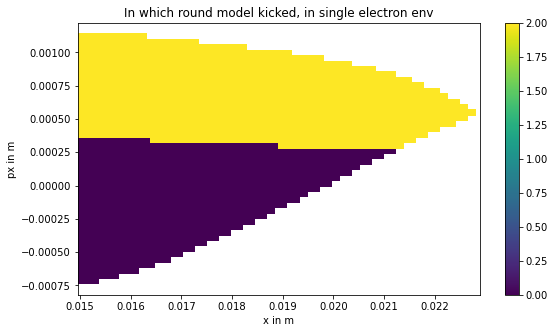

Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
13.606833332385385                                   
 75%|███████▌  | 3/4 [15:18<?, ?trial/s, best loss=?]

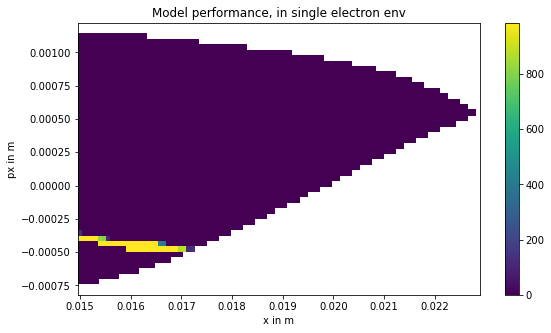

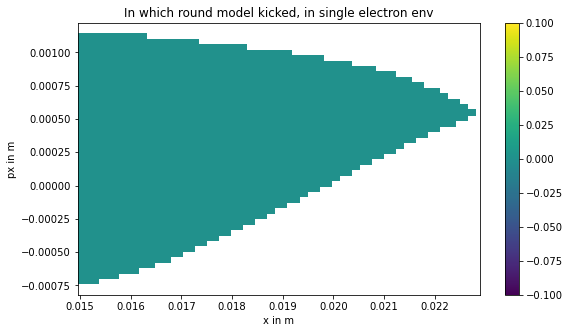

780.1175944280182                                    
 75%|███████▌  | 3/4 [15:20<?, ?trial/s, best loss=?]

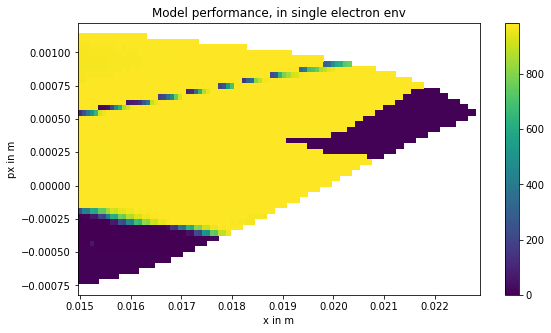

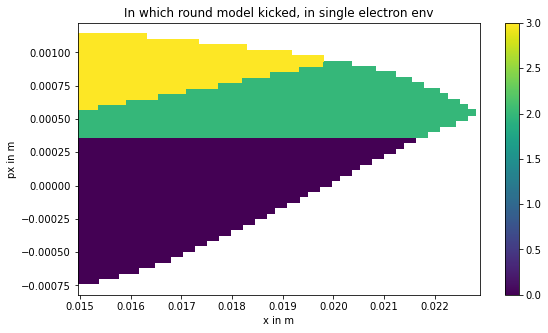

100%|██████████| 4/4 [15:21<00:00, 921.46s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 4 trials to 5 (+1) trials
Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
461.2341647756062                                    
 80%|████████  | 4/5 [05:04<?, ?trial/s, best loss=?]

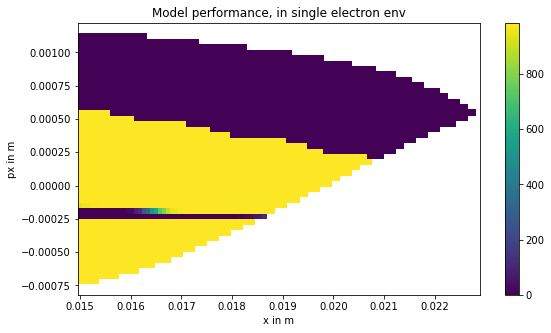

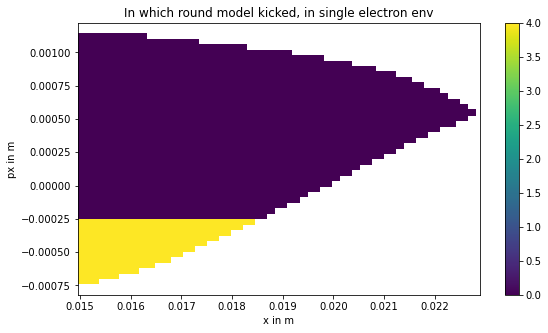

708.9092448749195                                    
 80%|████████  | 4/5 [05:05<?, ?trial/s, best loss=?]

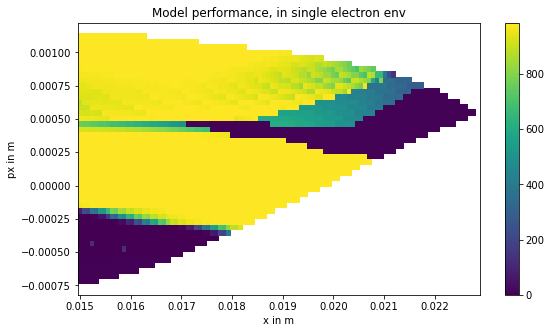

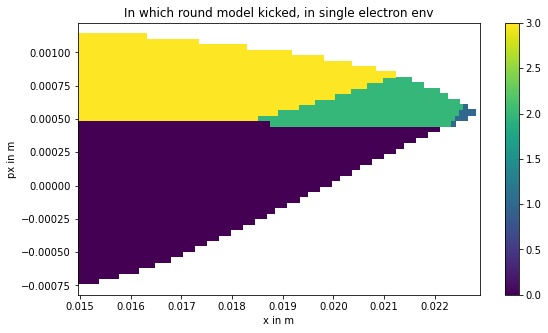

Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Using cuda device                                    
Wrapping the env in a DummyVecEnv.                   
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
396.96130831739293                                   
 80%|████████  | 4/5 [10:10<?, ?trial/s, best loss=?]

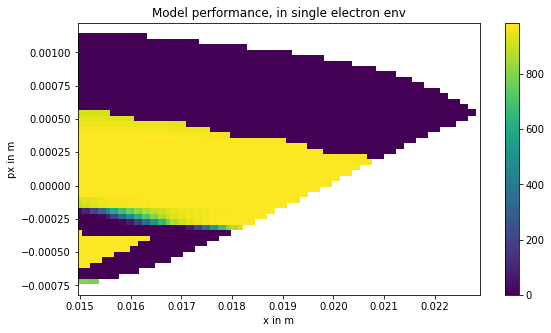

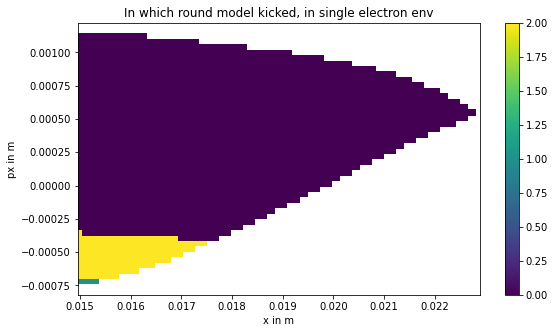

728.6236464255642                                    
 80%|████████  | 4/5 [10:11<?, ?trial/s, best loss=?]

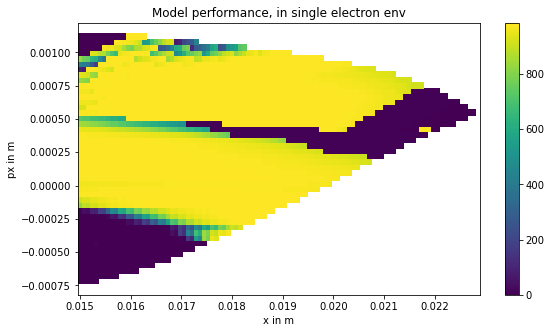

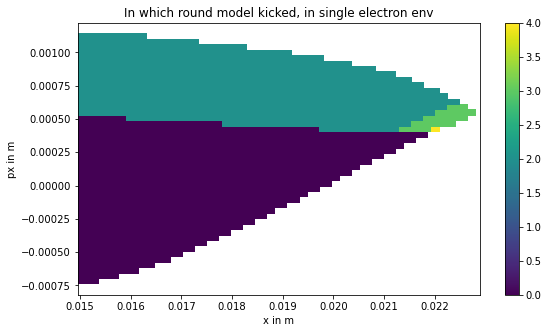

Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
384.45058502323786                                   
 80%|████████  | 4/5 [15:14<?, ?trial/s, best loss=?]

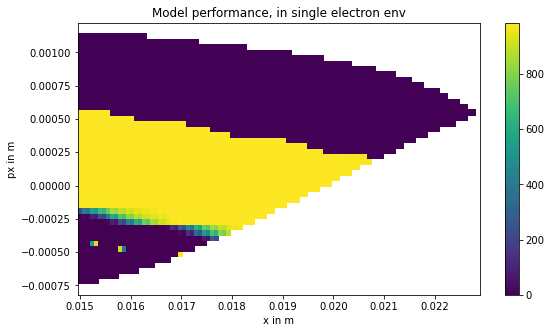

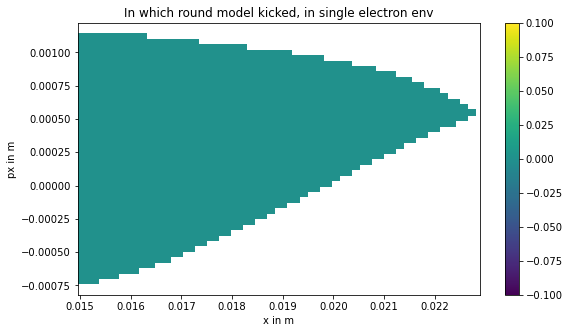

734.5381095950407                                    
 80%|████████  | 4/5 [15:17<?, ?trial/s, best loss=?]

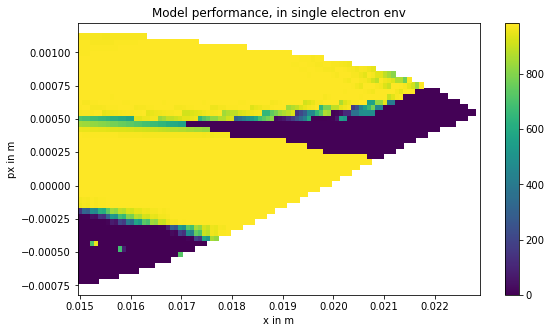

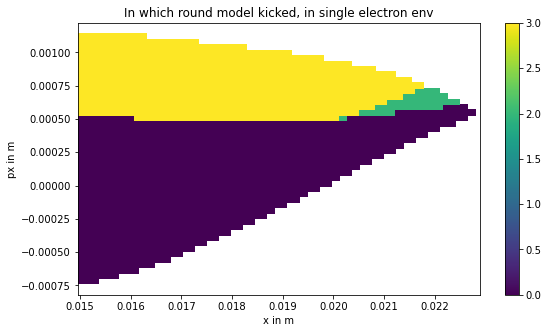

100%|██████████| 5/5 [15:17<00:00, 917.87s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 5 trials to 6 (+1) trials
Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
678.1639388766775                                    
 83%|████████▎ | 5/6 [05:05<?, ?trial/s, best loss=?]

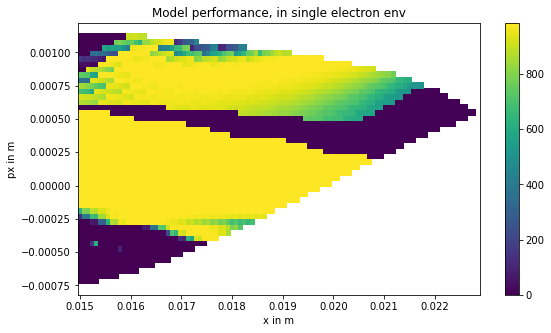

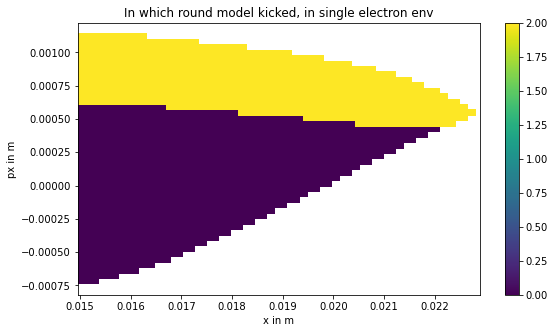

763.7024979651716                                    
 83%|████████▎ | 5/6 [05:07<?, ?trial/s, best loss=?]

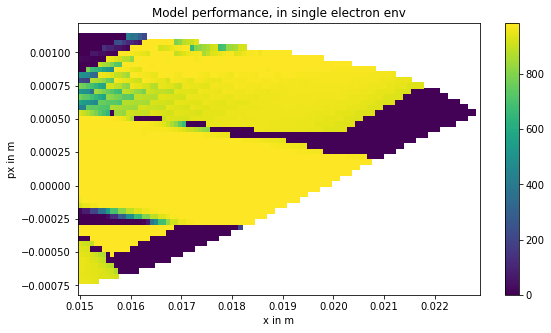

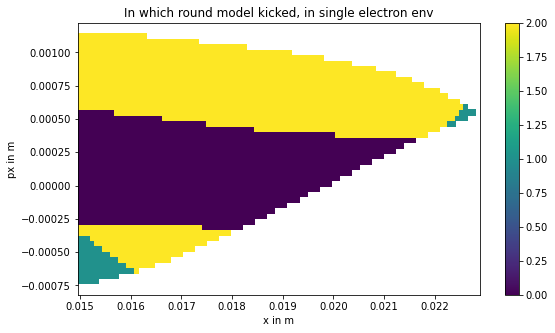

Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
402.1988214419005                                    
 83%|████████▎ | 5/6 [10:12<?, ?trial/s, best loss=?]

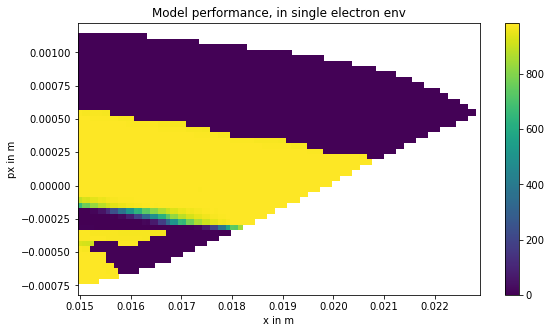

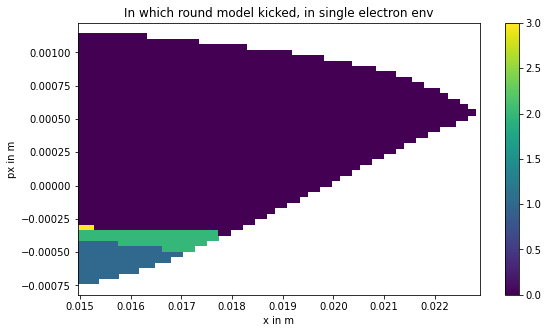

771.5807200771617                                    
 83%|████████▎ | 5/6 [10:13<?, ?trial/s, best loss=?]

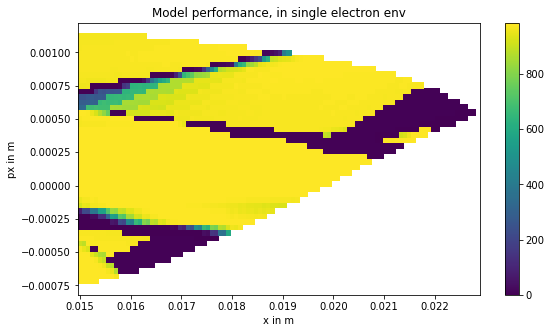

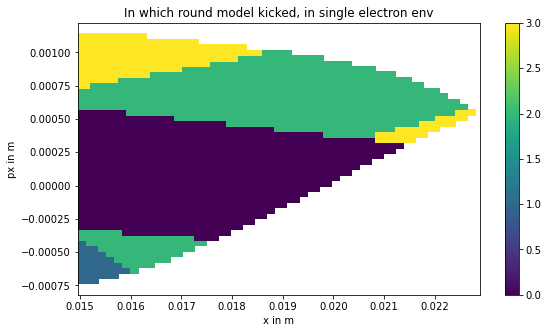

Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Using cuda device                                    
Wrapping the env in a DummyVecEnv.                   
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
720.4171911984506                                    
734.0717026254091                                    
 83%|████████▎ | 5/6 [15:20<?, ?trial/s, best loss=?]

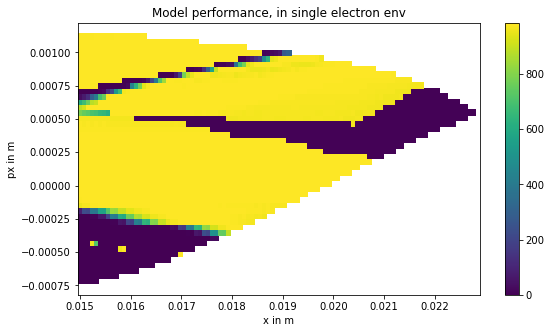

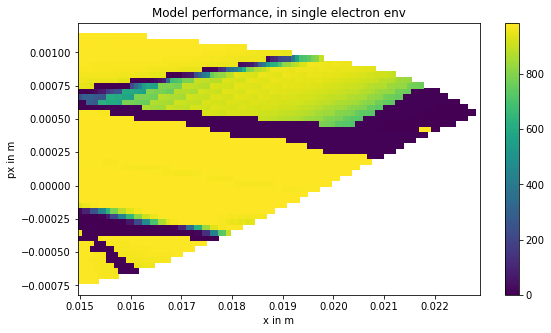

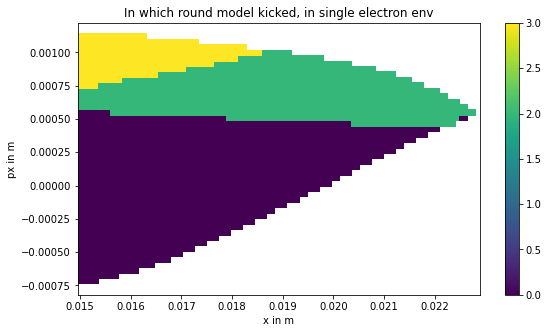

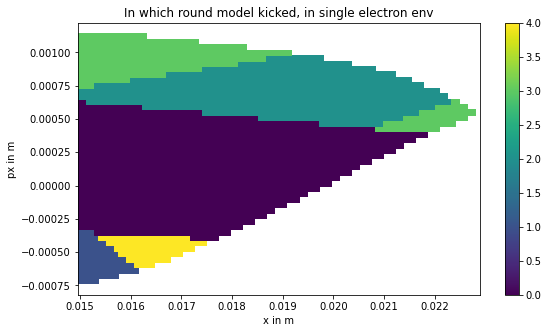

100%|██████████| 6/6 [15:20<00:00, 920.77s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 6 trials to 7 (+1) trials
Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
640.9544260553981                                    
 86%|████████▌ | 6/7 [05:04<?, ?trial/s, best loss=?]

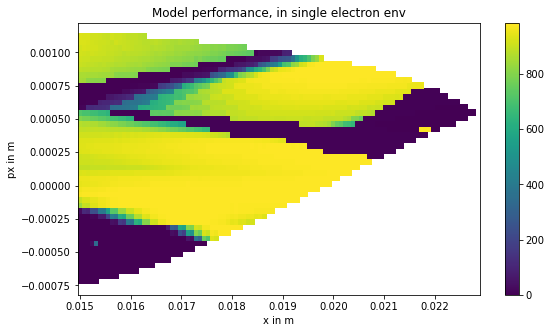

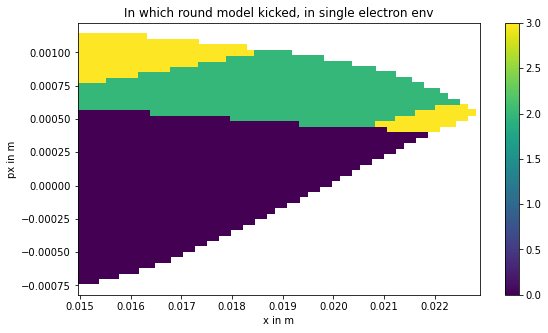

657.8937238710263                                    
 86%|████████▌ | 6/7 [05:05<?, ?trial/s, best loss=?]

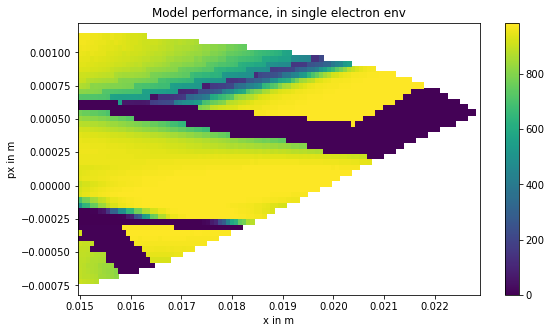

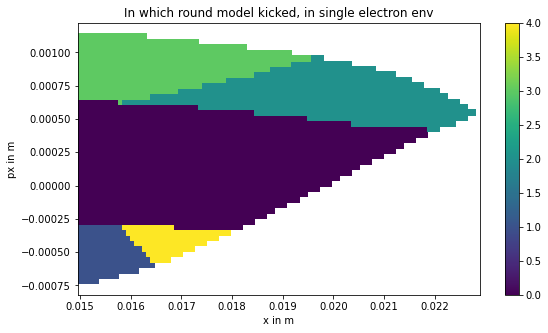

Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
663.5080796253051                                    
 86%|████████▌ | 6/7 [10:11<?, ?trial/s, best loss=?]

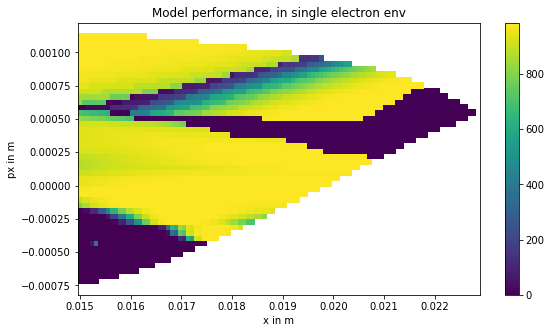

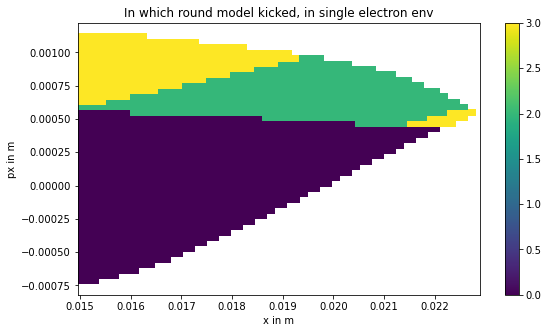

628.3636420690653                                    
 86%|████████▌ | 6/7 [10:11<?, ?trial/s, best loss=?]

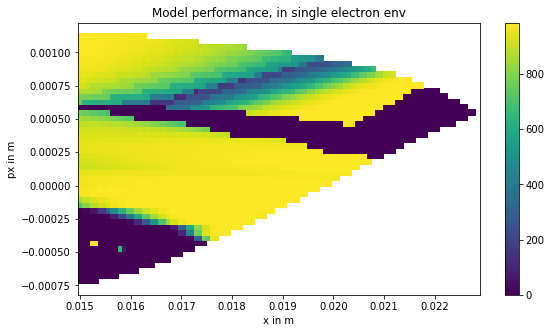

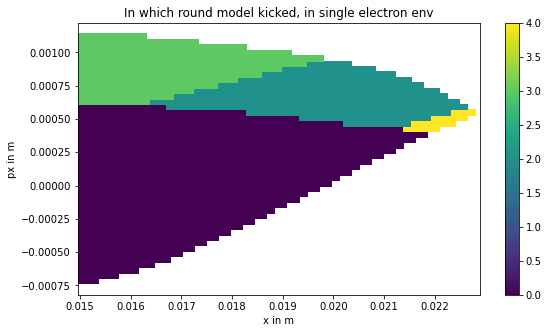

Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Using cuda device                                    
Wrapping the env in a DummyVecEnv.                   
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
646.5131293909277                                    
 86%|████████▌ | 6/7 [15:17<?, ?trial/s, best loss=?]

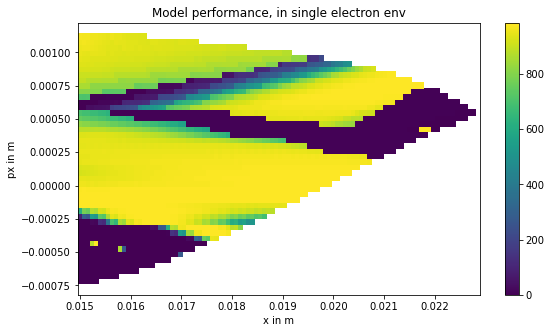

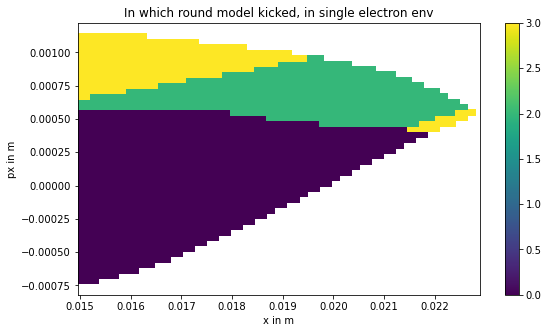

718.0821674154433                                    
 86%|████████▌ | 6/7 [15:18<?, ?trial/s, best loss=?]

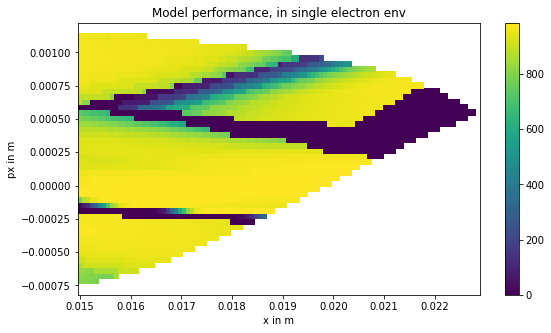

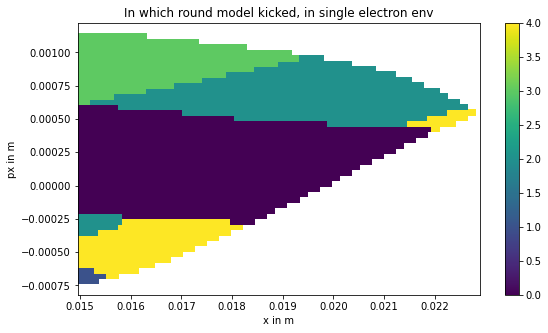

100%|██████████| 7/7 [15:18<00:00, 918.59s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 7 trials to 8 (+1) trials
Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
0.3608058686658132                                   
 88%|████████▊ | 7/8 [05:03<?, ?trial/s, best loss=?]

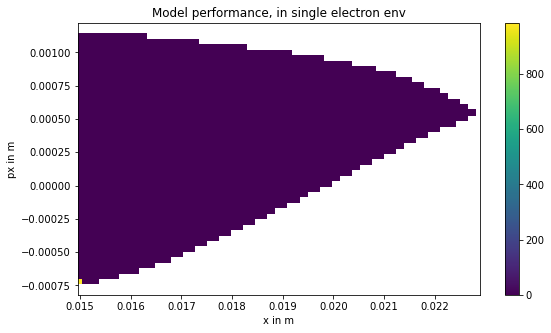

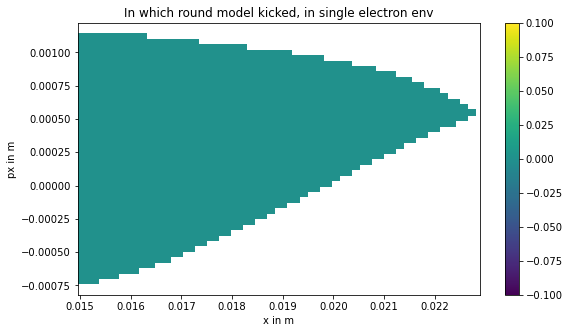

13.606833332385385                                   
 88%|████████▊ | 7/8 [05:03<?, ?trial/s, best loss=?]

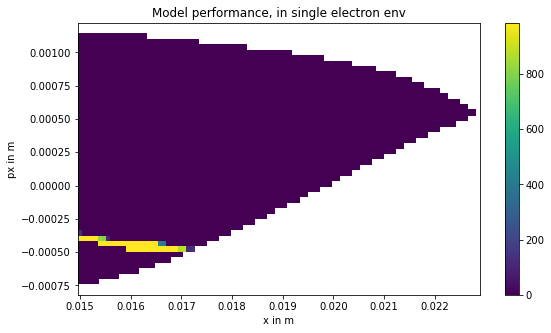

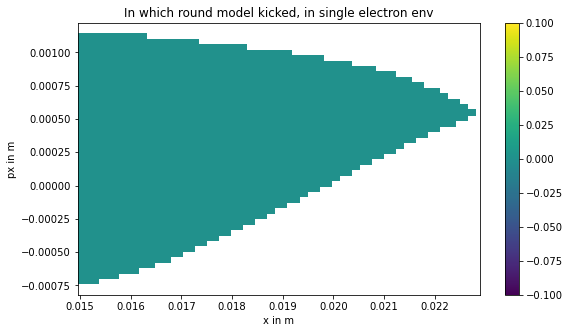

BREAK                                                
6.9838196005255995                                   
50                                                   
100%|██████████| 8/8 [05:04<00:00, 304.25s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 8 trials to 9 (+1) trials
Using cuda device                                    
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
722.1749802176514                                    
732.5015863615153                                    
 89%|████████

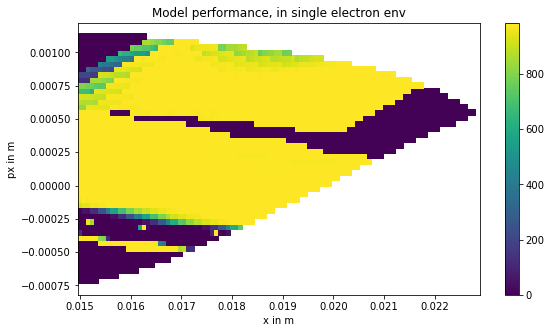

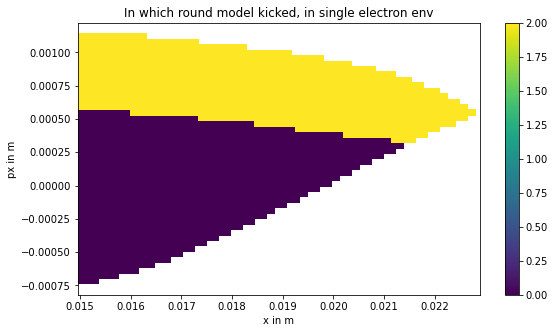

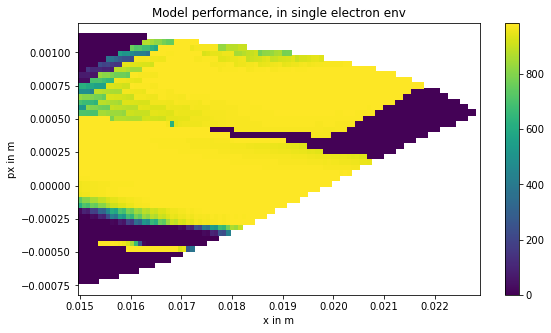

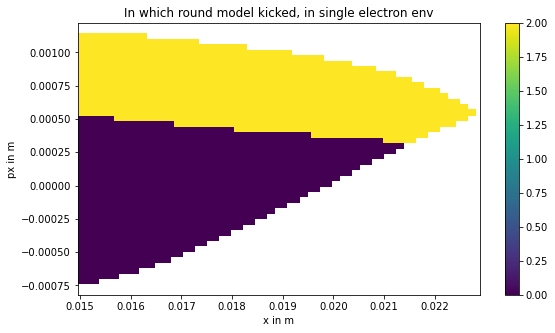

Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
671.7414311558027                                    
 89%|████████▉ | 8/9 [10:11<?, ?trial/s, best loss=?]

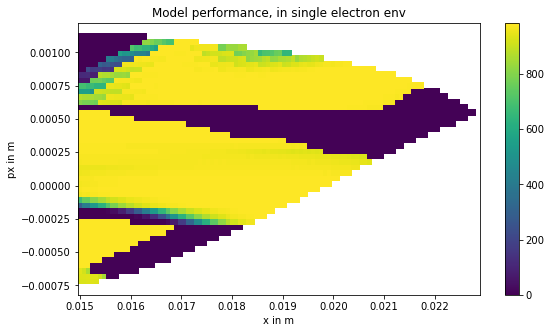

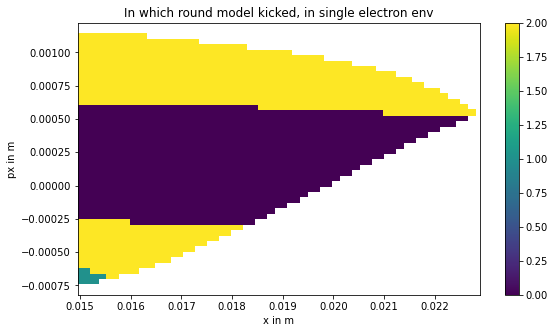

831.3268121544402                                    
 89%|████████▉ | 8/9 [10:12<?, ?trial/s, best loss=?]

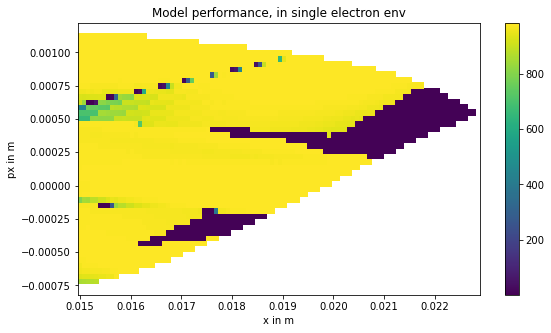

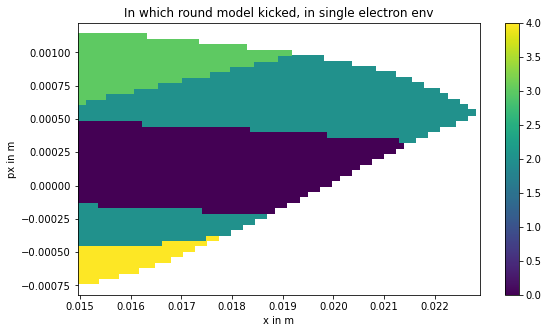

Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
Using cuda device                                    
Wrapping the env with a `Monitor` wrapper            
Wrapping the env in a DummyVecEnv.                   
training done                                        
training done                                        
690.8486813517177                                    
 89%|████████▉ | 8/9 [15:18<?, ?trial/s, best loss=?]

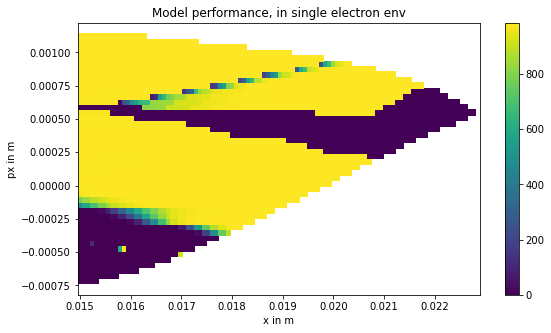

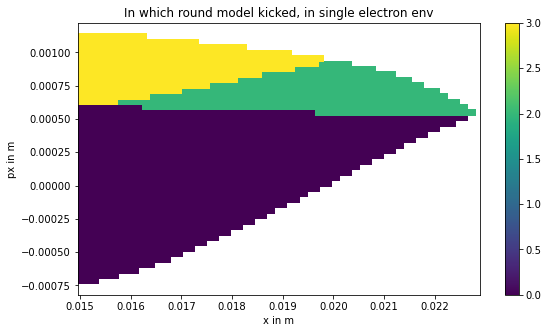

733.961154877085                                     
 89%|████████▉ | 8/9 [15:19<?, ?trial/s, best loss=?]

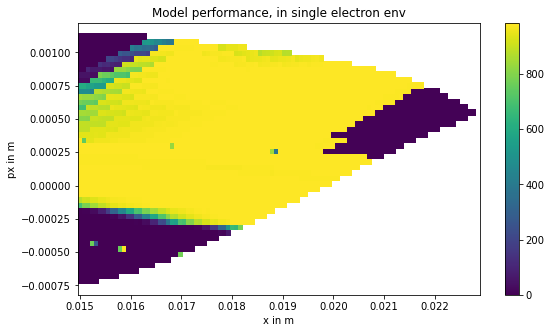

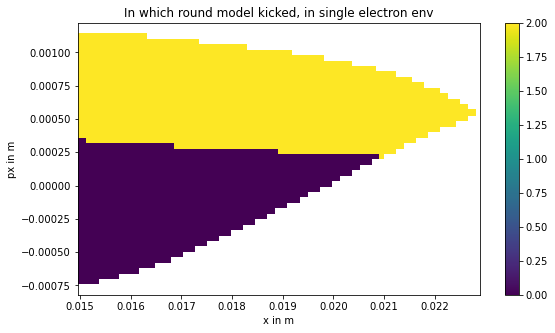

100%|██████████| 9/9 [15:20<00:00, 920.49s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 9 trials to 10 (+1) trials
Using cuda device                                     
Using cuda device                                     
Wrapping the env with a `Monitor` wrapper             
Wrapping the env with a `Monitor` wrapper             
Wrapping the env in a DummyVecEnv.                    
Wrapping the env in a DummyVecEnv.                    
training done                                         
training done                                         
666.2521035534518                                     
 90%|█████████ | 9/10 [05:05<?, ?trial/s, best loss=?]

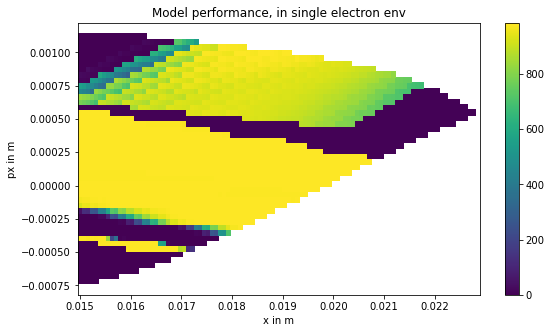

759.3095187219446                                     
 90%|█████████ | 9/10 [05:05<?, ?trial/s, best loss=?]

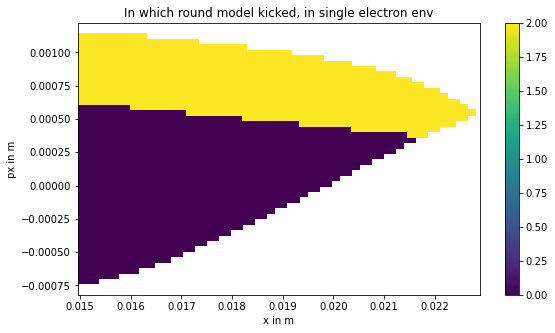

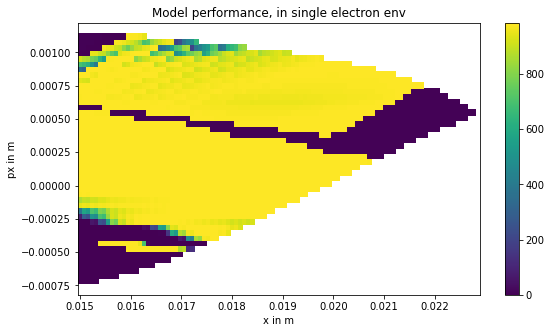

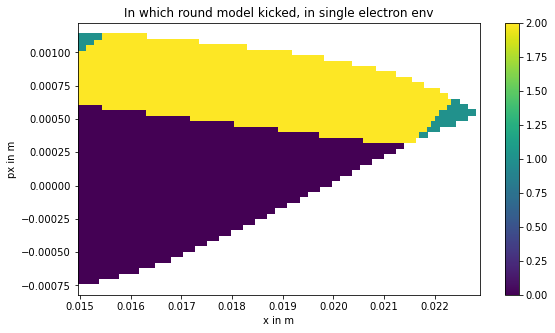

Using cuda device                                     
Wrapping the env with a `Monitor` wrapper             
Using cuda device                                     
Wrapping the env in a DummyVecEnv.                    
Wrapping the env with a `Monitor` wrapper             
Wrapping the env in a DummyVecEnv.                    
training done                                         
training done                                         
708.9429306806657                                     
687.5860075357807                                     
 90%|█████████ | 9/10 [10:10<?, ?trial/s, best loss=?]

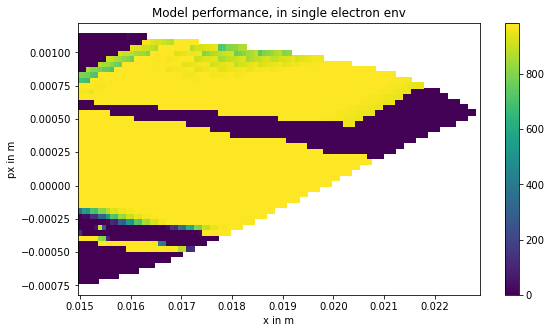

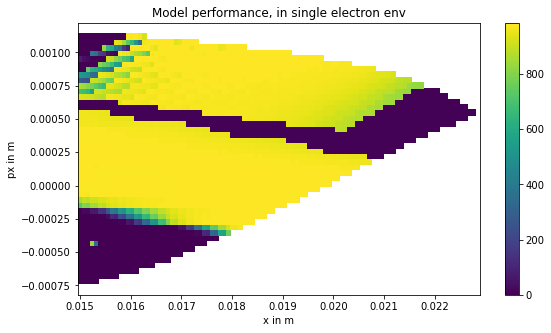

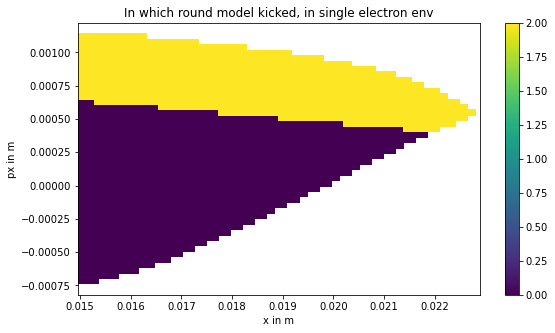

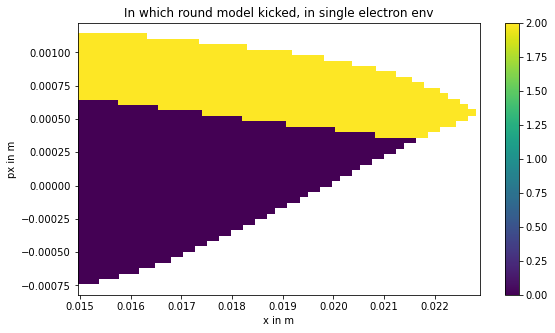

Using cuda device                                     
Wrapping the env with a `Monitor` wrapper             
Using cuda device                                     
Wrapping the env in a DummyVecEnv.                    
Wrapping the env with a `Monitor` wrapper             
Wrapping the env in a DummyVecEnv.                    
training done                                         
training done                                         
684.2046823384829                                     
667.2980163246117                                     
 90%|█████████ | 9/10 [15:15<?, ?trial/s, best loss=?]

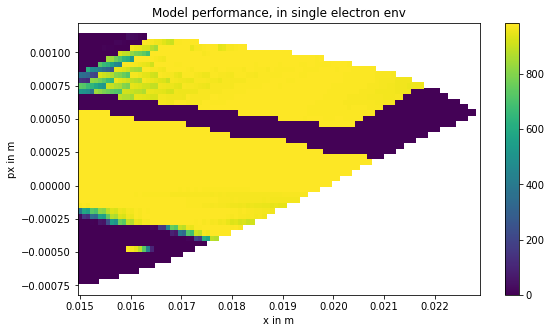

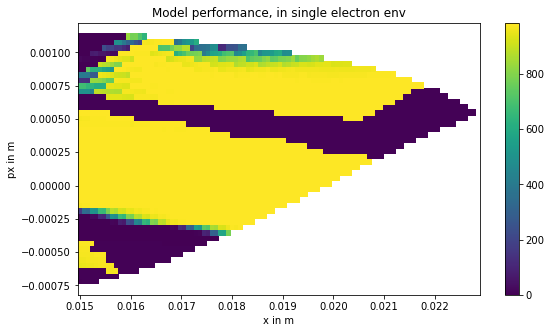

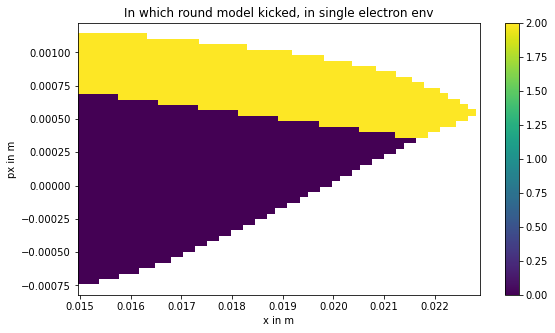

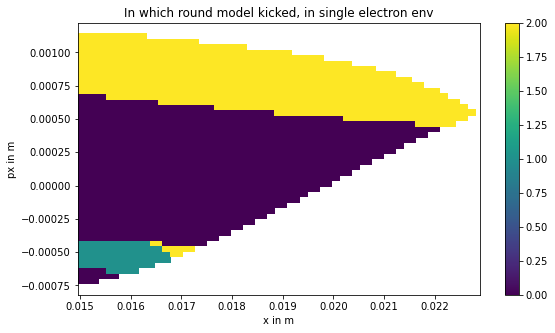

100%|██████████| 10/10 [15:16<00:00, 916.29s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 10 trials to 11 (+1) trials
Using cuda device                                      
Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
758.2066364495257                                      
 91%|█████████ | 10/11 [05:05<?, ?trial/s, best loss=?]

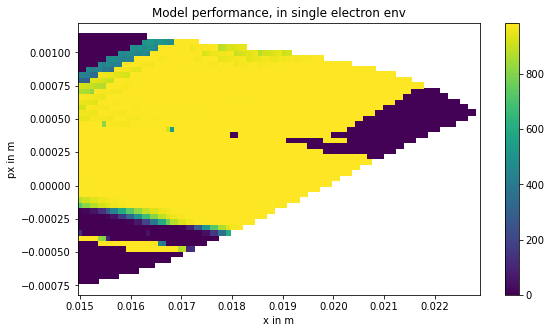

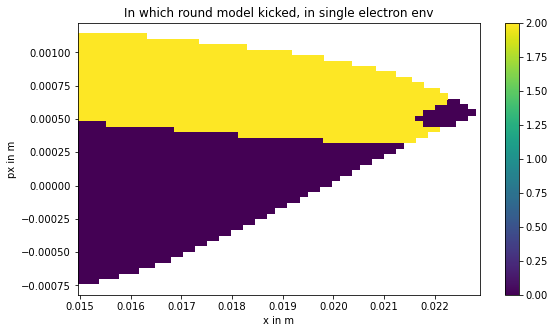

767.6319056438857                                      
 91%|█████████ | 10/11 [05:05<?, ?trial/s, best loss=?]

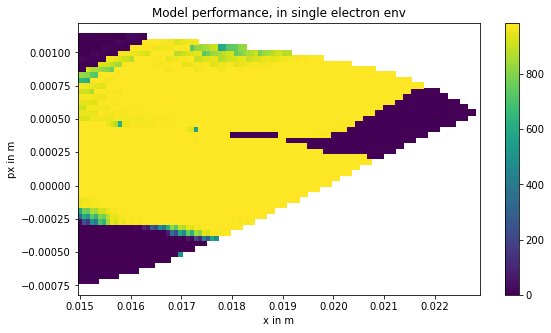

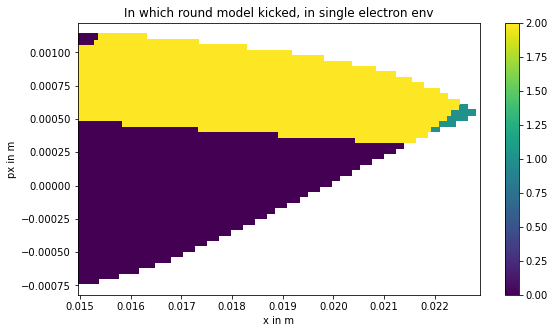

Using cuda device                                      
Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
748.1832649545288                                      
 91%|█████████ | 10/11 [10:11<?, ?trial/s, best loss=?]

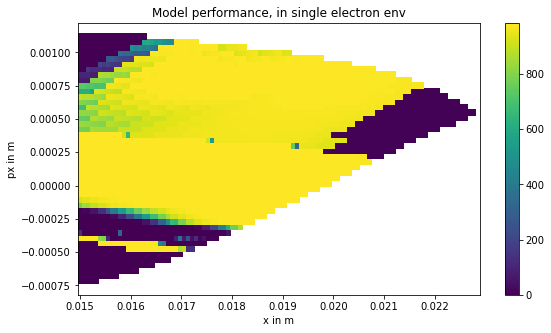

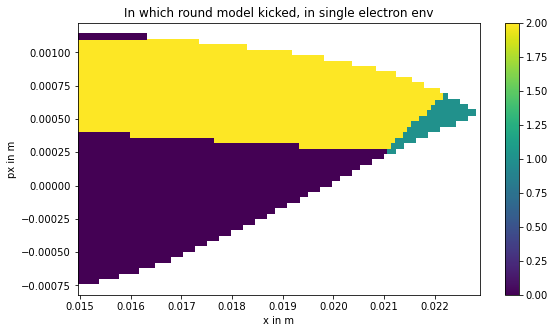

724.1879291744177                                      
 91%|█████████ | 10/11 [10:12<?, ?trial/s, best loss=?]

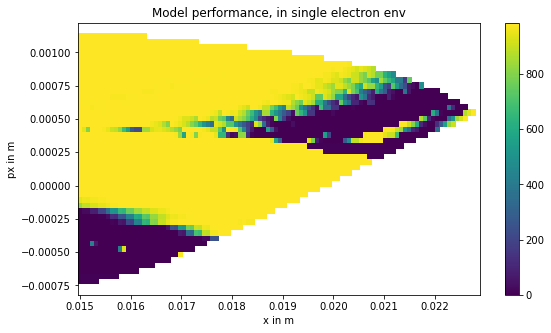

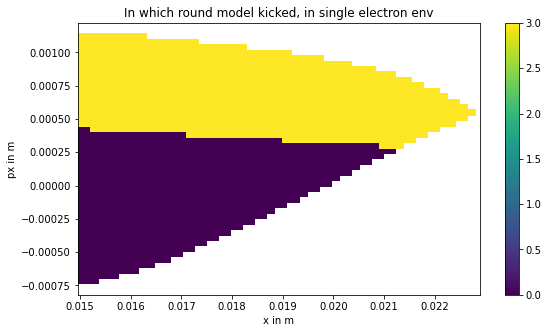

Using cuda device                                      
Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
785.0916690250864                                      
776.7969403839395                                      
 91%|█████████ | 10/11 [15:19<?, ?trial/s, best loss=?]

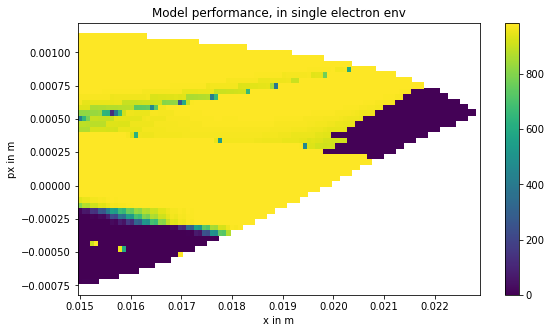

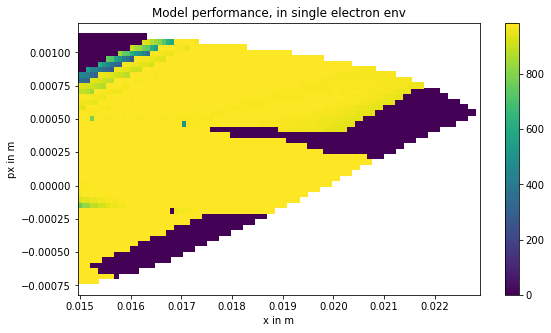

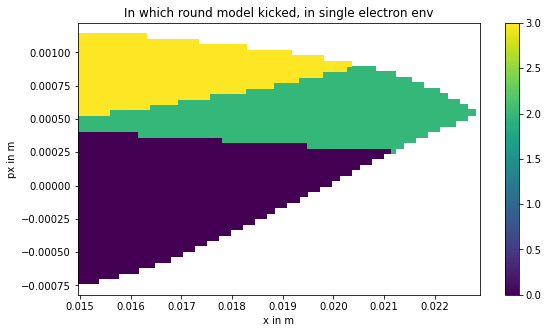

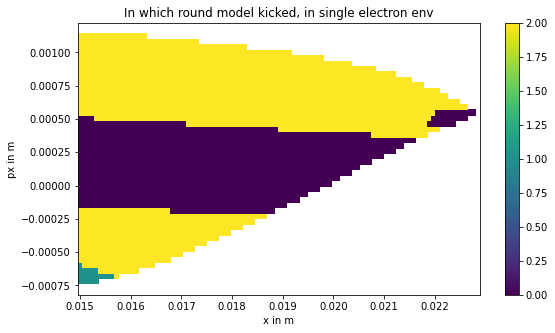

100%|██████████| 11/11 [15:19<00:00, 919.85s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 11 trials to 12 (+1) trials
Using cuda device                                      
Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
785.8658404553894                                      
 92%|█████████▏| 11/12 [05:05<?, ?trial/s, best loss=?]

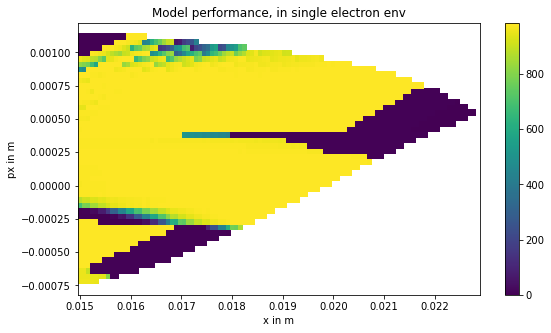

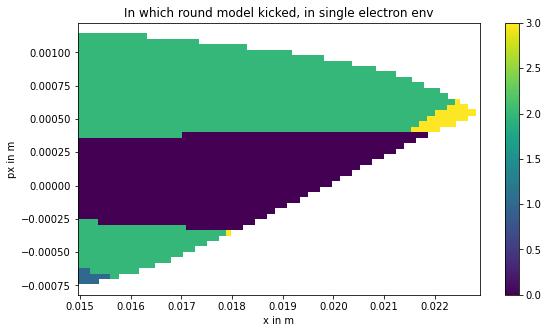

0.0                                                    
 92%|█████████▏| 11/12 [05:12<?, ?trial/s, best loss=?]

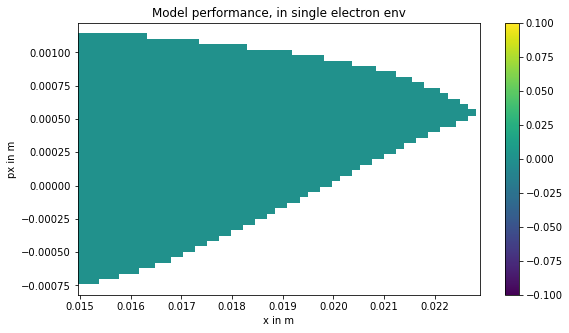

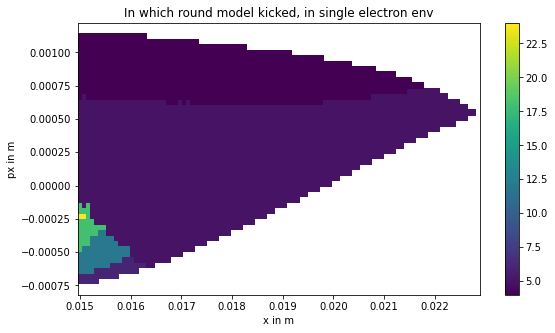

Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Using cuda device                                      
Wrapping the env in a DummyVecEnv.                     
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
220.6458551286078                                      
 92%|█████████▏| 11/12 [10:15<?, ?trial/s, best loss=?]

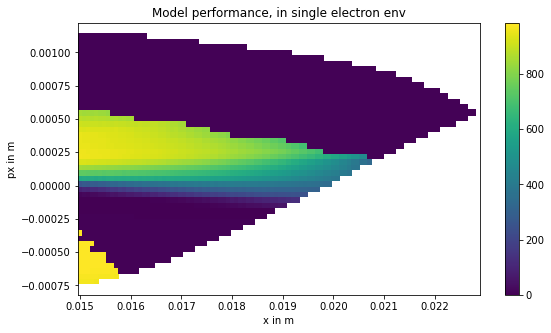

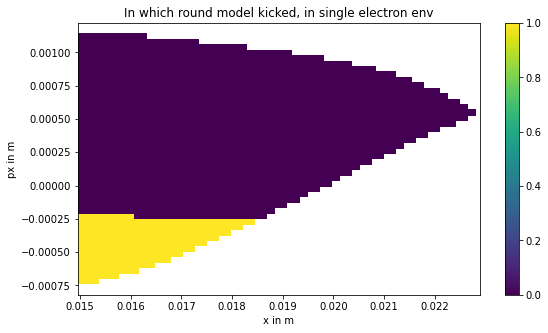

813.7382620744988                                      
 92%|█████████▏| 11/12 [10:18<?, ?trial/s, best loss=?]

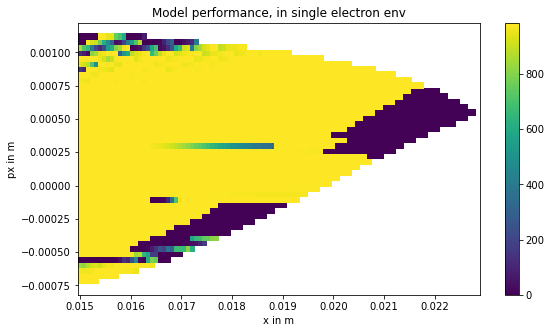

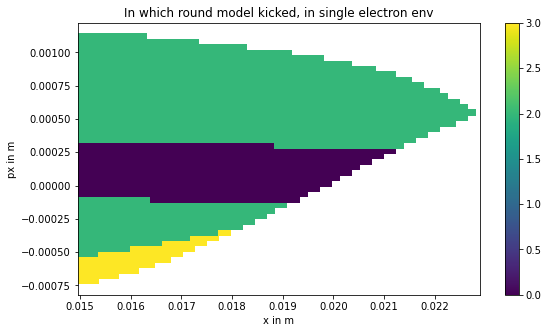

Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Using cuda device                                      
Wrapping the env in a DummyVecEnv.                     
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
670.3006504600503                                      
 92%|█████████▏| 11/12 [15:25<?, ?trial/s, best loss=?]

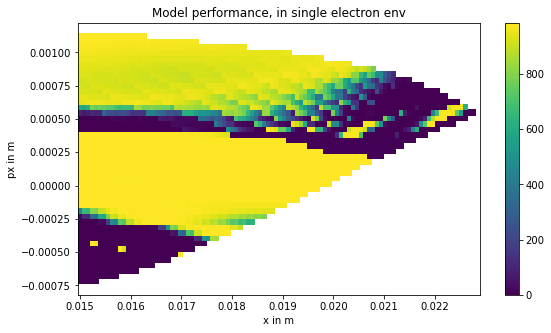

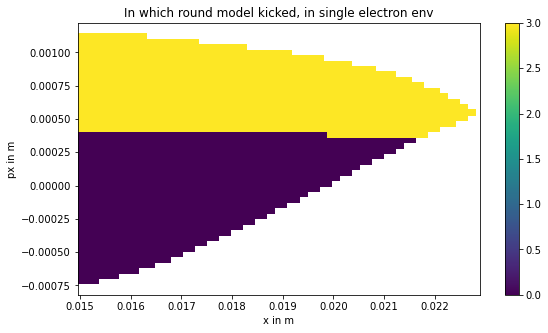

732.6597031953588                                      
 92%|█████████▏| 11/12 [15:28<?, ?trial/s, best loss=?]

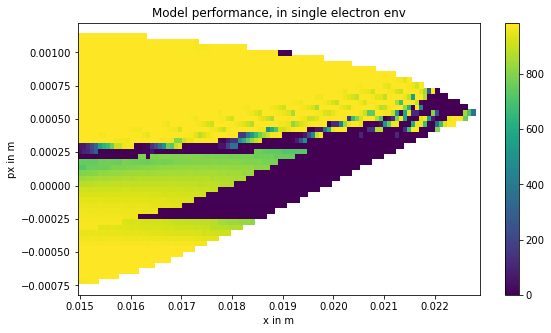

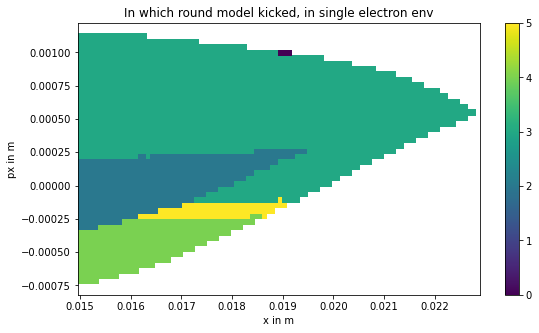

100%|██████████| 12/12 [15:28<00:00, 928.80s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 12 trials to 13 (+1) trials
Using cuda device                                      
Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
390.47879358374865                                     
 92%|█████████▏| 12/13 [05:03<?, ?trial/s, best loss=?]

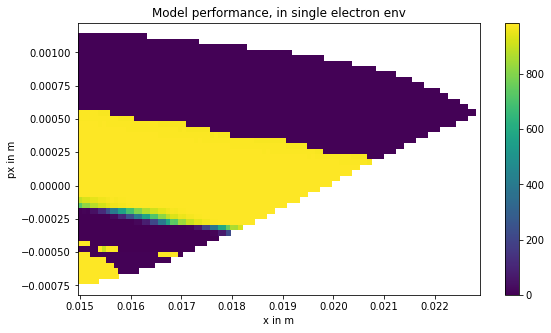

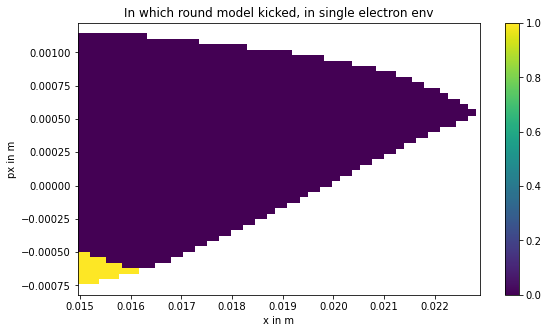

474.7956089537772                                      
 92%|█████████▏| 12/13 [05:04<?, ?trial/s, best loss=?]

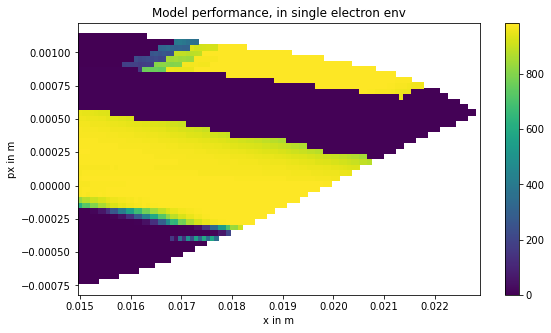

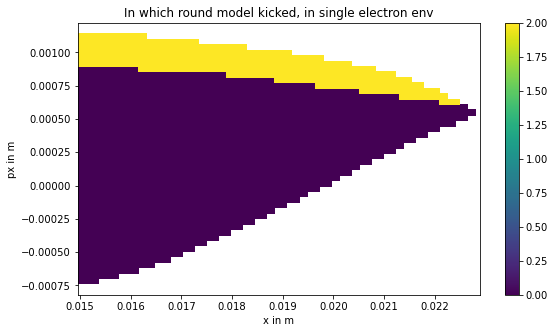

Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
404.40901974807196                                     
398.5326596919489                                      
 92%|█████████▏| 12/13 [10:07<?, ?trial/s, best loss=?]

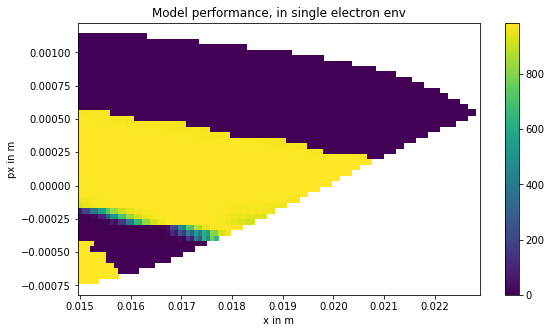

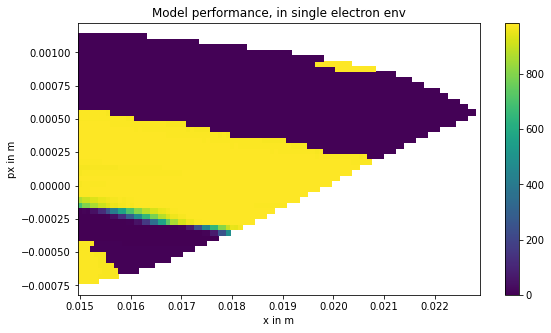

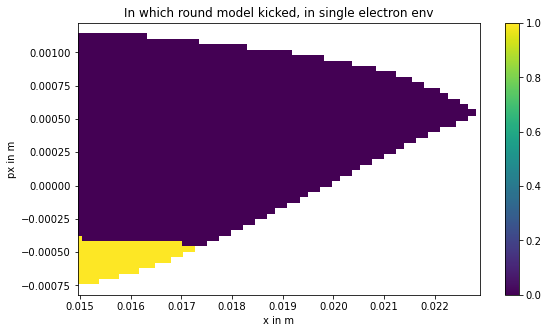

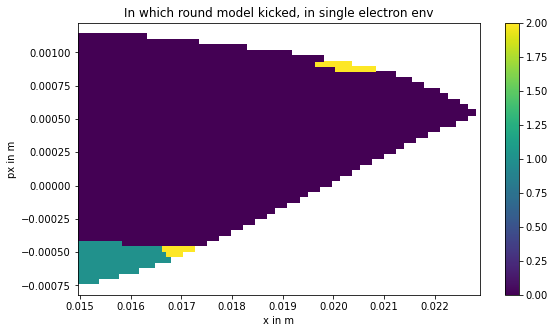

Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Using cuda device                                      
Wrapping the env in a DummyVecEnv.                     
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
486.70909952893936                                     
 92%|█████████▏| 12/13 [15:11<?, ?trial/s, best loss=?]

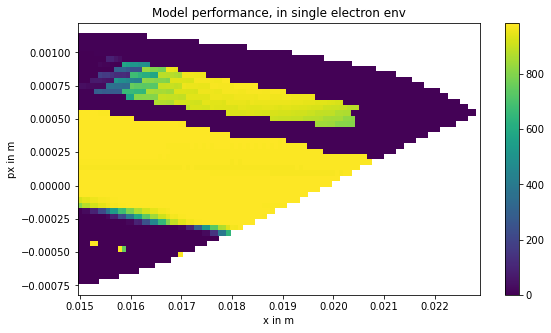

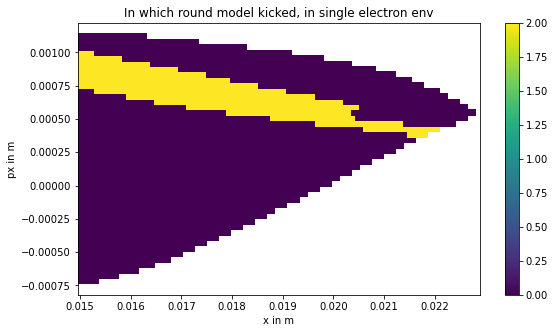

536.5679506812818                                      
 92%|█████████▏| 12/13 [15:12<?, ?trial/s, best loss=?]

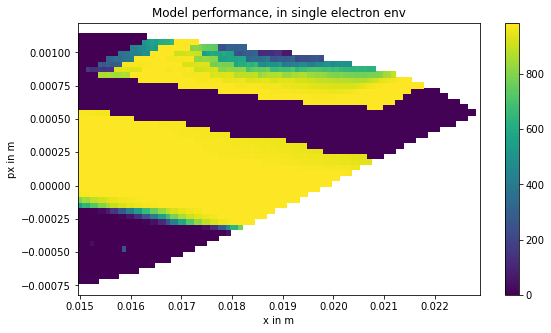

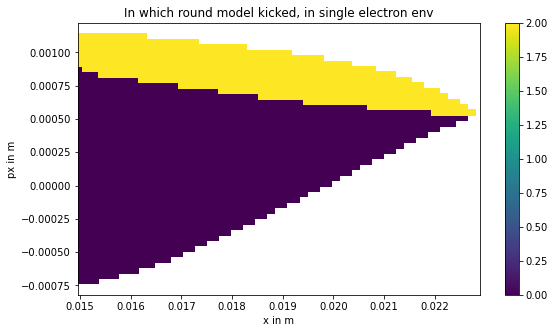

100%|██████████| 13/13 [15:12<00:00, 912.84s/trial, best loss: -0.8067196539106458]
Run: {'gamma': 1.3552019060166074, 'learning_rate': 0.0027221050807848864, 'noise_std': 0.37719885384457363, 'piNN': 2, 'qfNN': 5}
Found saved Trials! Loading...
Rerunning from 13 trials to 14 (+1) trials
Using cuda device                                      
Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
Wrapping the env in a DummyVecEnv.                     
training done                                          
training done                                          
390.982170485248                                       
 93%|█████████▎| 13/14 [05:03<?, ?trial/s, best loss=?]

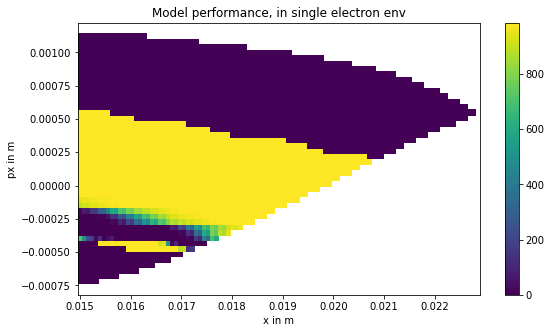

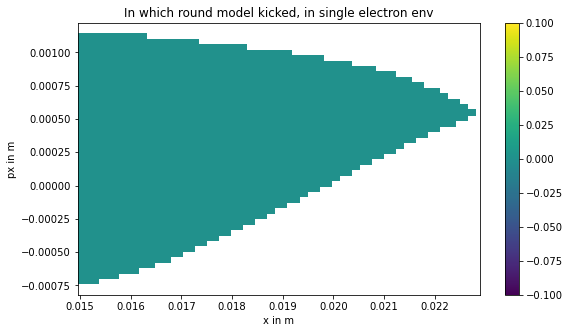

387.7642600529992                                      
 93%|█████████▎| 13/14 [05:03<?, ?trial/s, best loss=?]

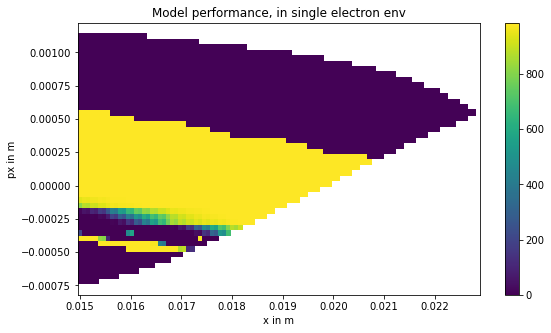

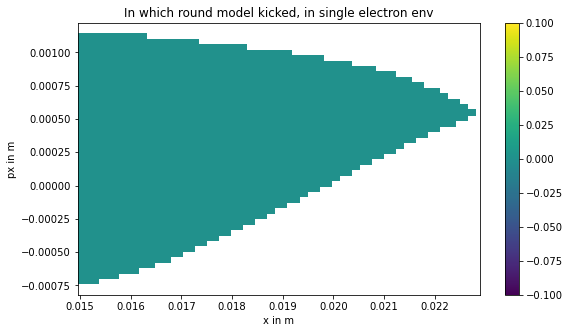

Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
Using cuda device                                      
Wrapping the env with a `Monitor` wrapper              
Wrapping the env in a DummyVecEnv.                     
 93%|█████████▎| 13/14 [05:04<?, ?trial/s, best loss=?]

Process ForkPoolWorker-116:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-8-ef163140120d>", line 38, in objective
    werte = p.map(worker,[space,space])
  File "/home/al3xber/anaconda3/lib/python3.8/multiprocessing/pool.py", line 364, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/home/al3xber/anaconda3/lib/python3.8/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/home/al3xber/anaconda3/lib/python3.8/multiprocessing/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/home/al3xber/anaconda3/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/home/al3xber/anaconda3/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/al3xber/anaconda3/lib/python3.8/site-packages/hyperopt/progress.py", line 25, in tqdm_progress_callback
    yield pb


KeyboardInterrupt



In [10]:
for k in range(300):
    run_trials()